# Making the 95th efficiency plots 

In [6]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/pt_regress_v1.h5'

# First we need to reproduce the efficiency plots but with corrected pT

In [7]:
def plot_pt_eff_puppi(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input)).flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

In [8]:
def plot_pt_eff_puppi_no_nn(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input)).flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig > corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

1891/1891 [==============================] - 2s 1ms/step


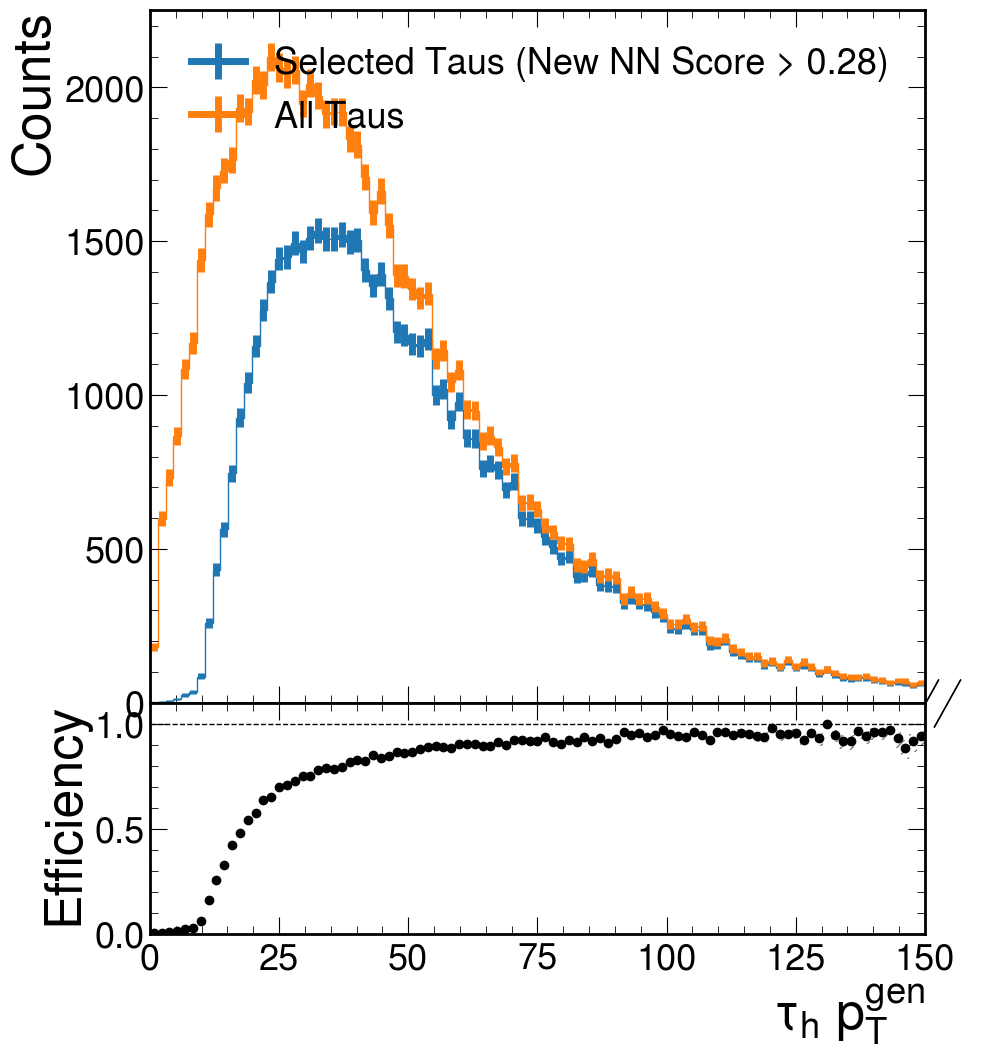

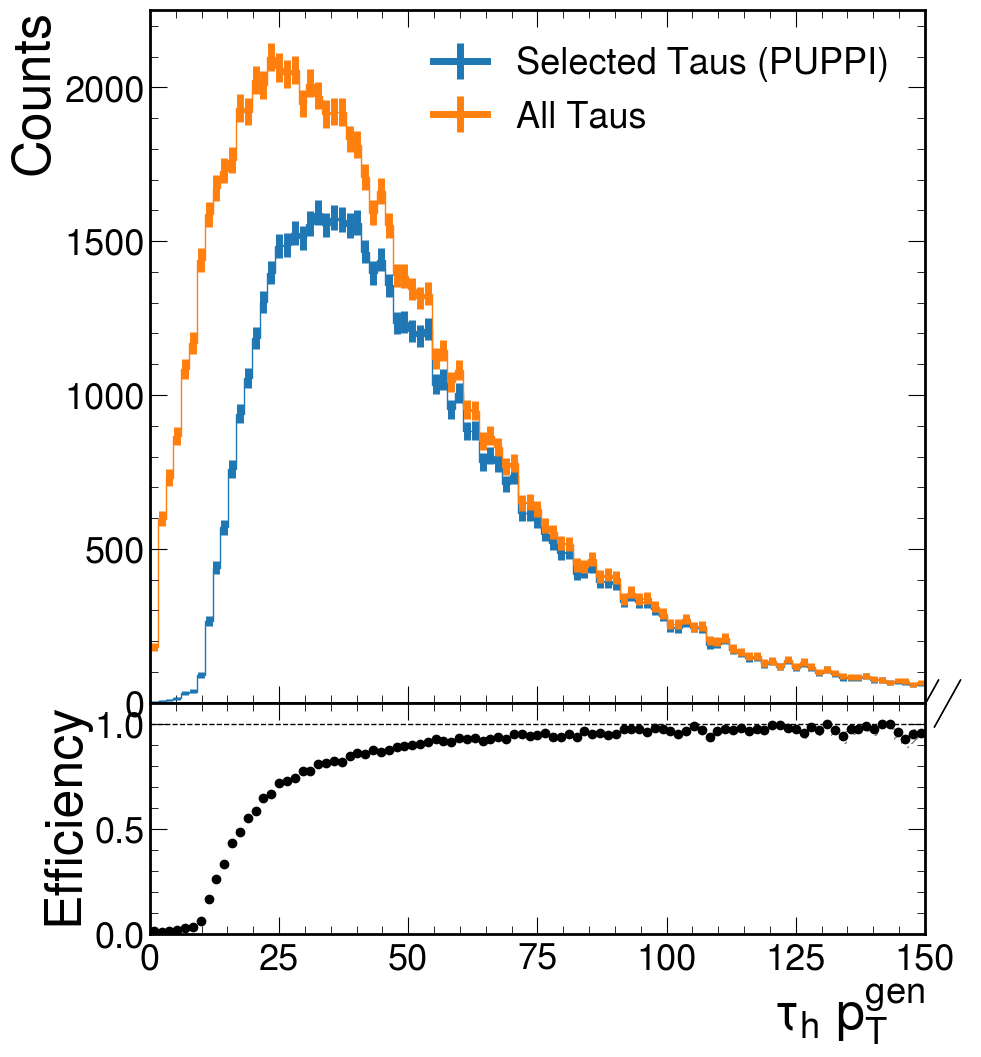

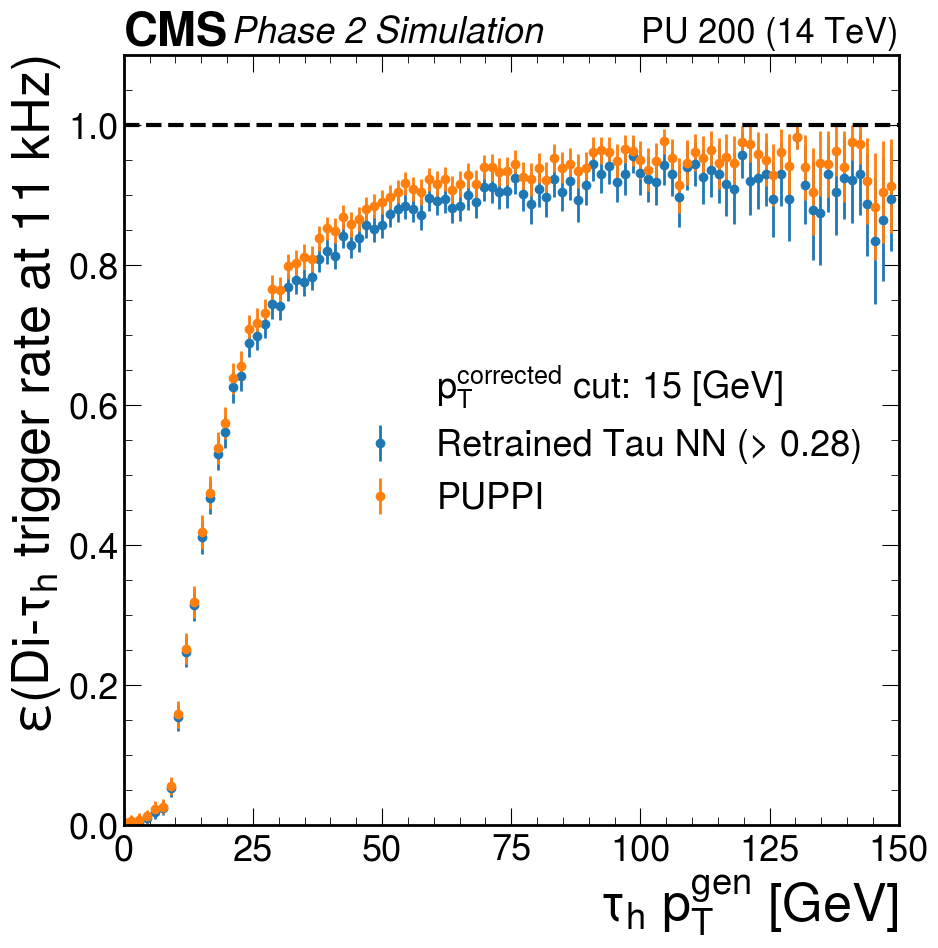

In [9]:
results = plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=15.,
                            cut_point = 0.28)

1905/1905 [==============================] - 2s 1ms/step


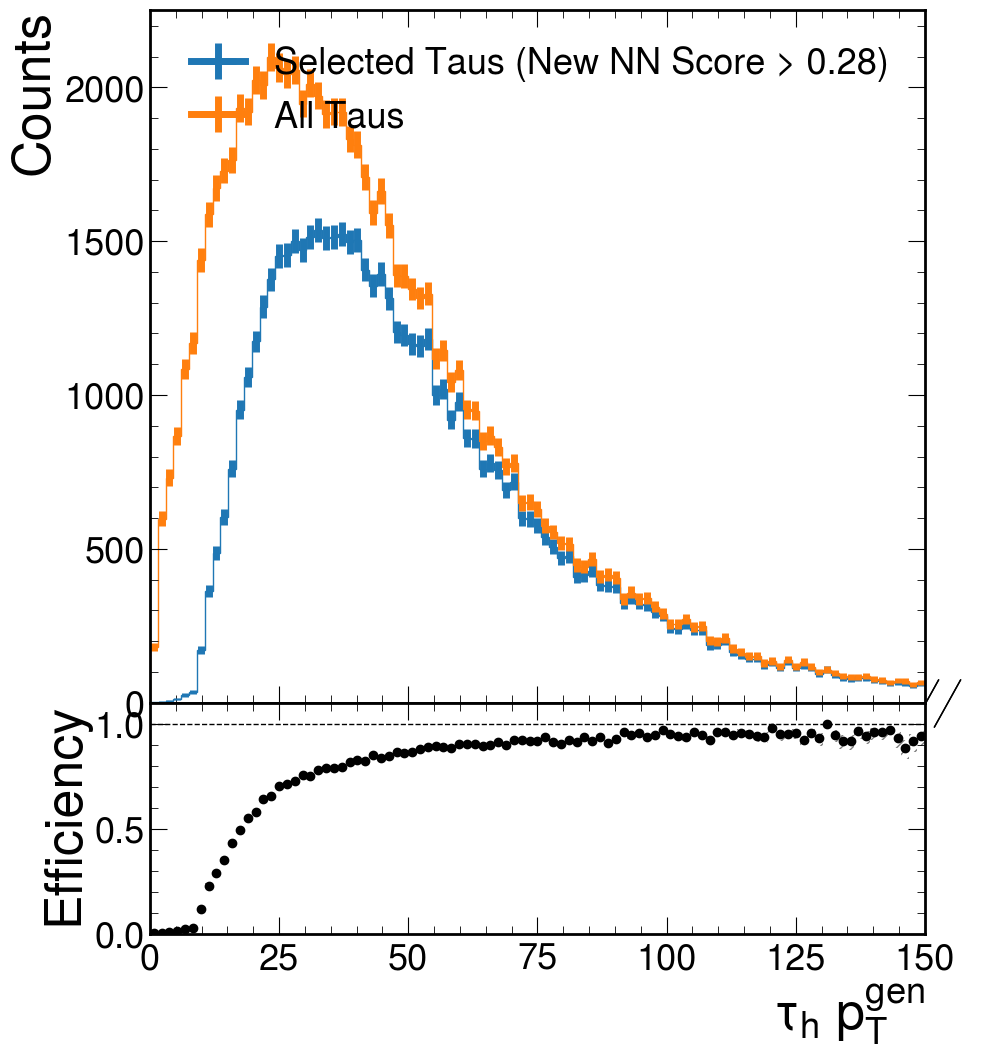

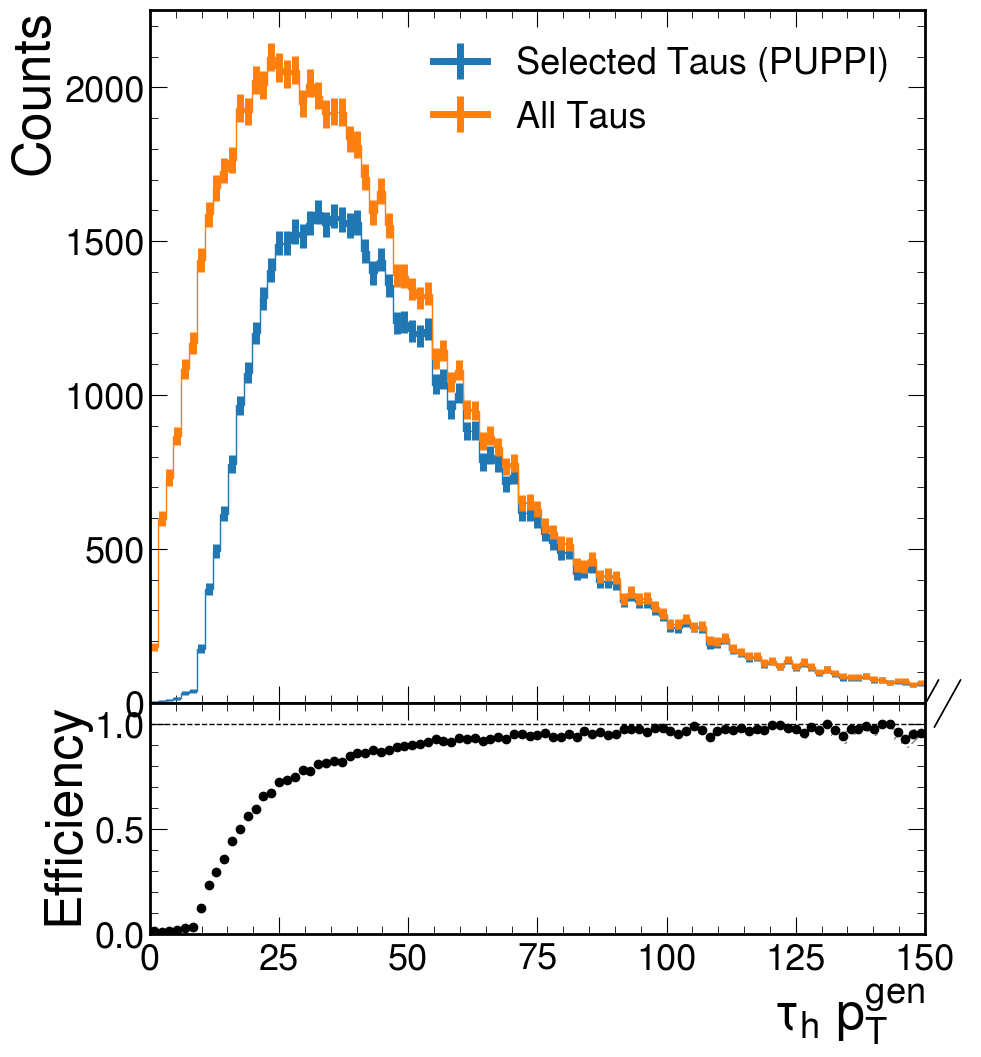

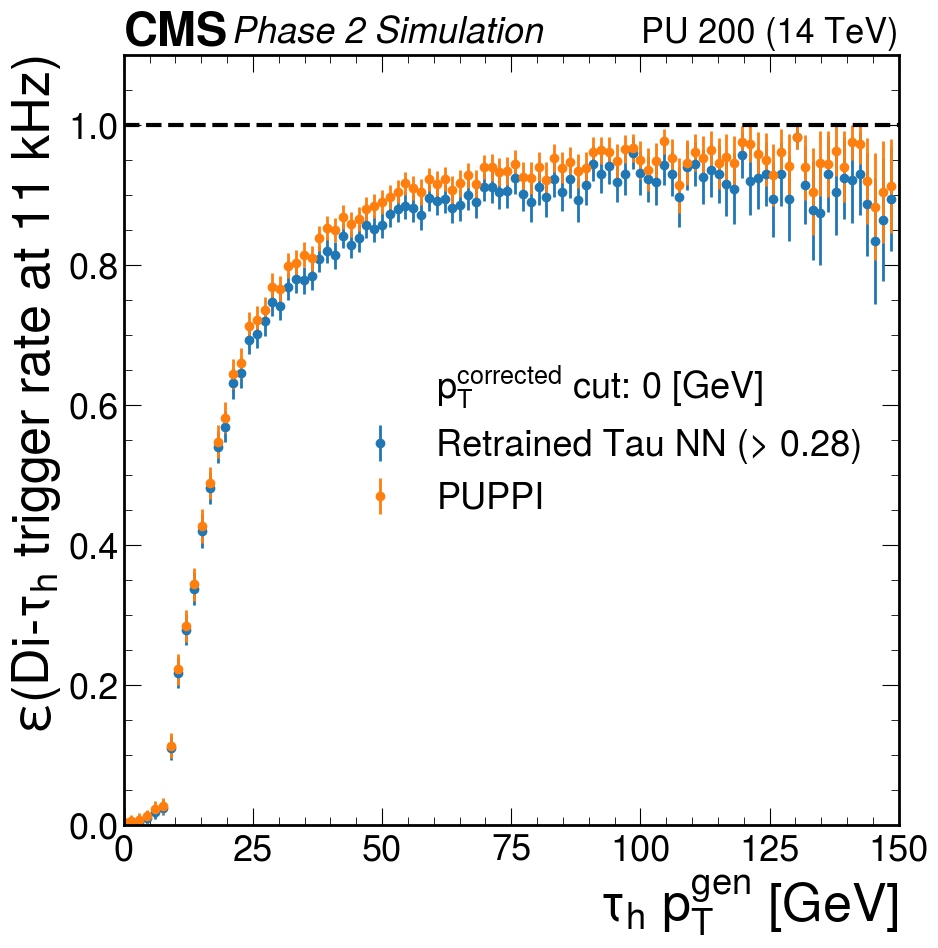

1891/1891 [==============================] - 2s 904us/step


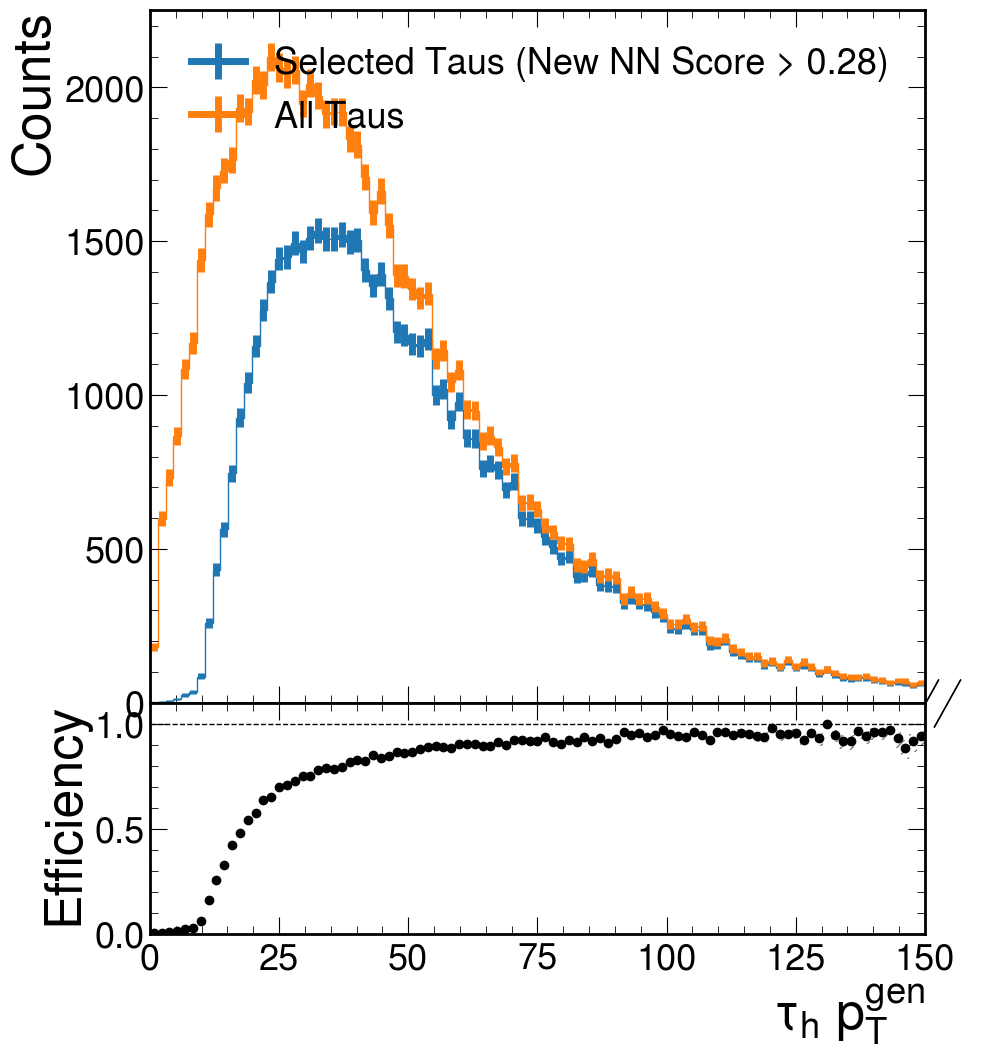

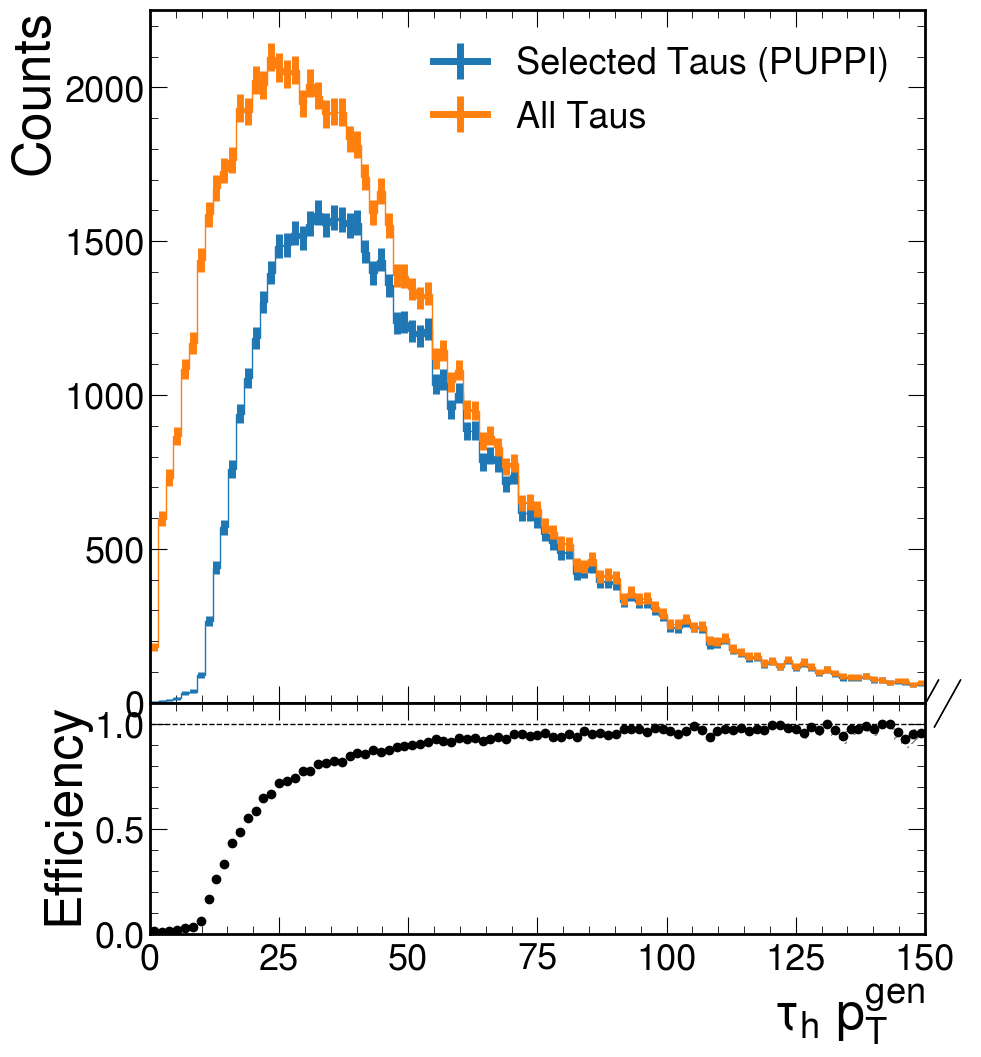

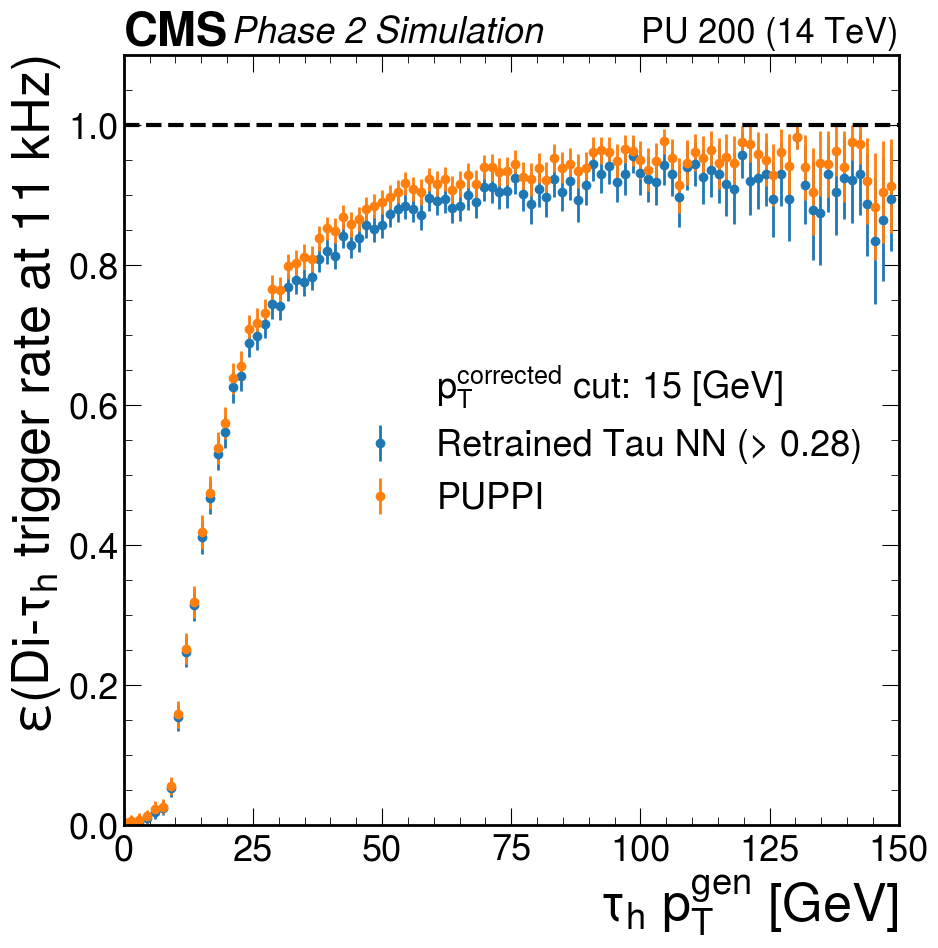

[1.         1.         1.         1.         1.         1.
 0.48218637 0.70465039 0.88566901 0.93198001 0.97846045 0.97098751
 0.98259211 0.98693221 0.9912519  0.99330736 0.99365096 0.99577455
 0.99589707 0.99581538 0.99864275 0.99866226 0.99863713 0.99660018
 0.99932426 1.         0.99931415 0.99926652 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99897287 1.         1.         1.         1.
 1.         0.9986427  1.         1.         1.         1.
 1.         1.         1.         1.         0.99770863 0.99772443
 1.         1.         1.         0.99713409 1.         1.
 1.         1.         1.         1.         1.         0.99583853
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.  

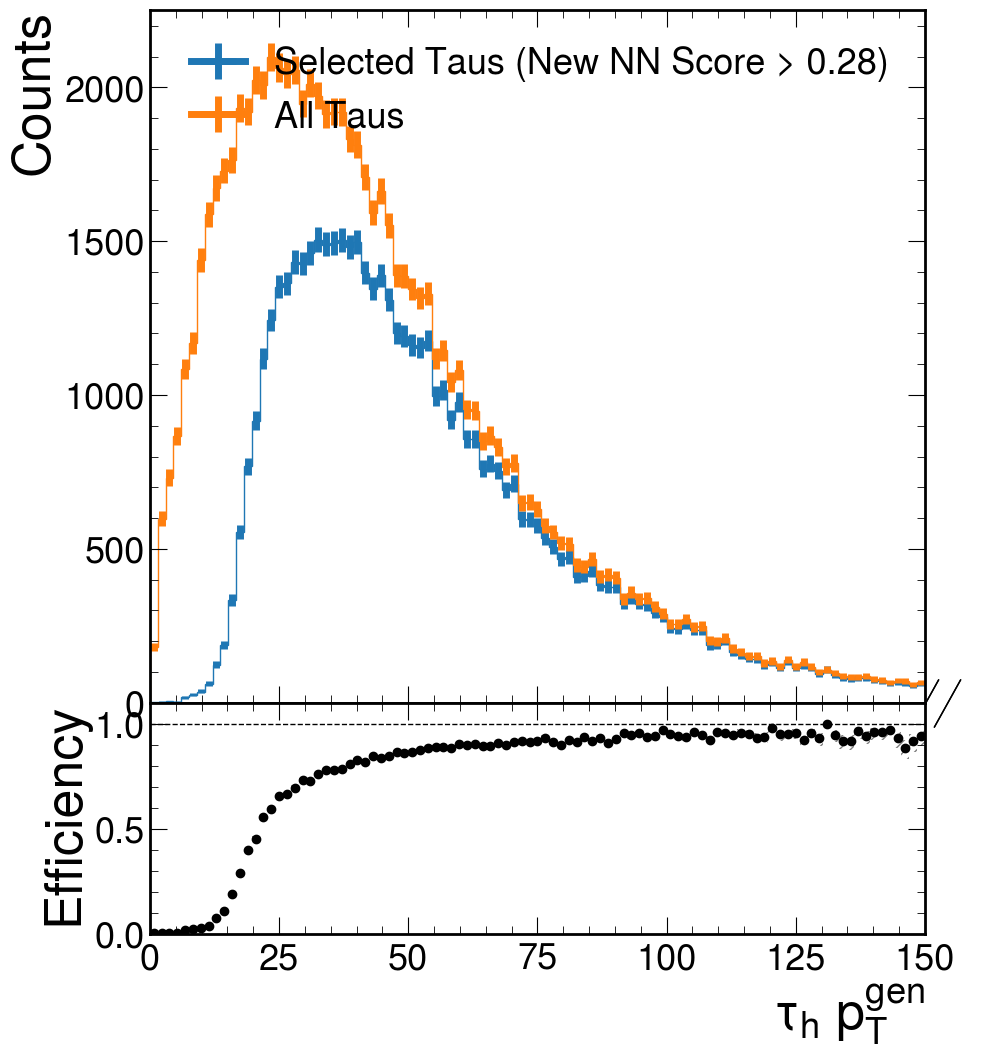

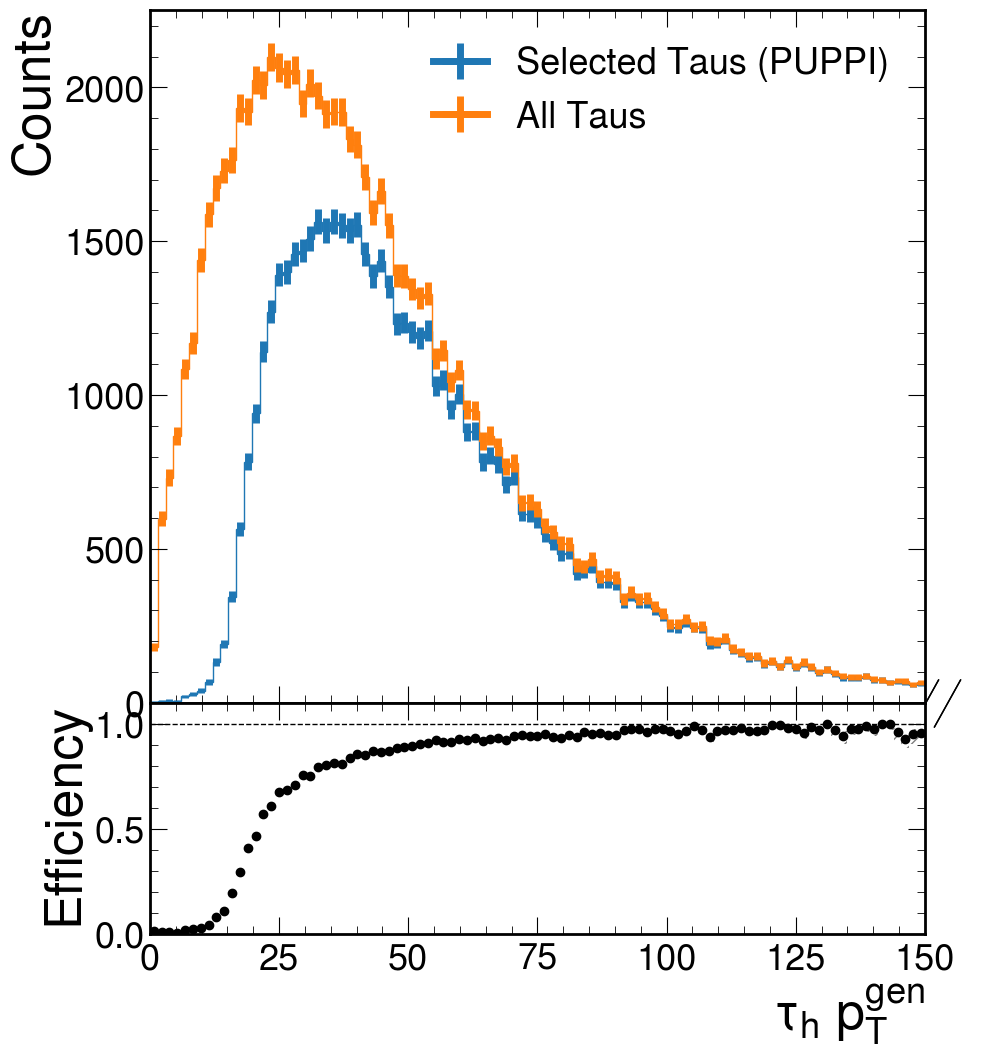

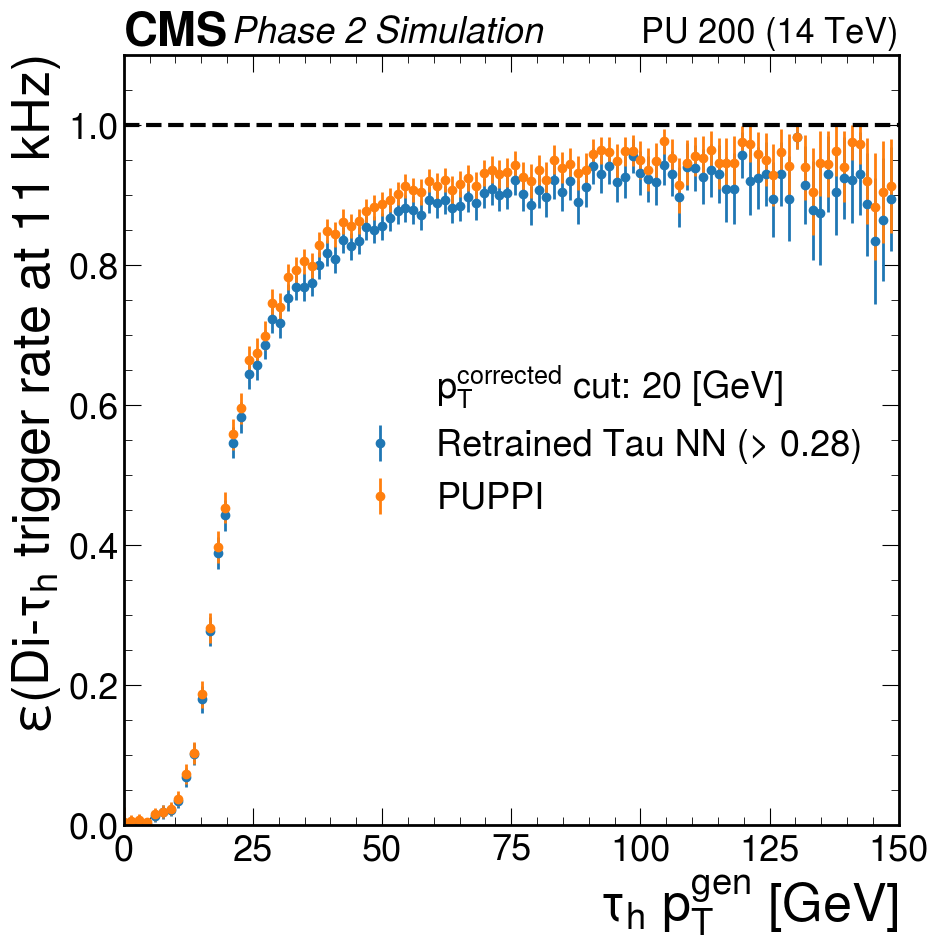

[1.         1.         0.73418389 0.15910602 0.67482775 0.74215756
 0.19079961 0.15453883 0.24289434 0.29852383 0.42768106 0.57431198
 0.720451   0.7767056  0.86585151 0.90198092 0.92883625 0.9352865
 0.95354198 0.9686368  0.96609532 0.97927652 0.98637651 0.98776398
 0.9878412  0.98898987 0.99519993 0.99266719 0.99236082 0.99703235
 0.99606007 0.99654617 0.99825941 0.99732106 0.99460287 0.9964653
 0.99580557 0.99691924 1.         0.99784888 0.99631801 0.99876995
 1.         0.9986427  0.99579096 0.99846495 0.99109712 0.99641653
 0.99641454 0.998138   0.99798015 1.         0.99541896 0.99545119
 1.         0.99735037 1.         0.99713409 0.99712907 0.99709316
 0.99649288 1.         1.         1.         0.99618205 0.99583853
 1.         1.         1.         1.         1.         1.
 1.         0.99420271 1.         1.         1.         0.99184982
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.       

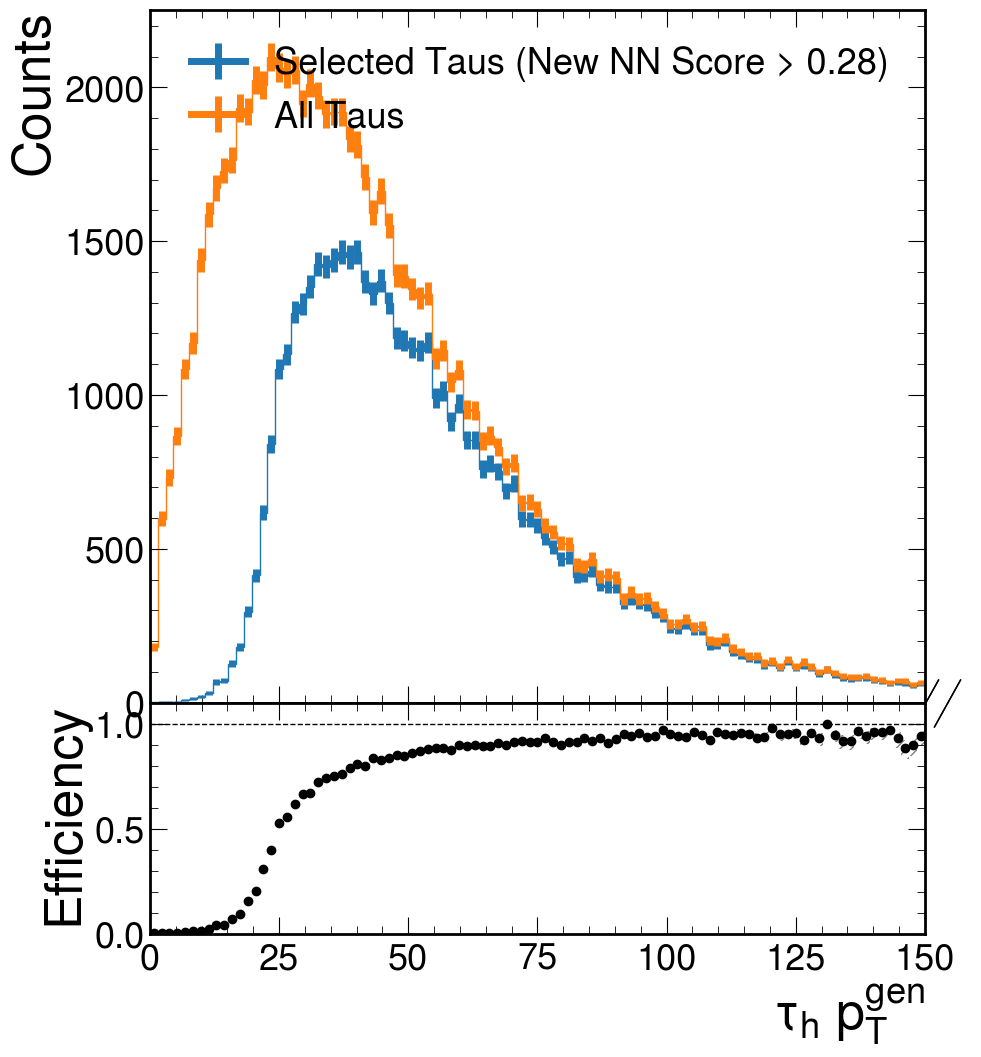

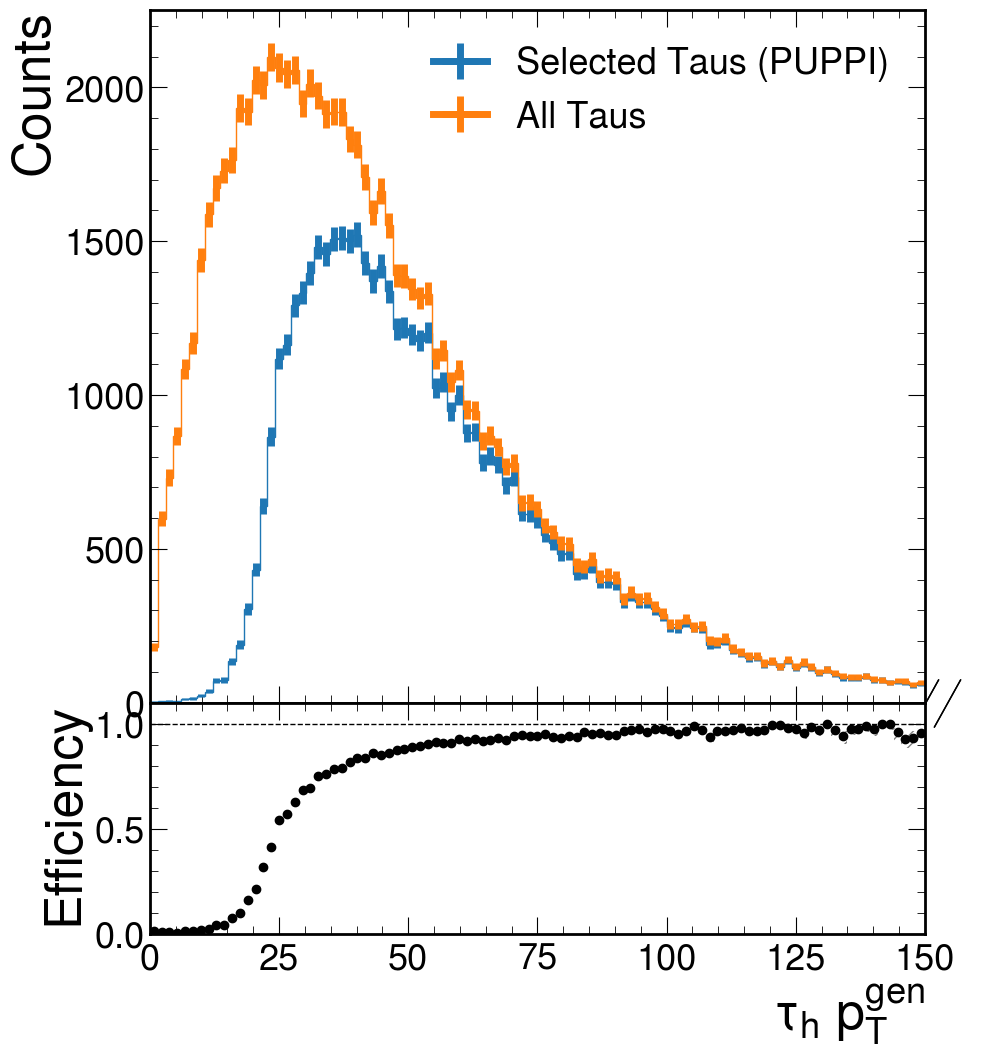

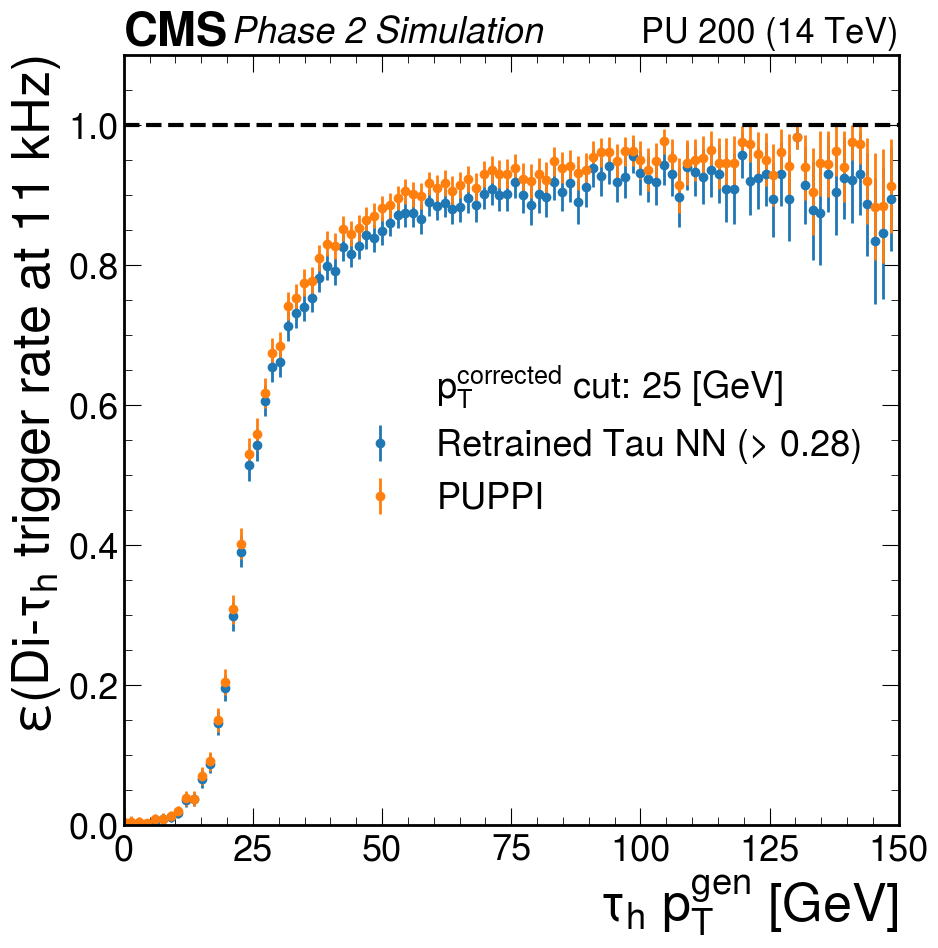

[1.         0.5177983  0.48121536 0.08239214 0.31622655 0.33449848
 0.09885081 0.07654018 0.12648479 0.10924605 0.15692499 0.18085689
 0.2694496  0.3436873  0.47199838 0.60443904 0.74152982 0.77344671
 0.84251819 0.87689662 0.89168413 0.92590146 0.9374208  0.95043016
 0.96085388 0.96562289 0.9725965  0.97142637 0.98015085 0.98442903
 0.98739793 0.98274645 0.98434837 0.99018197 0.98651576 0.99028478
 0.98847376 0.99178866 0.99316654 0.99354994 0.99263926 0.99385357
 0.9986108  0.99728583 0.9943891  0.99539671 0.98961593 0.99641653
 0.99641454 0.99627728 0.9939469  0.99787703 0.99541896 0.98864464
 1.         0.99470495 1.         0.99427322 0.99712907 0.99709316
 0.99299933 0.99670583 1.         1.         0.99618205 0.99583853
 1.         1.         1.         1.         1.         1.
 1.         0.98845033 1.         1.         1.         0.99184982
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.     

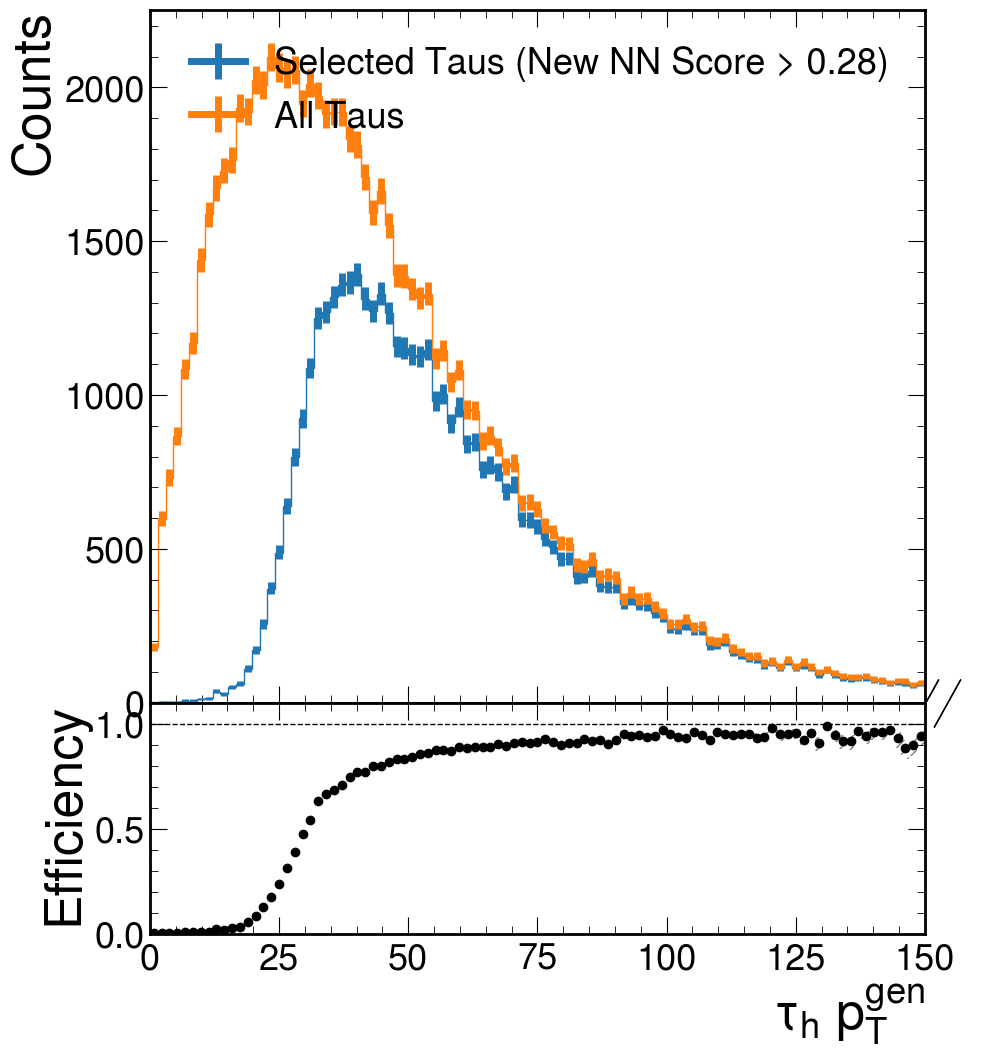

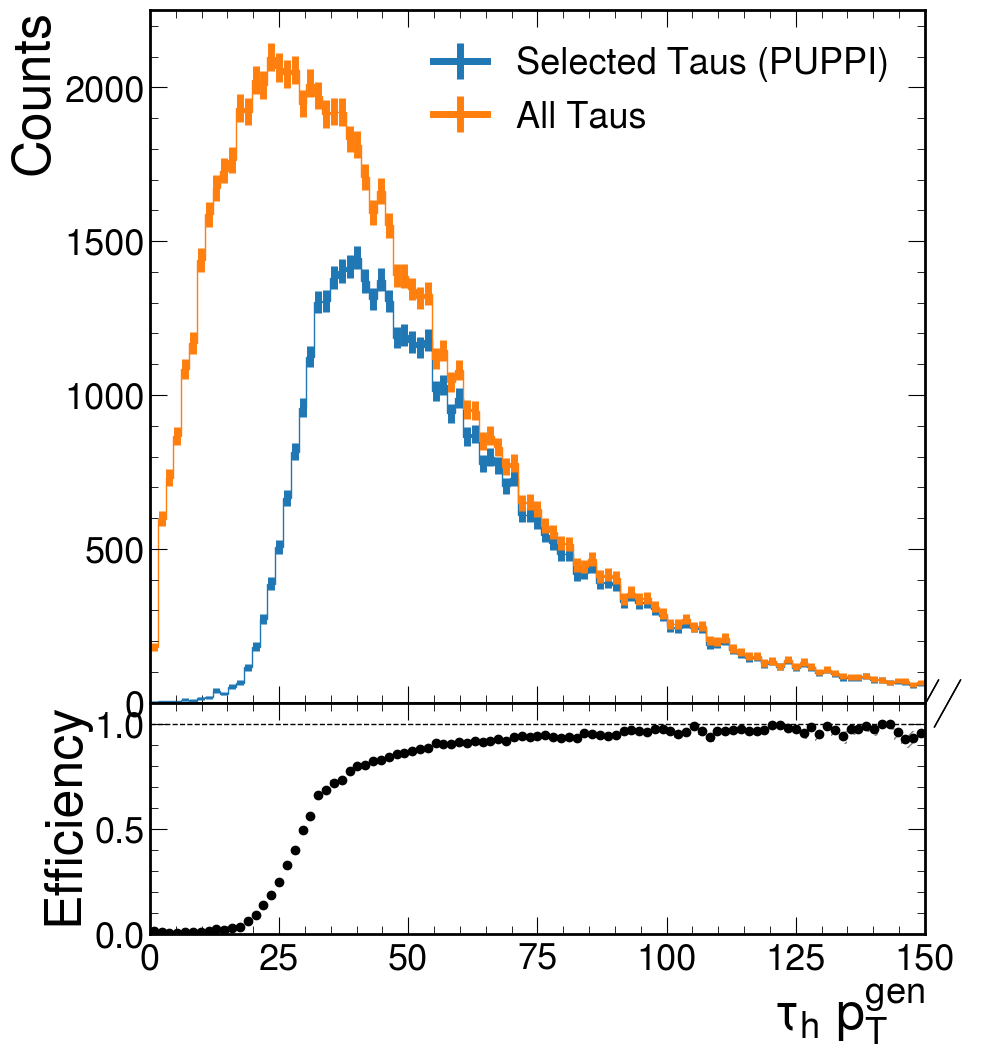

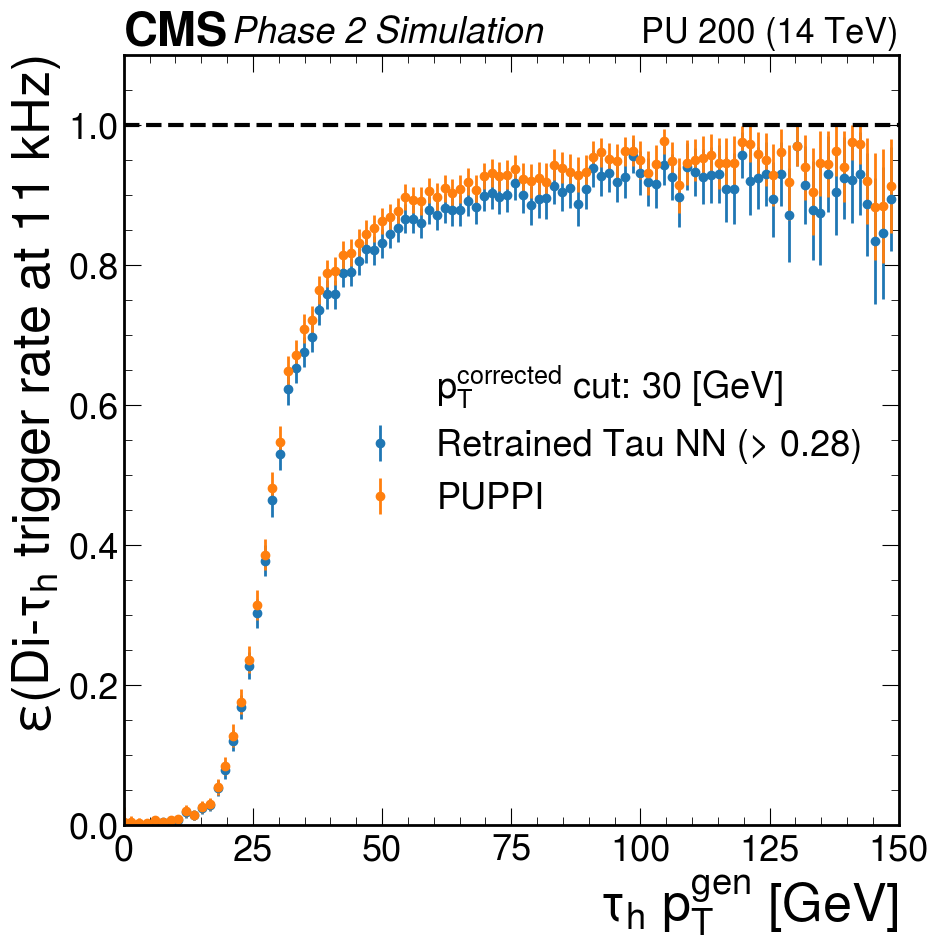

[1.         0.5177983  0.24918539 0.08239214 0.23066341 0.15647885
 0.05449887 0.02988478 0.06451144 0.0390644  0.05816222 0.05734635
 0.09726529 0.13677014 0.19048516 0.26105434 0.32747661 0.43014593
 0.5246693  0.62073913 0.71327633 0.80959156 0.83783834 0.86854628
 0.88885608 0.91009737 0.92340912 0.93123169 0.93676527 0.9526111
 0.96224052 0.96037048 0.96352382 0.96969293 0.9685782  0.9691402
 0.97906188 0.98256565 0.98634127 0.98174906 0.97795409 0.98526373
 0.99583371 0.99186264 0.9901868  0.99233091 0.98665567 0.99105065
 0.99283353 0.9944178  0.99193335 0.99787703 0.99541896 0.9818565
 0.99734345 0.98942597 1.         0.98571849 0.99426126 0.99419077
 0.99299933 0.99670583 0.98948612 1.         0.99618205 0.99583853
 1.         0.9952899  0.99557761 1.         0.99519532 1.
 1.         0.98845033 1.         0.99242102 1.         0.99184982
 1.         1.         1.         1.         1.         1.
 1.         0.97459075 0.98631808 1.         1.         1.
 1.         1.        

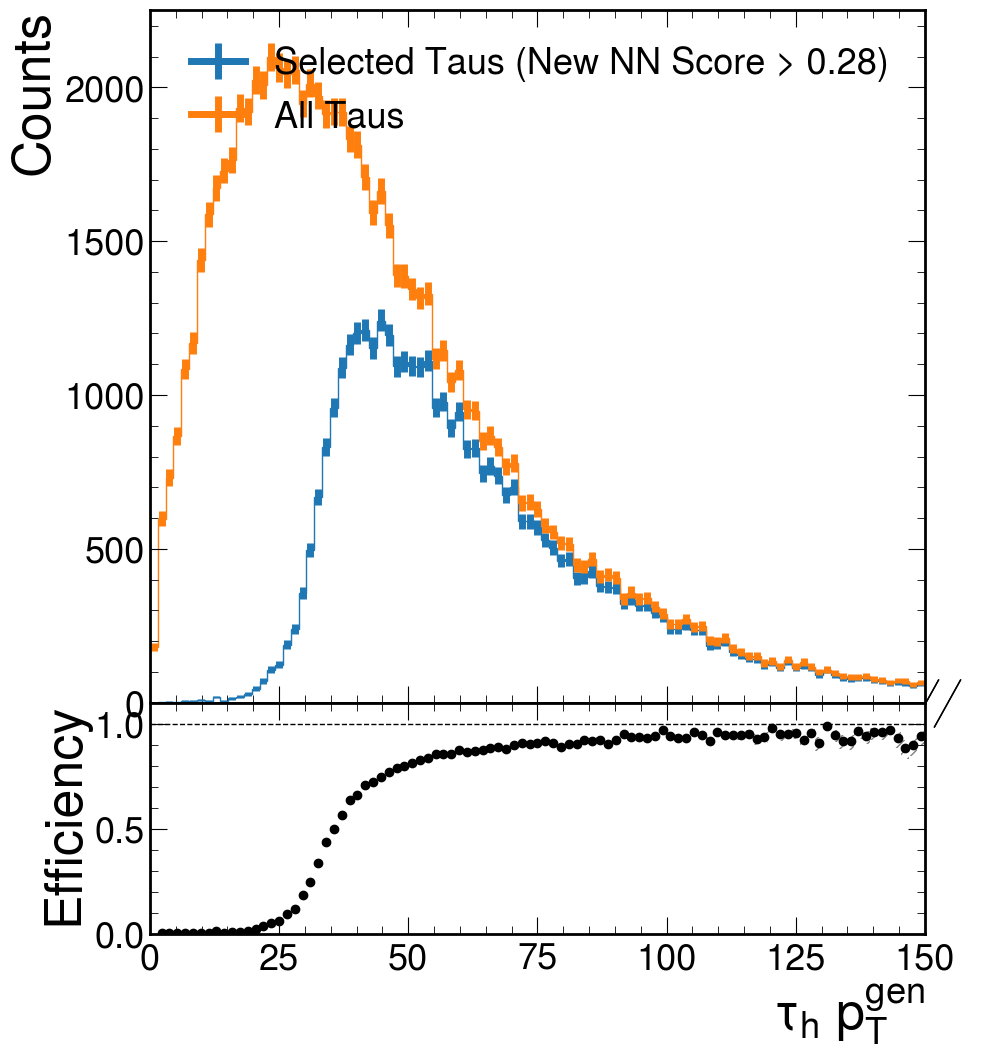

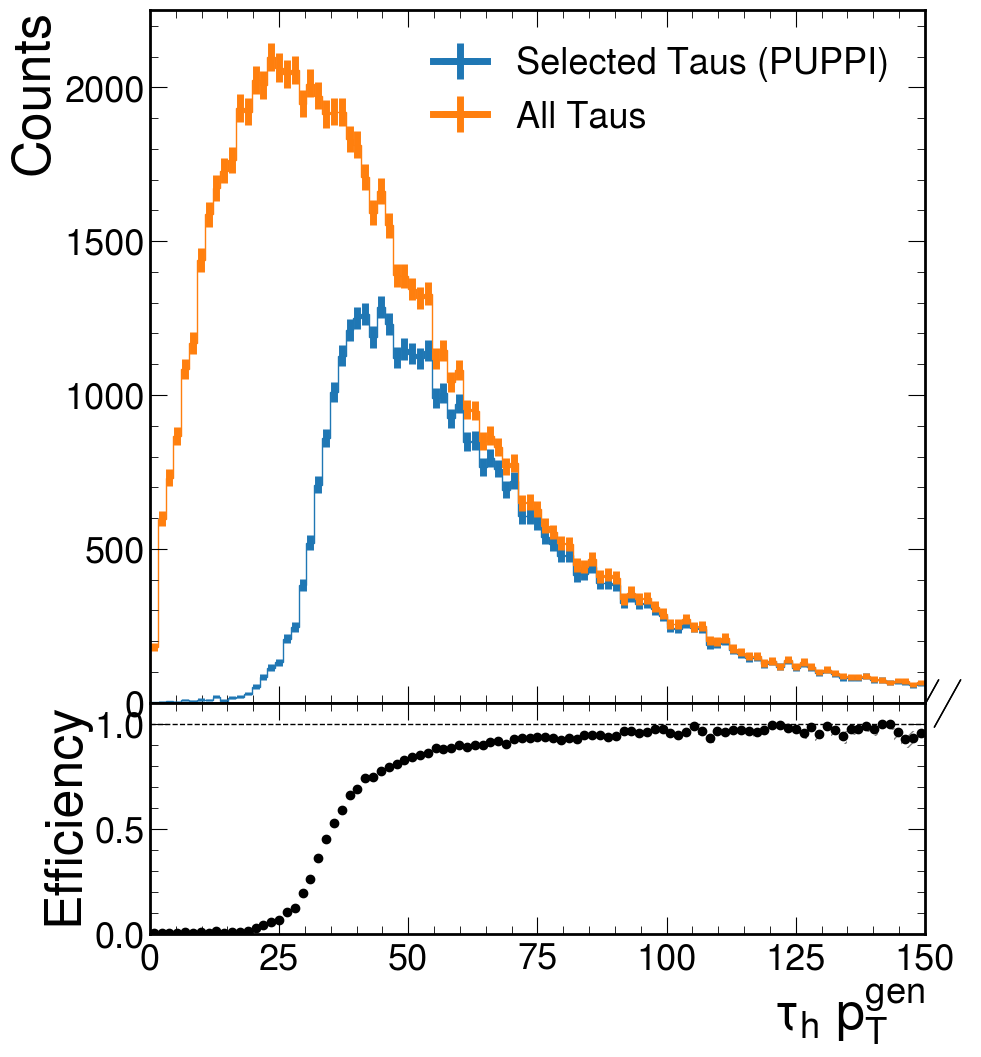

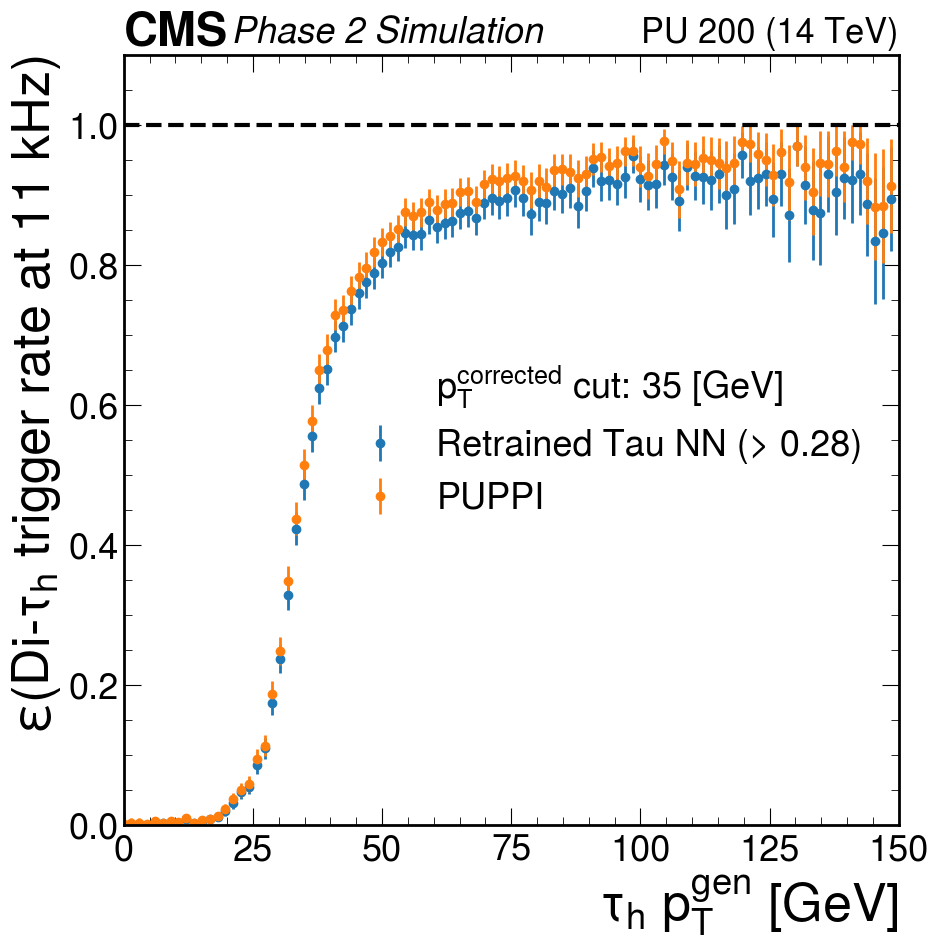

[0.         0.1262619  0.24918539 0.02009324 0.18896319 0.10056915
 0.0332046  0.01049545 0.02962552 0.00621352 0.01393856 0.01580616
 0.02110734 0.03333074 0.04883263 0.07158053 0.07843338 0.12195271
 0.15179031 0.23326628 0.3193539  0.42698705 0.54275198 0.6265377
 0.70885378 0.7723274  0.79292264 0.85695105 0.84588505 0.88846177
 0.90661172 0.90464939 0.92545858 0.93683015 0.93817751 0.93928952
 0.95611713 0.9570184  0.96817719 0.96570181 0.9584397  0.9620268
 0.9792059  0.98779955 0.97481751 0.97550912 0.974841   0.98213045
 0.98568407 0.98884655 0.98189381 0.99363611 0.98171451 0.97734052
 0.98939006 0.98153473 0.99746589 0.98571849 0.99139649 0.99129265
 0.99299933 0.99014149 0.9790688  0.99650123 0.99618205 0.99583853
 0.9906106  0.99059704 0.99557761 1.         0.99519532 0.99393194
 1.         0.98273697 1.         0.98491156 1.         0.98375692
 1.         1.         1.         1.         1.         1.
 1.         0.97459075 0.98631808 1.         1.         1.
 1.         1

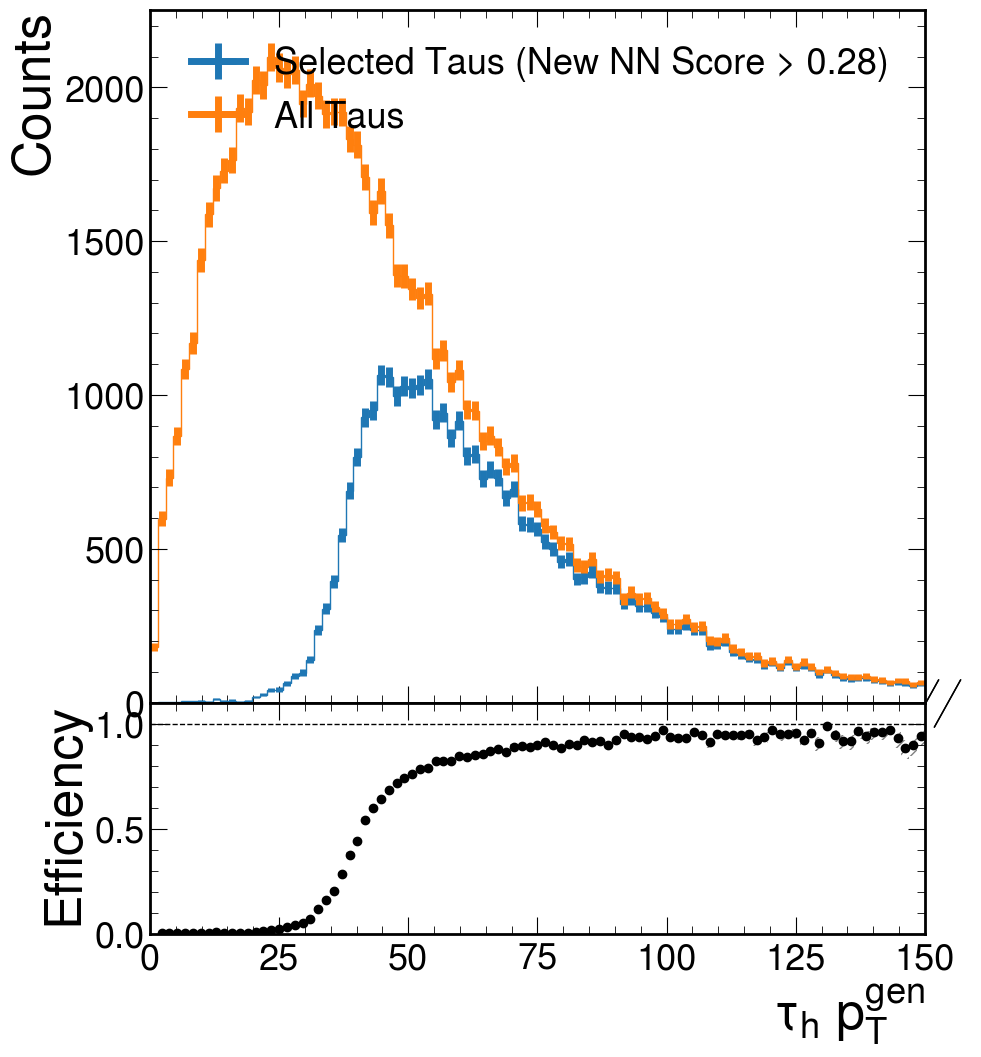

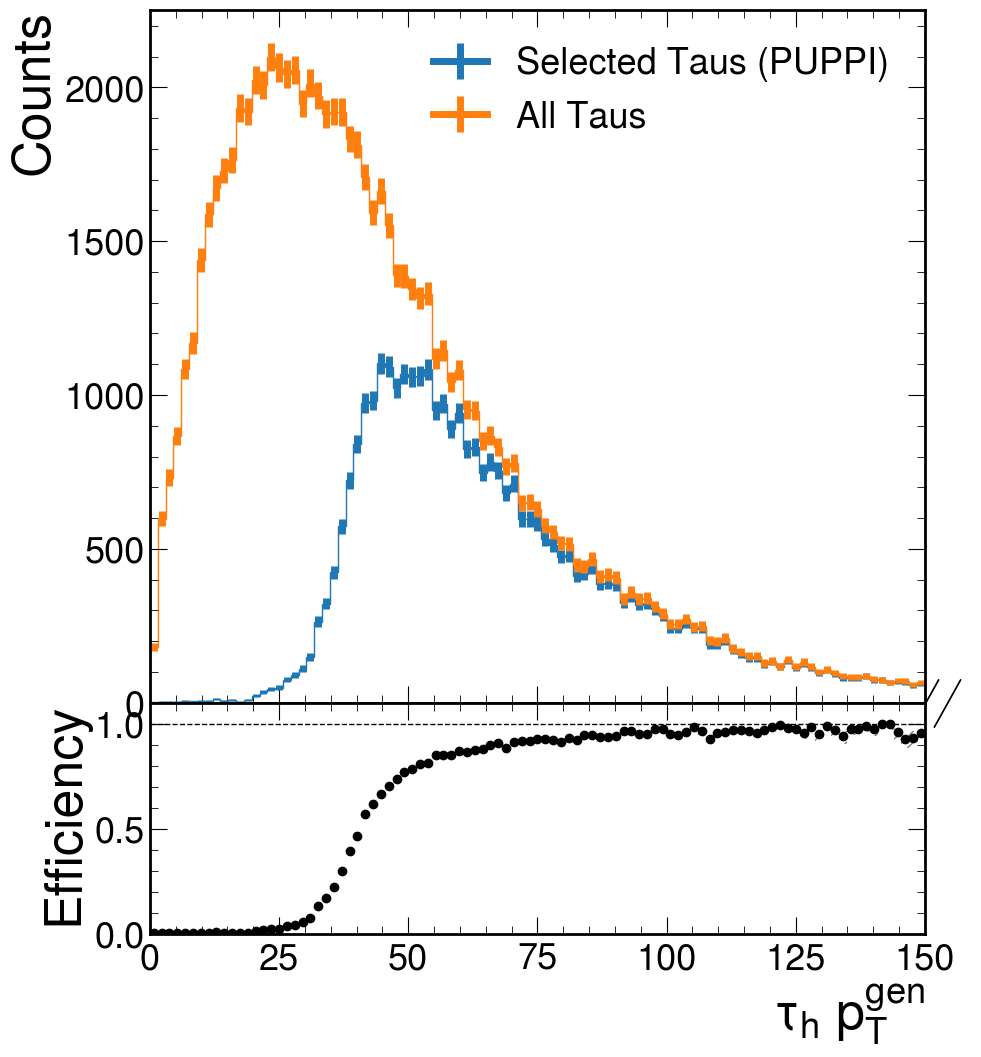

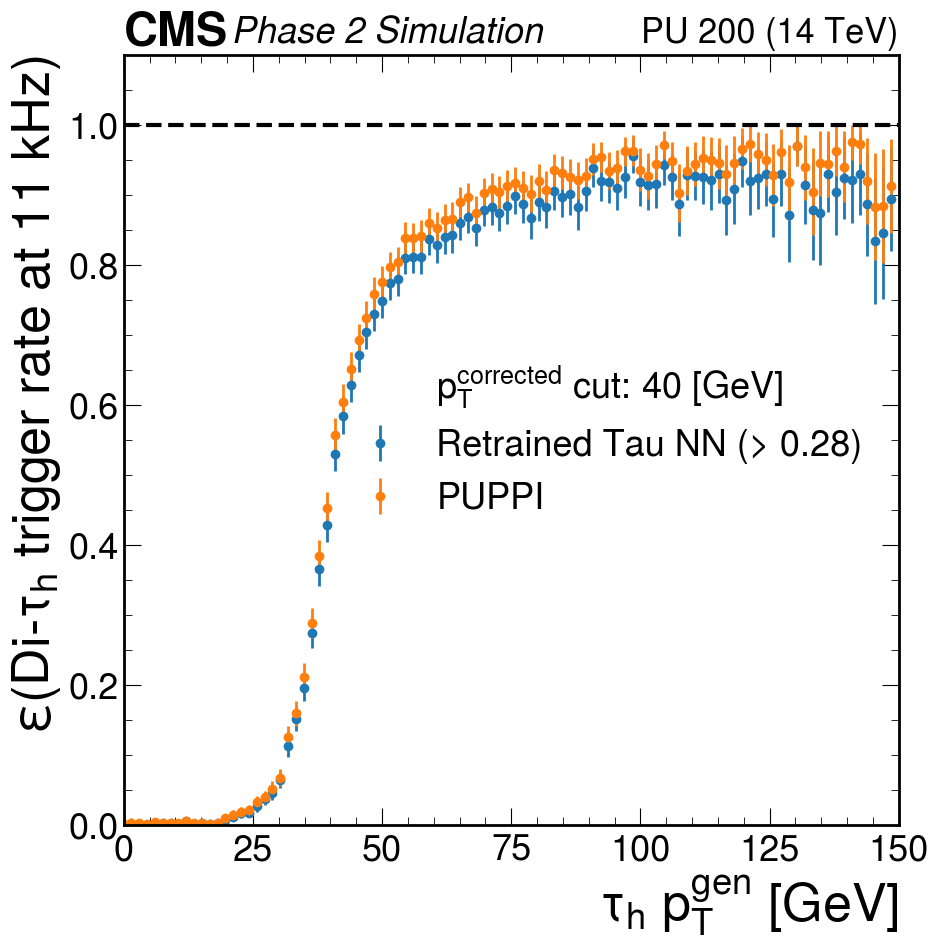

[0.         0.1262619  0.06076659 0.02009324 0.10884552 0.07384093
 0.01802337 0.00396318 0.01660287 0.00487483 0.00597548 0.00147118
 0.00349668 0.01199429 0.01656698 0.02492996 0.02488031 0.03848341
 0.05202596 0.06081475 0.08615661 0.14537888 0.19446356 0.25186803
 0.34917654 0.45139191 0.52142213 0.6515151  0.69393931 0.75867691
 0.80062451 0.82194908 0.85655395 0.87227937 0.88742625 0.88597689
 0.91562231 0.92140169 0.93085865 0.93480003 0.92928605 0.93888683
 0.95573955 0.97158123 0.96506588 0.95874784 0.96453449 0.96791096
 0.96787605 0.97773401 0.97189634 0.98306111 0.97488221 0.97734052
 0.98410052 0.98153473 0.99240571 0.97720145 0.98853463 0.99129265
 0.99299933 0.99014149 0.97561447 0.98952651 0.99618205 0.99583853
 0.98594472 0.99059704 0.99557761 1.         0.99519532 0.98788511
 0.98765185 0.98273697 1.         0.98491156 1.         0.97571463
 1.         0.99051765 1.         1.         1.         1.
 1.         0.97459075 0.98631808 1.         1.         1.
 1.        

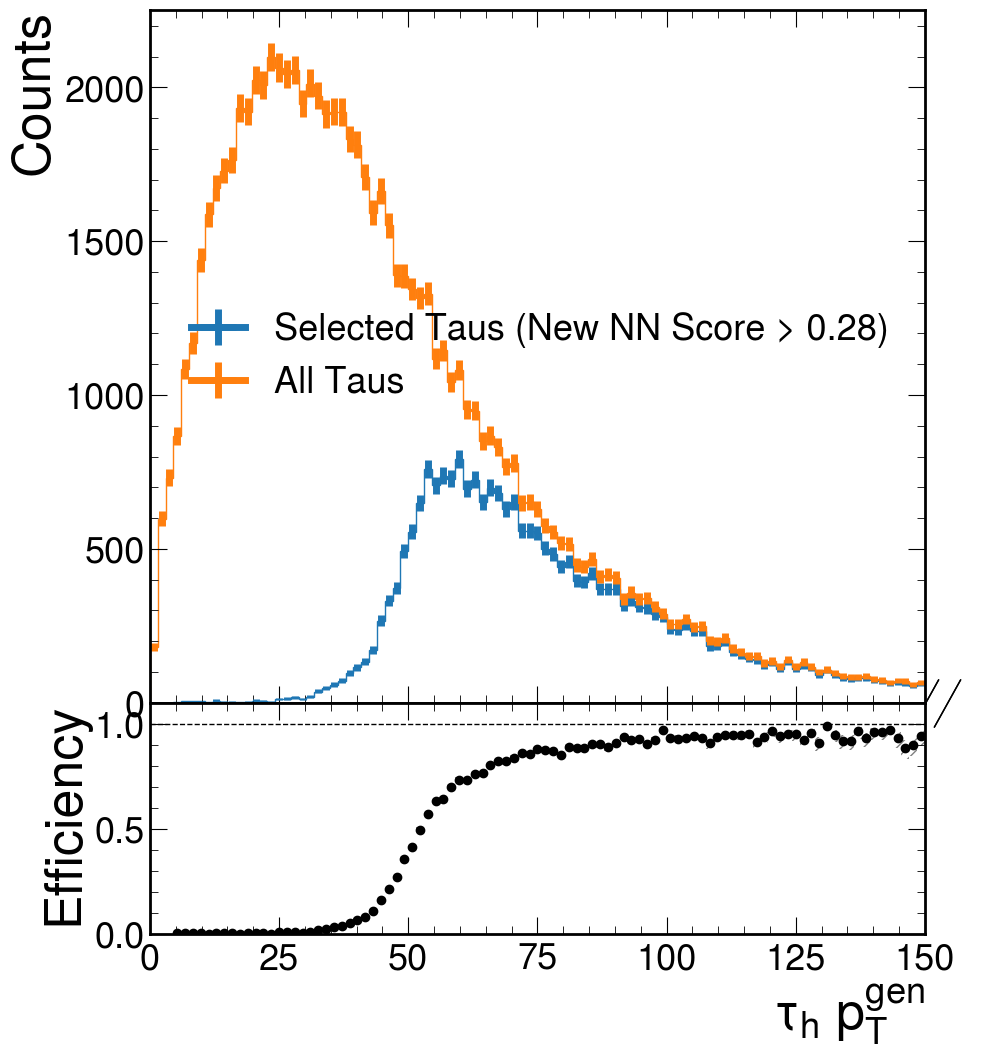

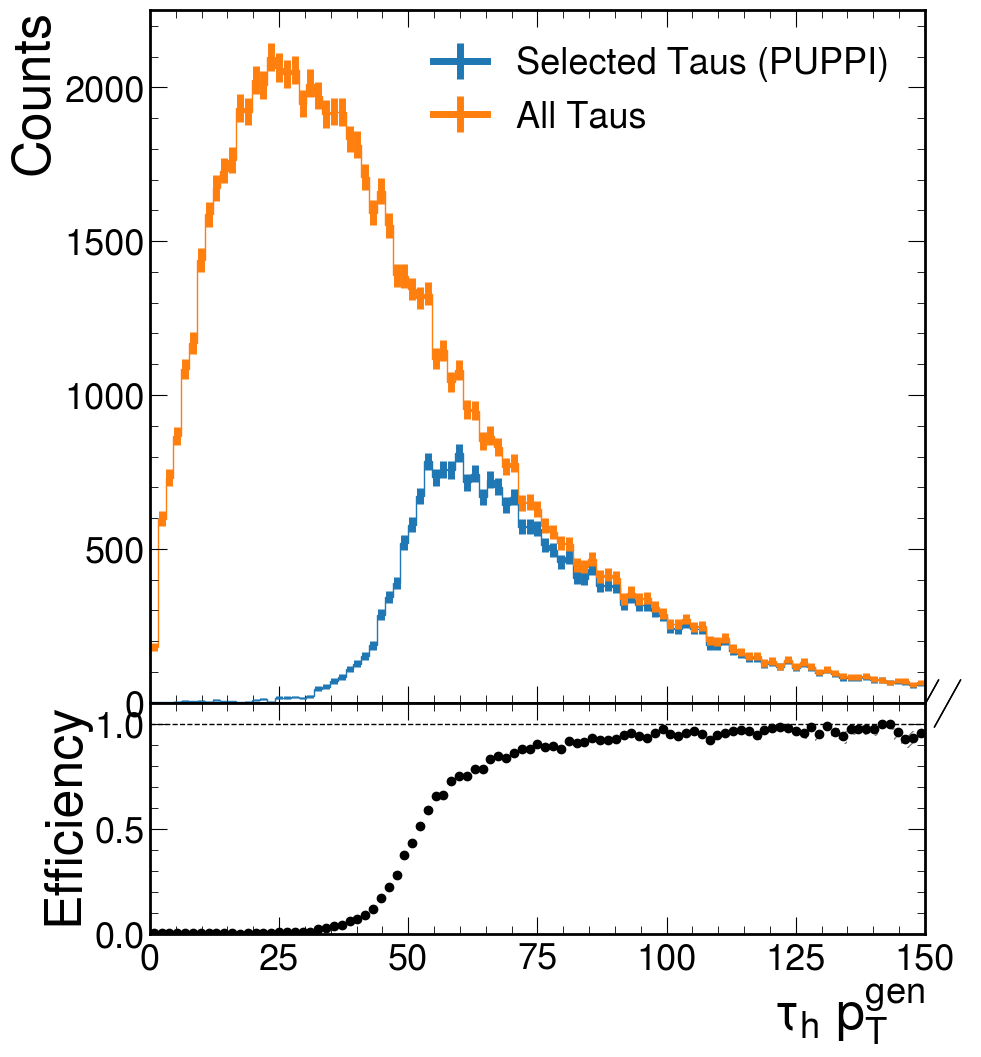

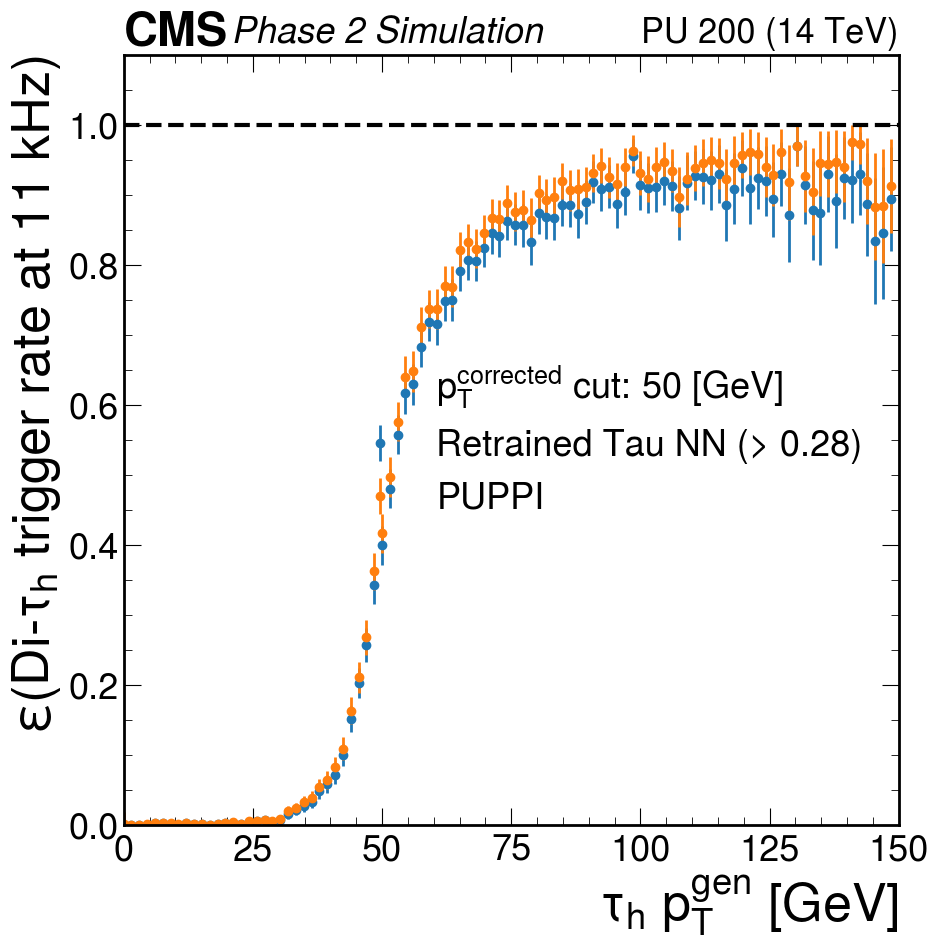

[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00932375e-02
 1.08845517e-01 7.38409309e-02 1.32335711e-02 5.00609698e-04
 9.48296009e-03 2.34633229e-03 1.84859034e-03 1.85840687e-04
 6.83853574e-04 3.83963110e-03 2.86296513e-03 5.23228902e-04
 6.00453377e-03 6.58891424e-03 8.74593895e-03 5.32872164e-03
 9.84805103e-03 1.98223912e-02 2.69939233e-02 3.44412776e-02
 4.17144580e-02 5.90556712e-02 7.03199002e-02 8.76470553e-02
 1.18329500e-01 1.82903015e-01 2.42240225e-01 2.99234576e-01
 4.01469957e-01 4.65887764e-01 5.50763470e-01 6.33556918e-01
 6.97039741e-01 7.14056529e-01 7.84072202e-01 8.02871355e-01
 8.02910031e-01 8.37416218e-01 8.50401593e-01 8.93790138e-01
 8.95909167e-01 9.05736582e-01 9.04618481e-01 9.27318812e-01
 9.30727147e-01 9.53774717e-01 9.28291055e-01 9.49440860e-01
 9.36376329e-01 9.59343966e-01 9.68286756e-01 9.39879326e-01
 9.79798316e-01 9.60263687e-01 9.77114770e-01 9.73984363e-01
 9.72268571e-01 9.77096465e-01 9.68729672e-01 9.65316823e-01
 9.73495074e-01 9.958385

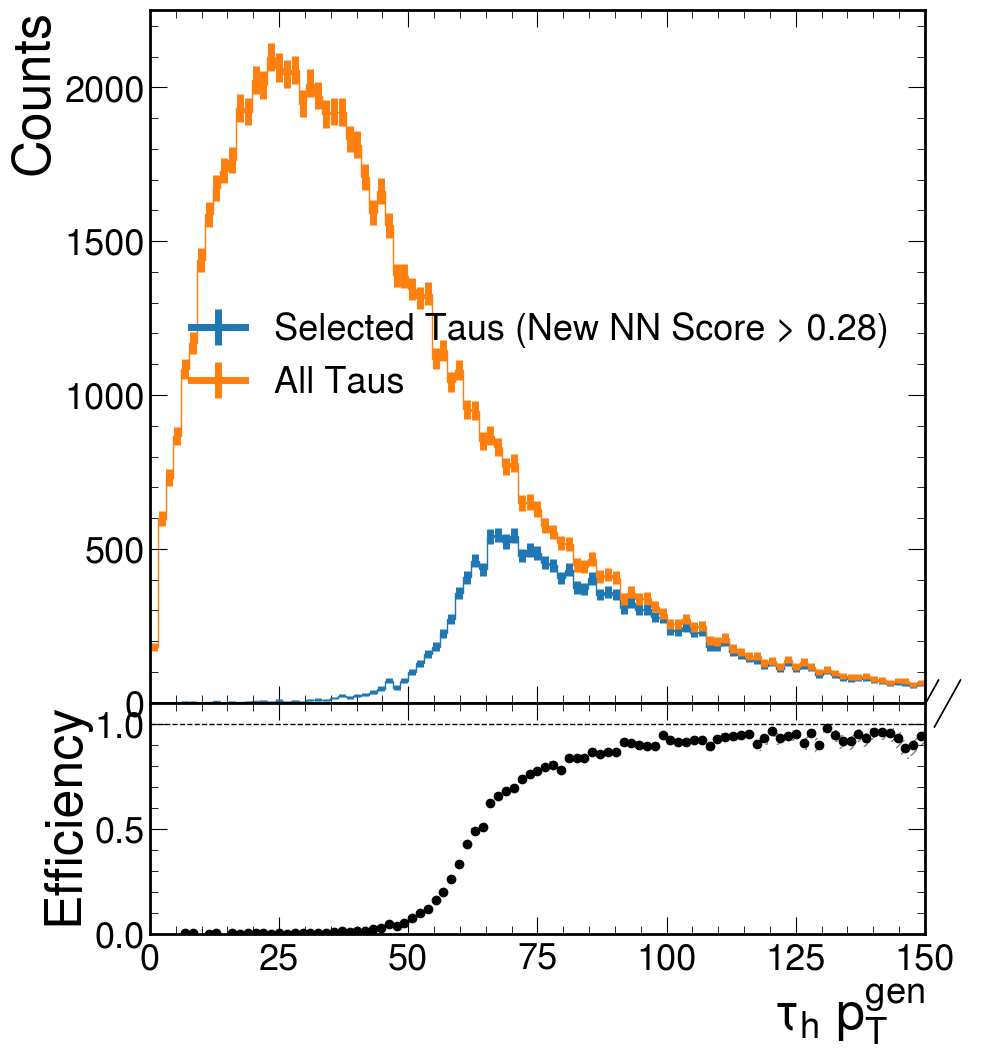

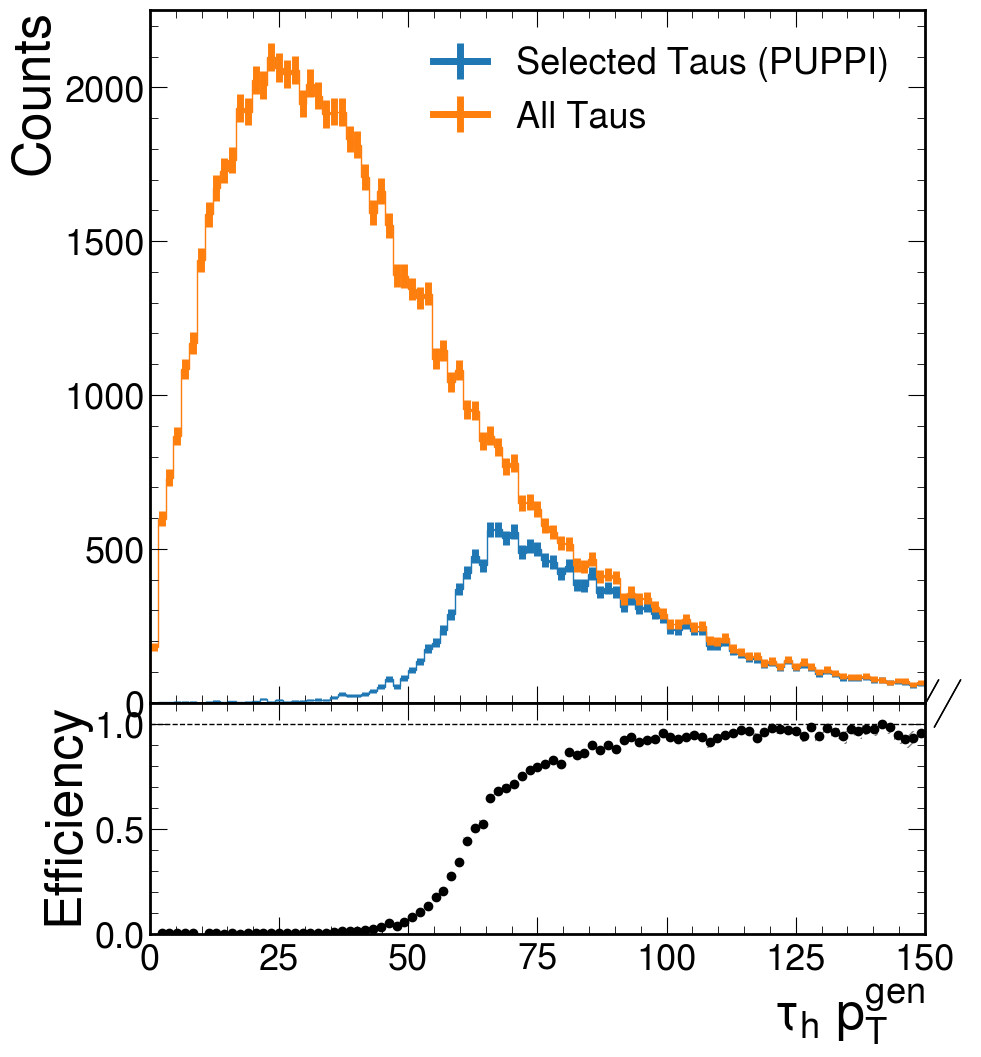

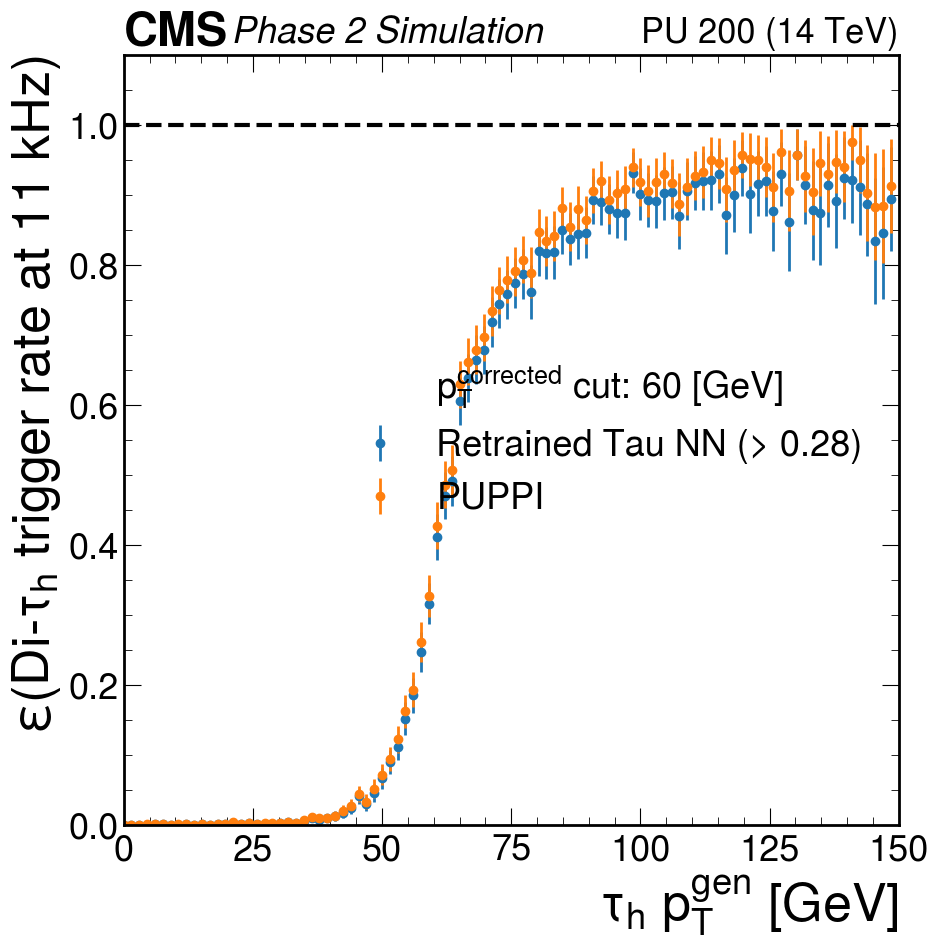

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 4.47530891e-03 0.00000000e+00 1.84859034e-03 1.85840687e-04
 6.83853574e-04 1.81210651e-03 2.86296513e-03 5.23228902e-04
 3.08988428e-03 4.93953397e-04 1.92211404e-03 9.41618452e-04
 4.06168214e-03 4.54583246e-03 3.51193912e-03 7.48610435e-03
 1.21434950e-02 8.73768623e-03 1.16753694e-02 1.50740772e-02
 2.03930517e-02 2.85454346e-02 4.83037907e-02 3.45953917e-02
 5.31775744e-02 7.76004797e-02 1.02210392e-01 1.25844996e-01
 1.71427440e-01 2.09583418e-01 2.83457735e-01 3.52710361e-01
 4.60980548e-01 5.26088714e-01 5.57169310e-01 6.83631239e-01
 7.09183513e-01 7.47170055e-01 7.44786928e-01 7.88225180e-01
 8.24106117e-01 8.37394973e-01 8.38432867e-01 8.72605083e-01
 8.55717743e-01 8.99217674e-01 9.10858798e-01 8.85971579e-01
 9.39789771e-01 9.07259366e-01 9.45906556e-01 9.25519519e-01
 9.45072456e-01 9.57699184e-01 9.34687419e-01 9.51598239e-01
 9.39986757e-01 9.714111

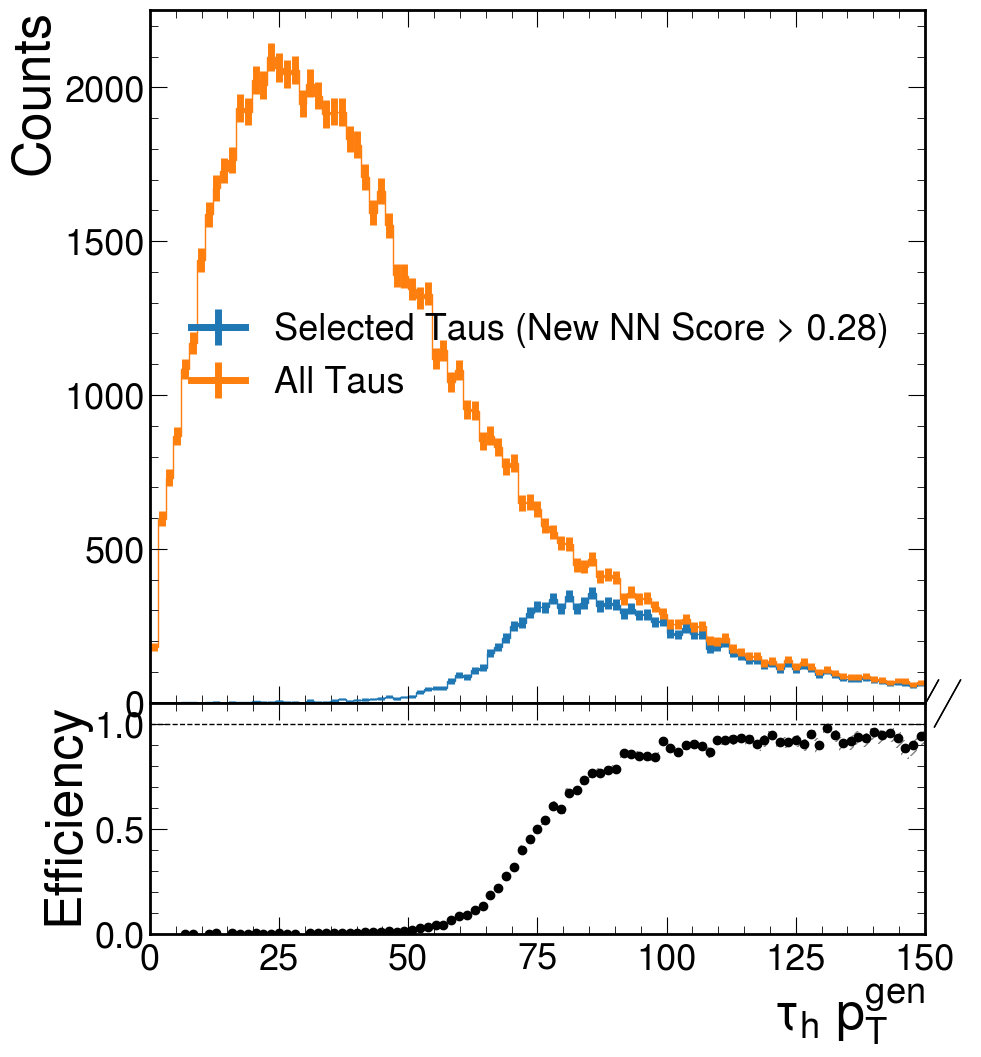

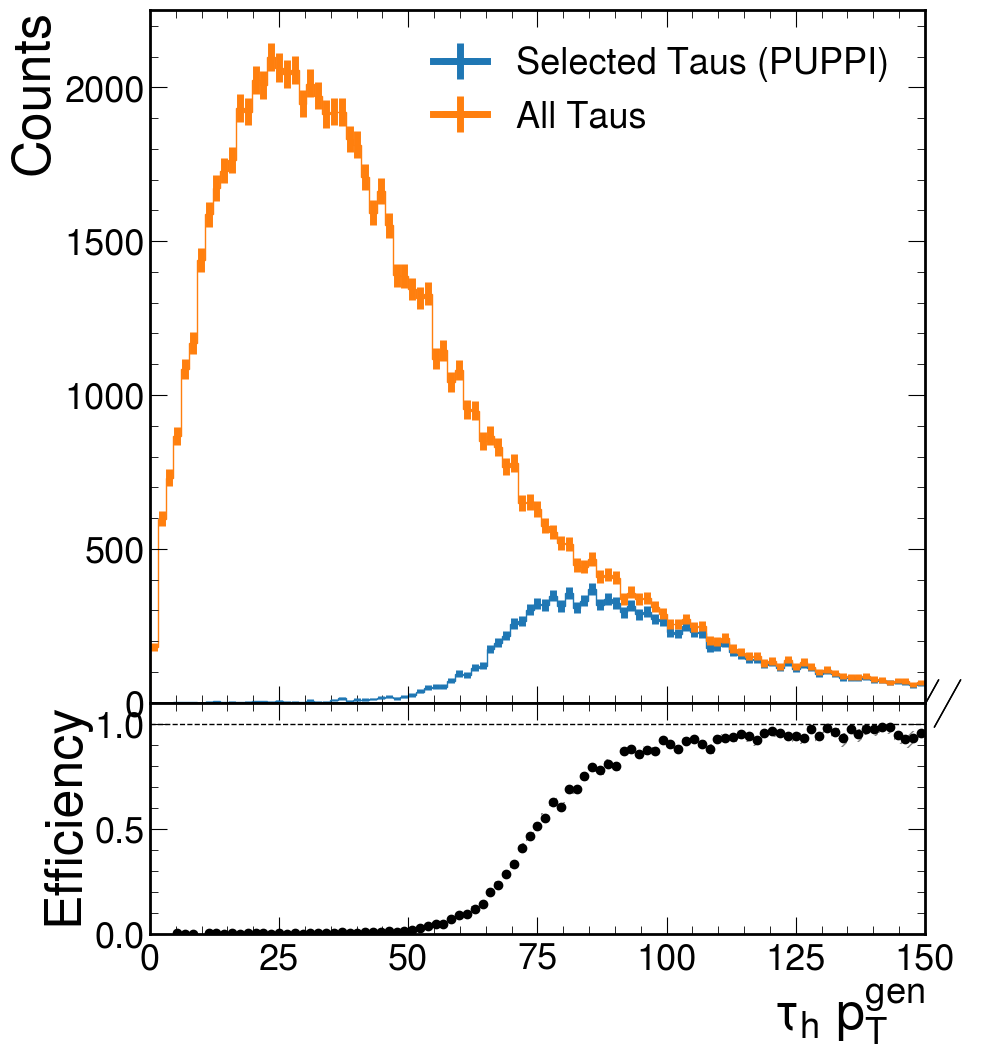

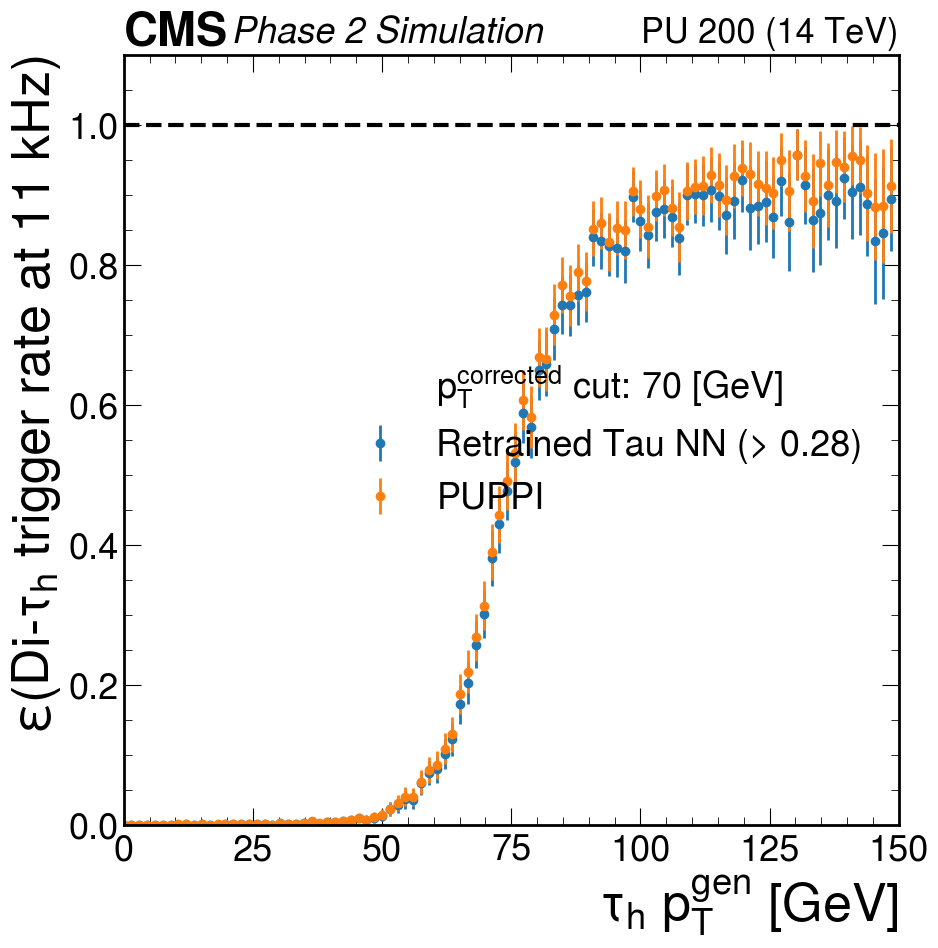

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 2.93362799e-03 0.00000000e+00 9.57377801e-04 1.85840687e-04
 1.66798111e-04 1.81210651e-03 5.59923027e-04 5.23228902e-04
 1.98602889e-03 4.93953397e-04 4.79147060e-04 0.00000000e+00
 2.96292056e-03 4.66937325e-04 4.75215308e-04 2.96015654e-03
 5.14746584e-03 1.92018917e-03 4.07476187e-03 4.95940765e-03
 5.77634986e-03 7.48791036e-03 1.13132150e-02 7.93818117e-03
 1.17034074e-02 1.43062717e-02 2.54426656e-02 3.12716216e-02
 4.07306476e-02 3.99314967e-02 6.80931025e-02 8.25923305e-02
 8.85668661e-02 1.12318293e-01 1.38586848e-01 1.94480879e-01
 2.24846761e-01 2.89517803e-01 3.30765749e-01 4.17978274e-01
 4.75181347e-01 5.26246720e-01 5.61227228e-01 6.52494000e-01
 6.39907353e-01 7.13541338e-01 7.34198956e-01 7.67211547e-01
 8.21736646e-01 8.05791711e-01 8.47967582e-01 8.32996109e-01
 8.88318607e-01 8.97202472e-01 8.77809921e-01 8.97332807e-01
 8.81409733e-01 9.358067

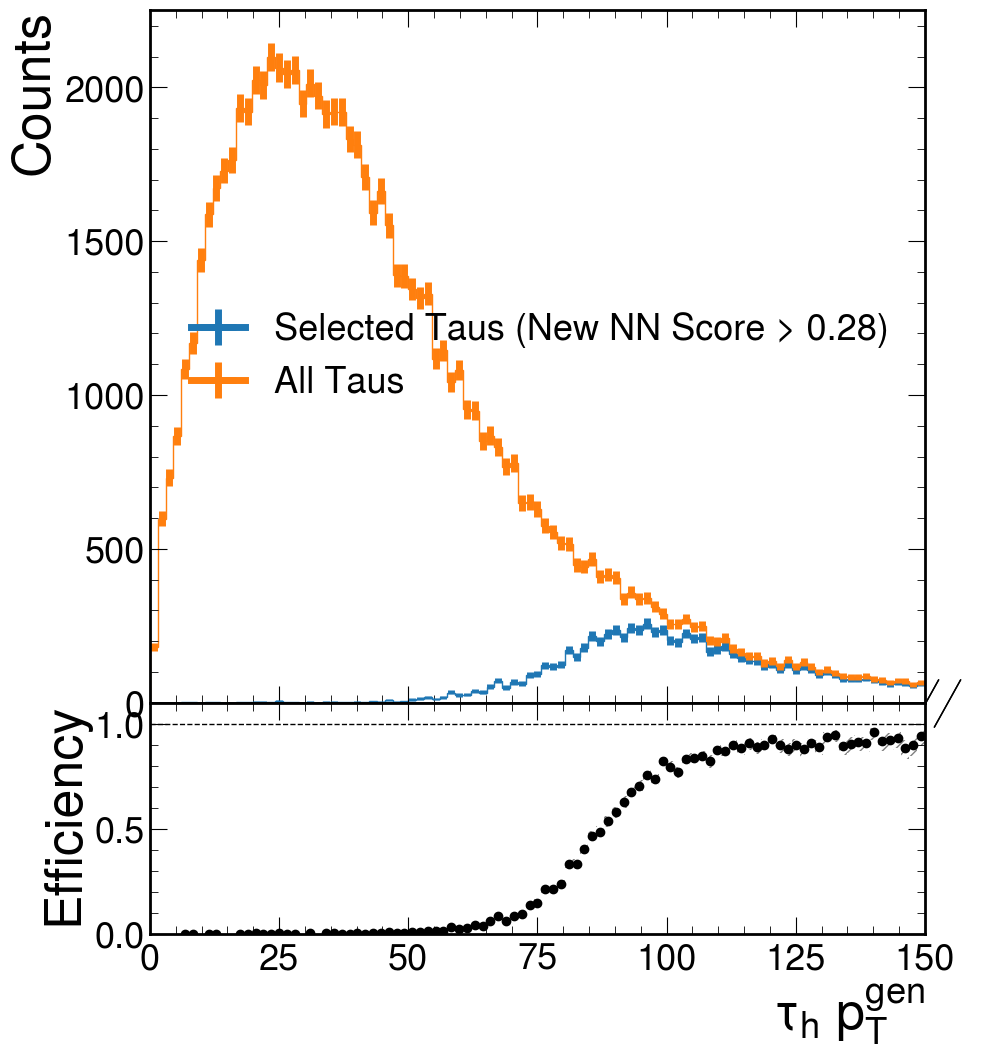

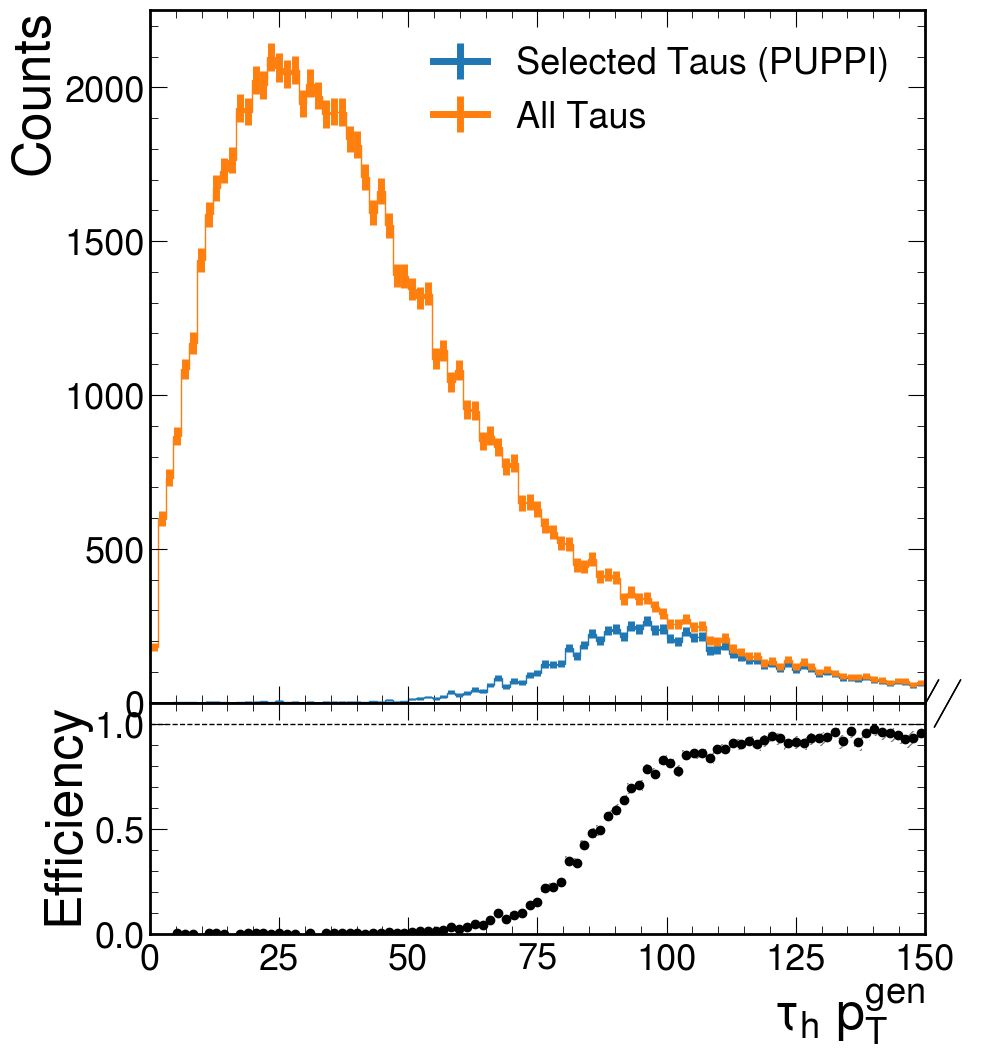

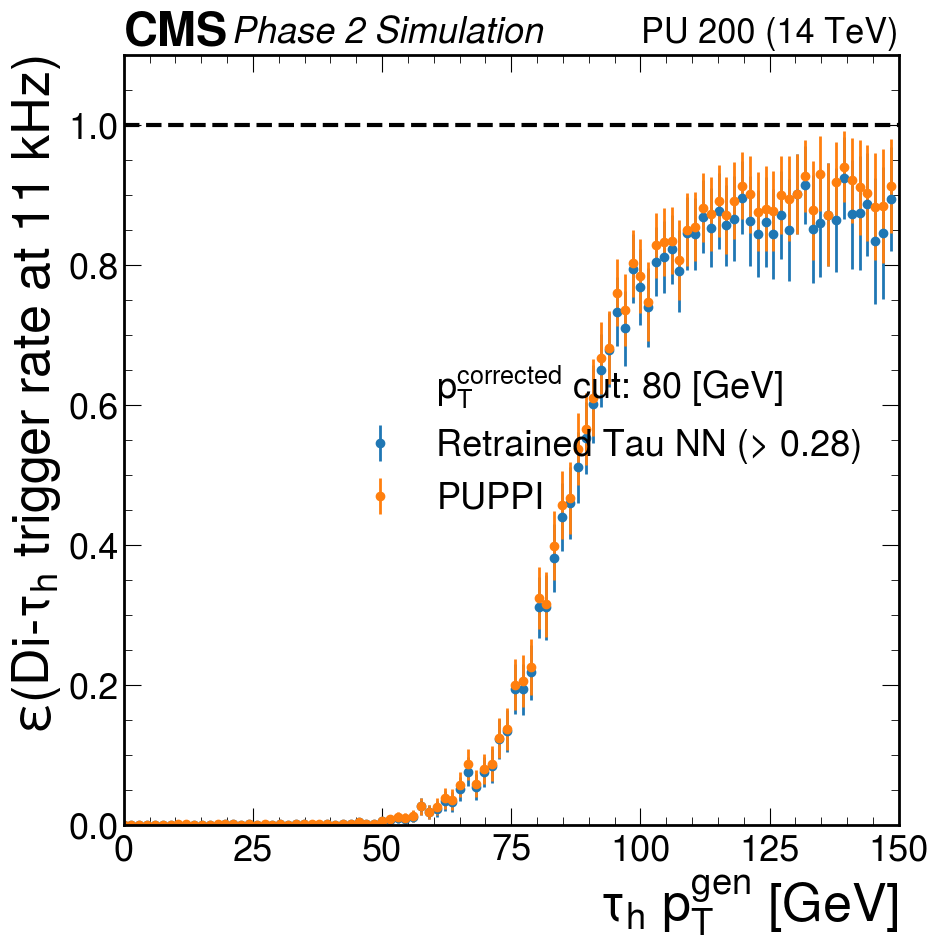

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 3.70566036e-04 0.00000000e+00 0.00000000e+00 1.85840687e-04
 1.66798111e-04 1.18787877e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 1.20480614e-04 1.16869265e-04 0.00000000e+00
 9.16646781e-04 0.00000000e+00 4.75215308e-04 4.74283324e-04
 1.14899165e-04 1.16747572e-04 4.76240735e-04 1.24241155e-04
 1.55698532e-03 9.93042189e-04 4.66548746e-03 5.94947929e-04
 1.76769532e-03 5.98848983e-03 8.24384243e-03 1.10667176e-02
 8.69127193e-03 1.28257777e-02 3.00951713e-02 1.98154252e-02
 2.47140403e-02 3.76770090e-02 3.64782408e-02 5.73357854e-02
 8.41940321e-02 6.05124417e-02 8.33107227e-02 9.20793646e-02
 1.36036909e-01 1.47803177e-01 2.09450731e-01 2.14624280e-01
 2.45145677e-01 3.41123808e-01 3.45860417e-01 4.12585909e-01
 4.86269663e-01 4.98331381e-01 5.71970834e-01 6.05337489e-01
 6.36214314e-01 6.98842379e-01 7.20892859e-01 7.97336974e-01
 7.62986386e-01 8.285947

In [10]:
results = plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_nn = gen_pT_list


1905/1905 [==============================] - 2s 884us/step


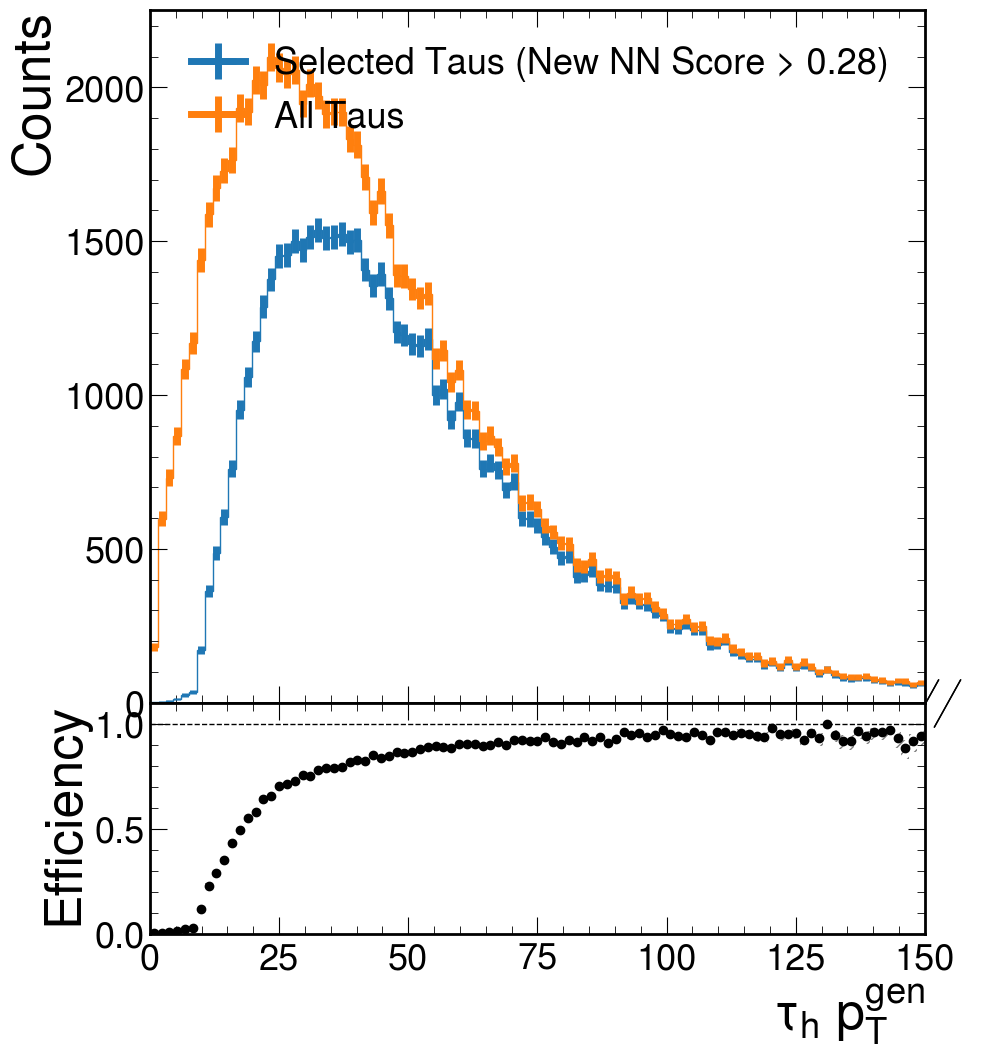

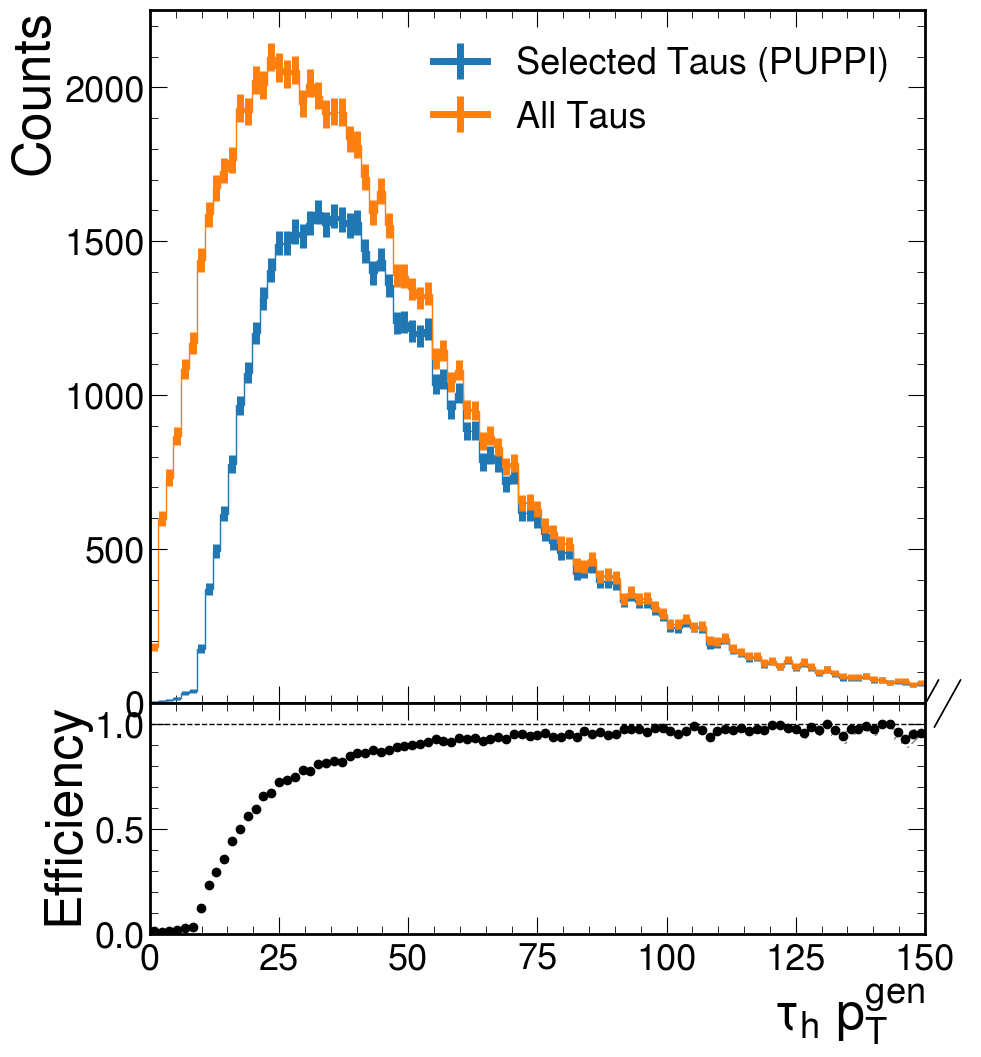

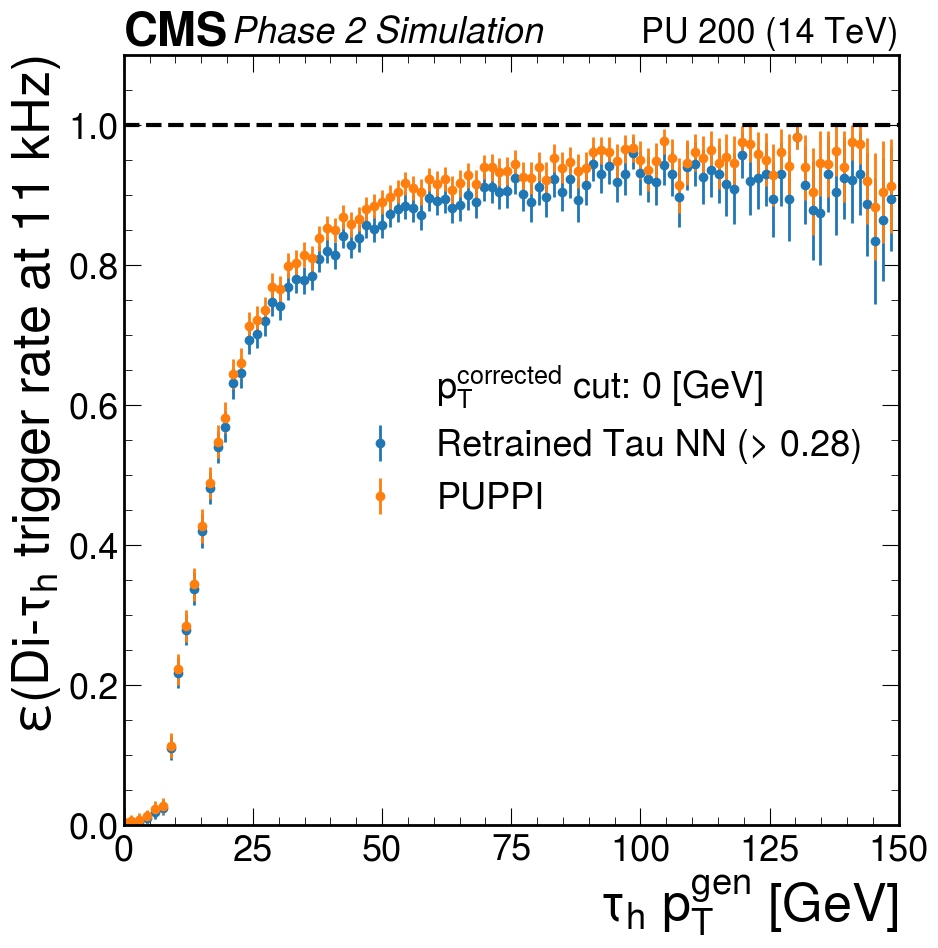

1743/1743 [==============================] - 2s 1ms/step


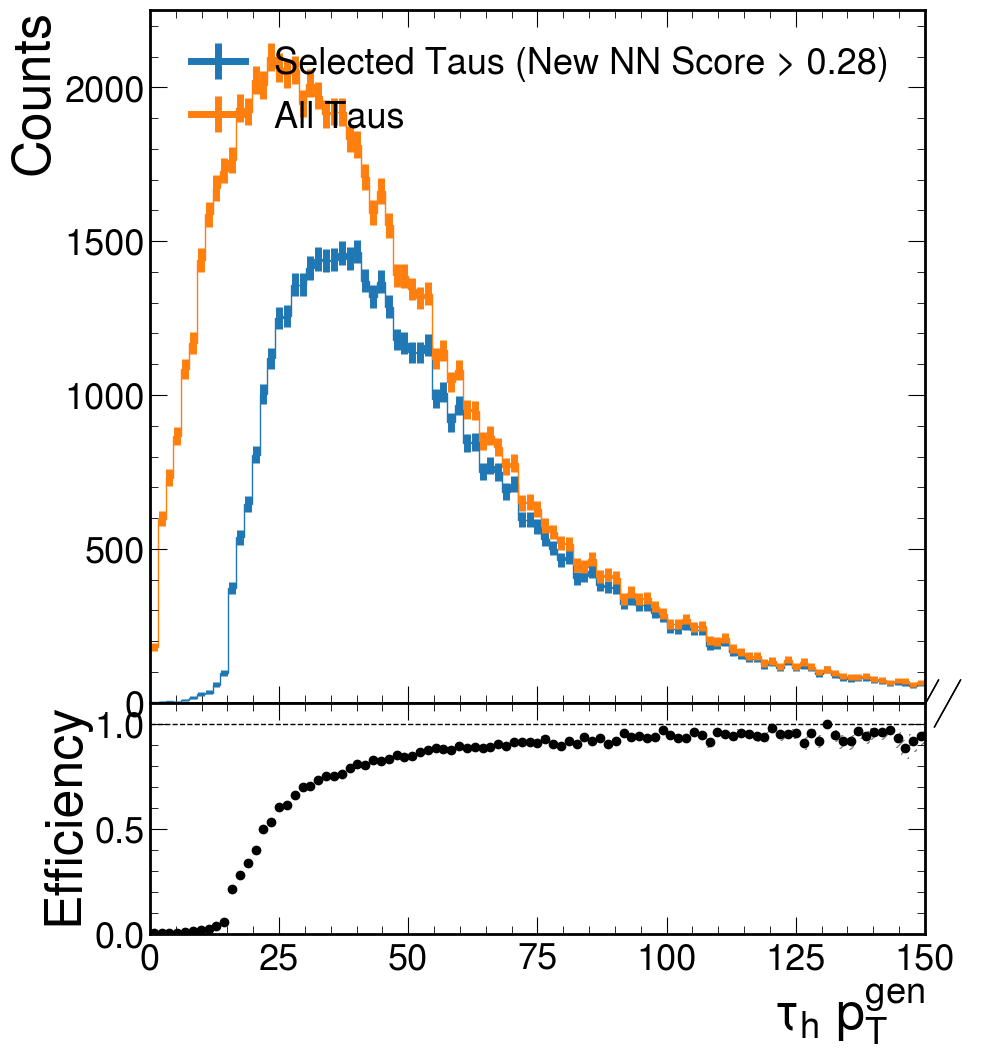

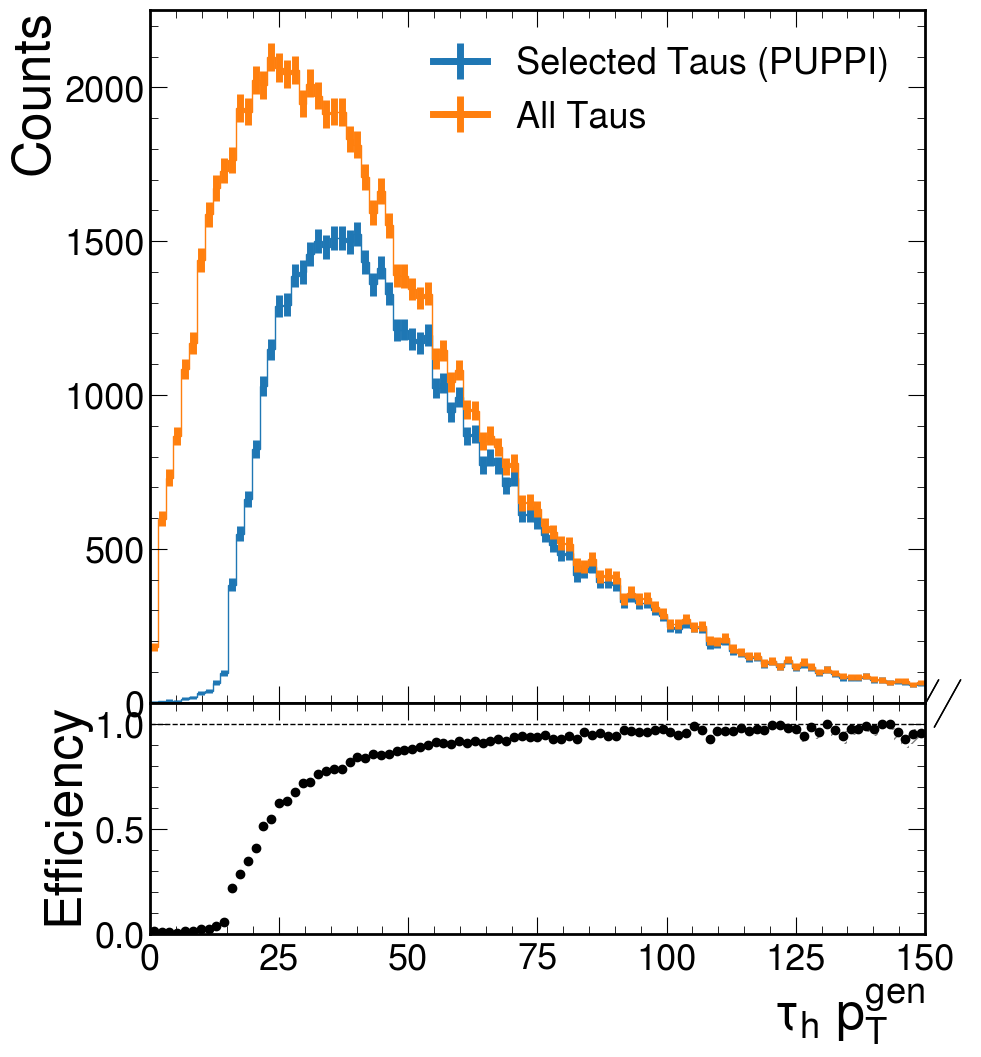

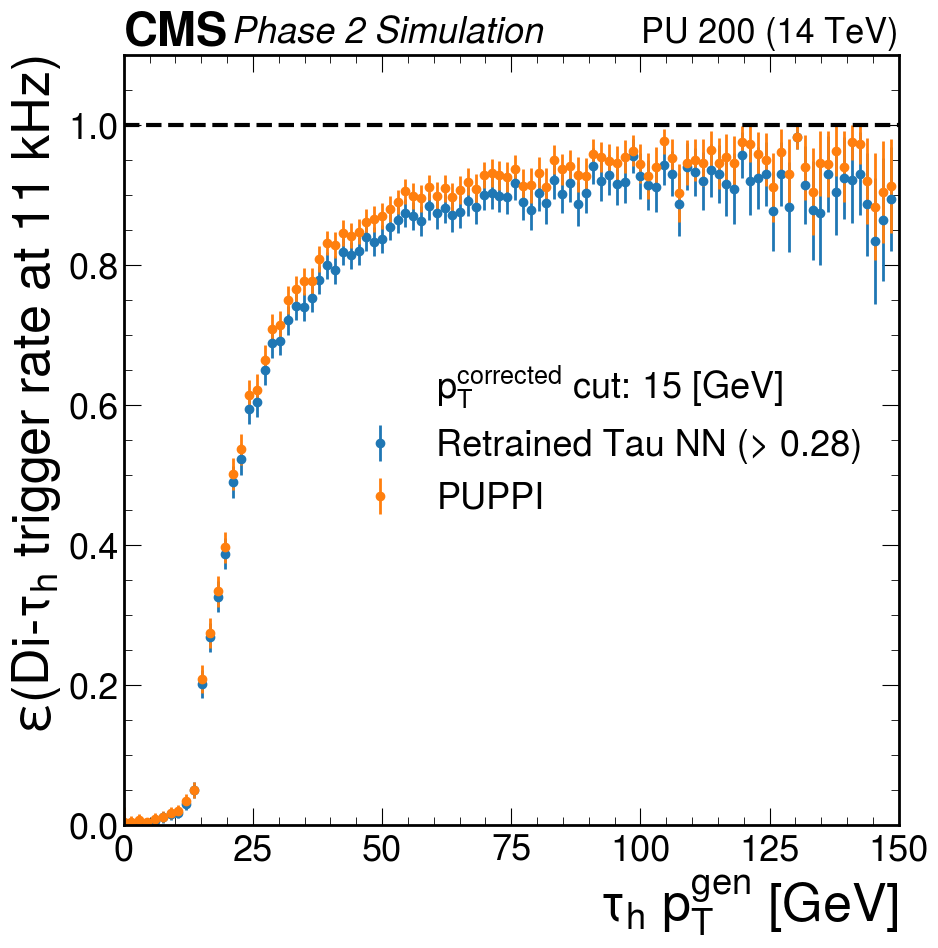

[1.         0.5177983  0.73418389 0.15910602 0.31622655 0.42671831
 0.13870902 0.07918877 0.1083452  0.14667606 0.48075465 0.55623416
 0.60345026 0.68065746 0.77565383 0.80942149 0.85714783 0.86091398
 0.90444505 0.92133143 0.93224309 0.93723179 0.95100642 0.95110827
 0.95950562 0.96287633 0.97396526 0.97362209 0.97252711 0.98146564
 0.97874334 0.97930024 0.97826957 0.9768138  0.98023251 0.98322902
 0.9874272  0.98768769 0.98975291 0.98710939 0.98039848 0.98526373
 0.98751263 0.98915351 0.9901868  0.99233091 0.98813545 0.99105065
 0.99462349 0.99070247 0.99193335 0.98728663 0.98855978 0.99091136
 0.98939006 0.99735037 0.99746589 0.99427322 0.99426126 0.98839861
 0.99649288 0.99014149 0.986004   0.99650123 0.98858055 0.99583853
 0.99529509 0.99059704 0.99116905 1.         1.         0.98788511
 1.         0.98845033 0.9929863  1.         1.         1.
 1.         1.         1.         1.         1.         0.98104266
 1.         0.98723305 1.         1.         1.         1.
 1.        

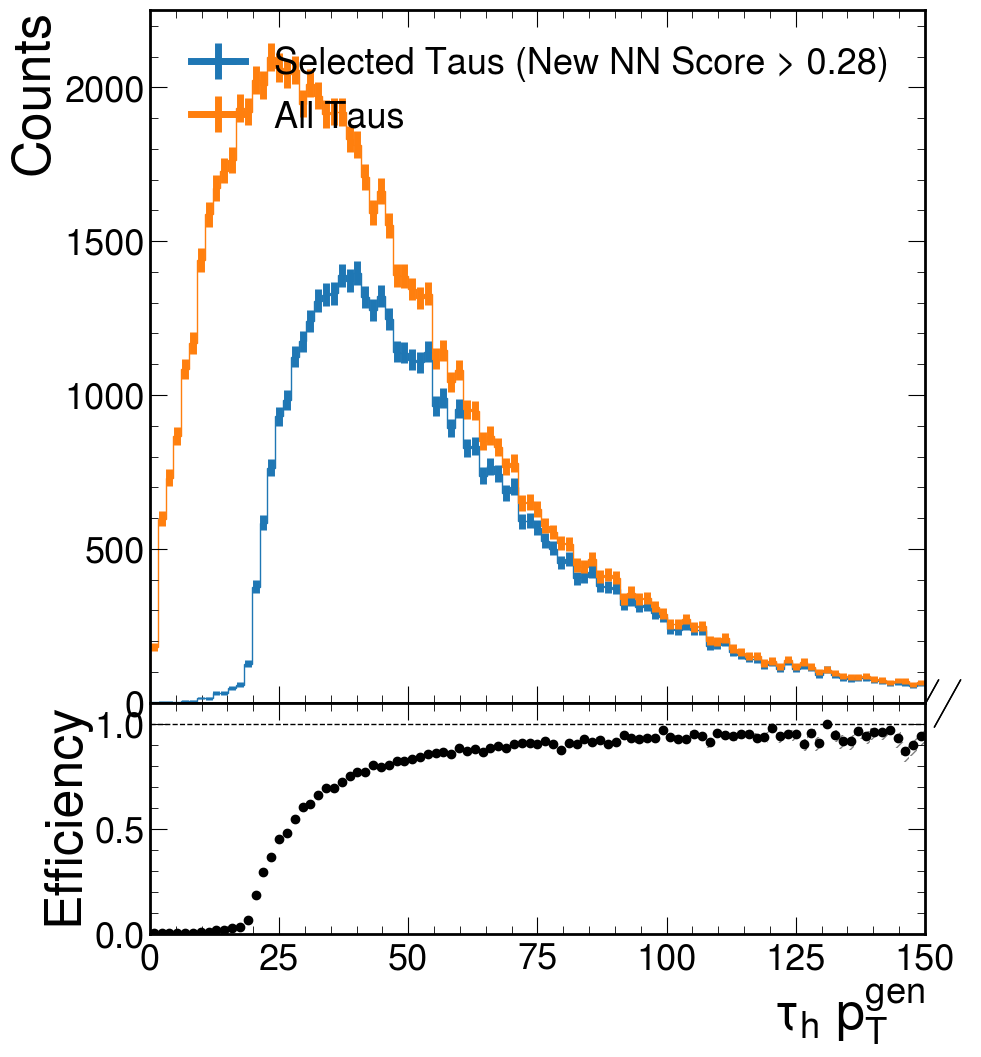

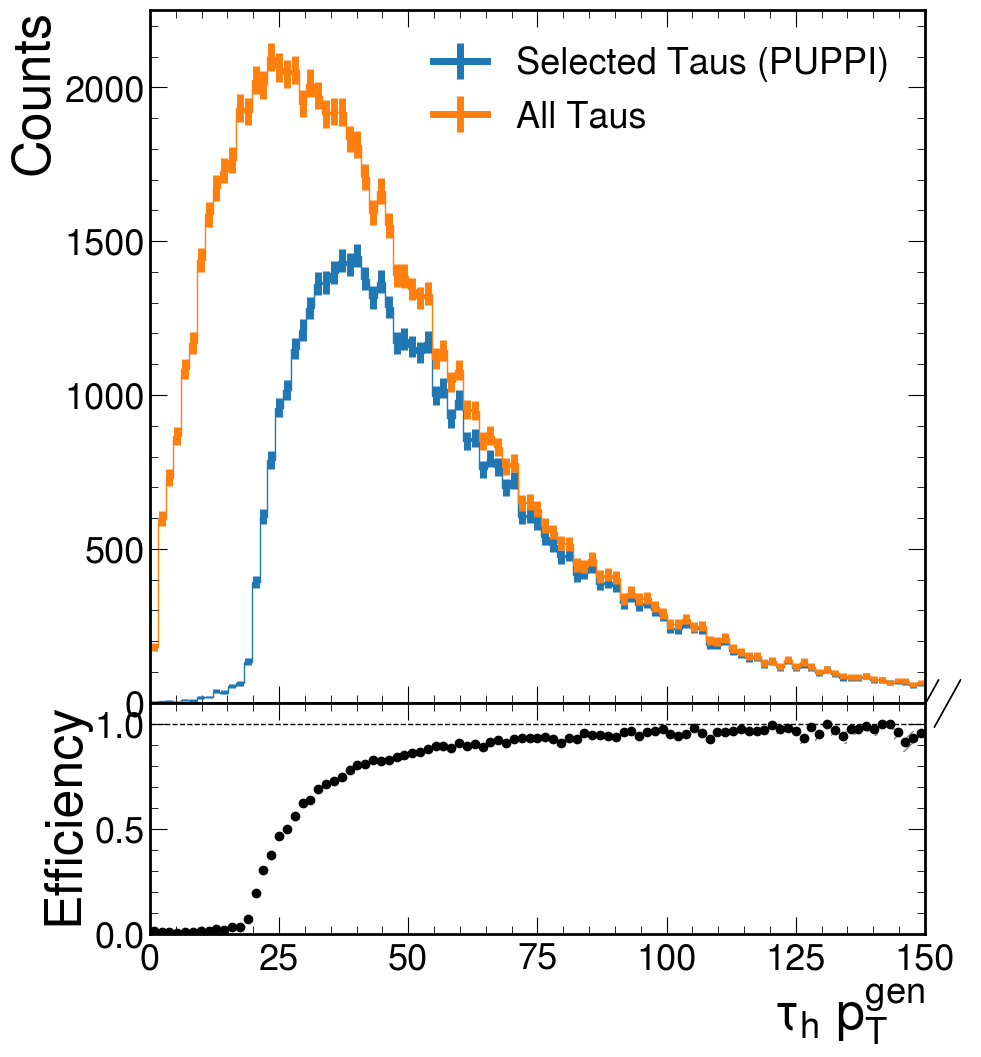

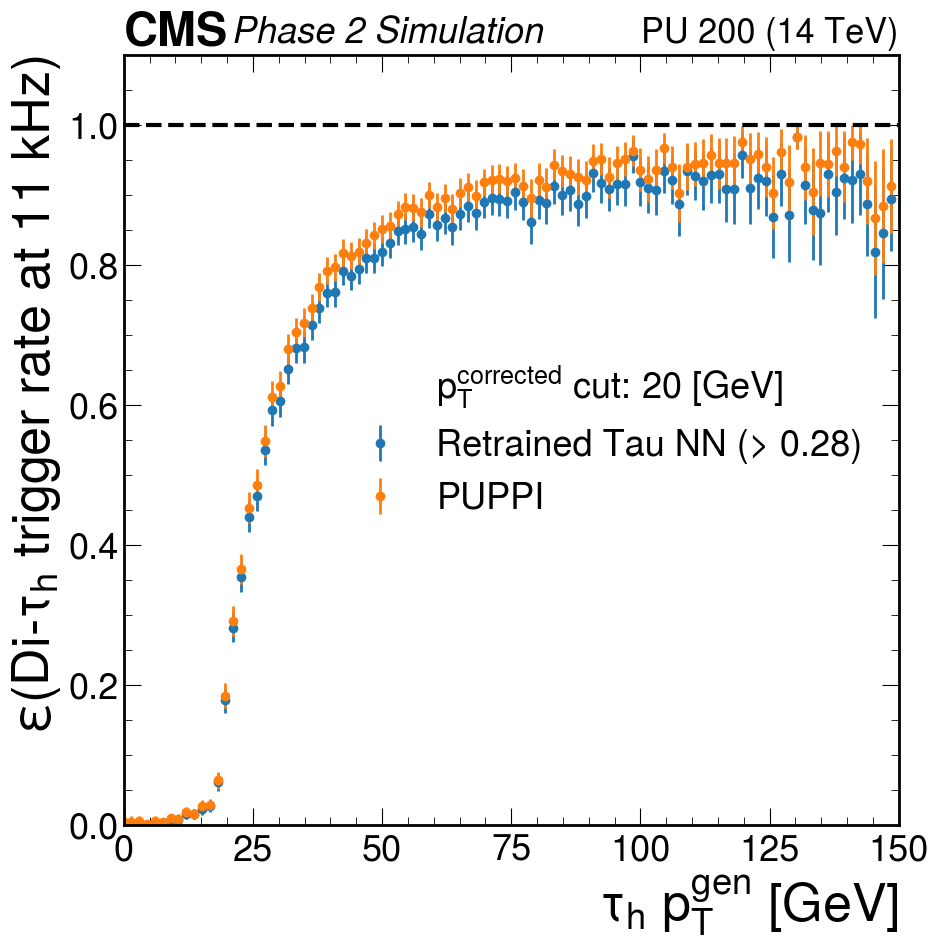

[1.         0.5177983  0.48121536 0.02009324 0.18896319 0.12819086
 0.07092525 0.02988478 0.05665289 0.0453095  0.05438923 0.05532855
 0.11206454 0.3121127  0.44617673 0.54788112 0.63468669 0.67019629
 0.74546643 0.79309687 0.81614391 0.84674992 0.87504441 0.87665306
 0.91036086 0.91351957 0.92613755 0.93488128 0.93980466 0.94670035
 0.94733003 0.94491093 0.95139725 0.95546822 0.95247023 0.96386415
 0.96236668 0.96926864 0.96817719 0.97532432 0.96209343 0.96935337
 0.96815081 0.98644598 0.98179628 0.98314731 0.97631565 0.98213045
 0.98925677 0.9851381  0.97789011 0.98728663 0.96806209 0.9795976
 0.98939006 0.98942597 0.99493449 0.98287552 0.99426126 0.98262216
 0.98604853 0.98687037 0.96529832 0.99650123 0.98479544 0.99583853
 0.98594472 0.98592007 0.98677333 0.99028186 0.99041153 0.98788511
 0.99380179 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 1.         0.98919063 0.97164876
 1.         0.97459075 1.         1.         1.         1.
 1. 

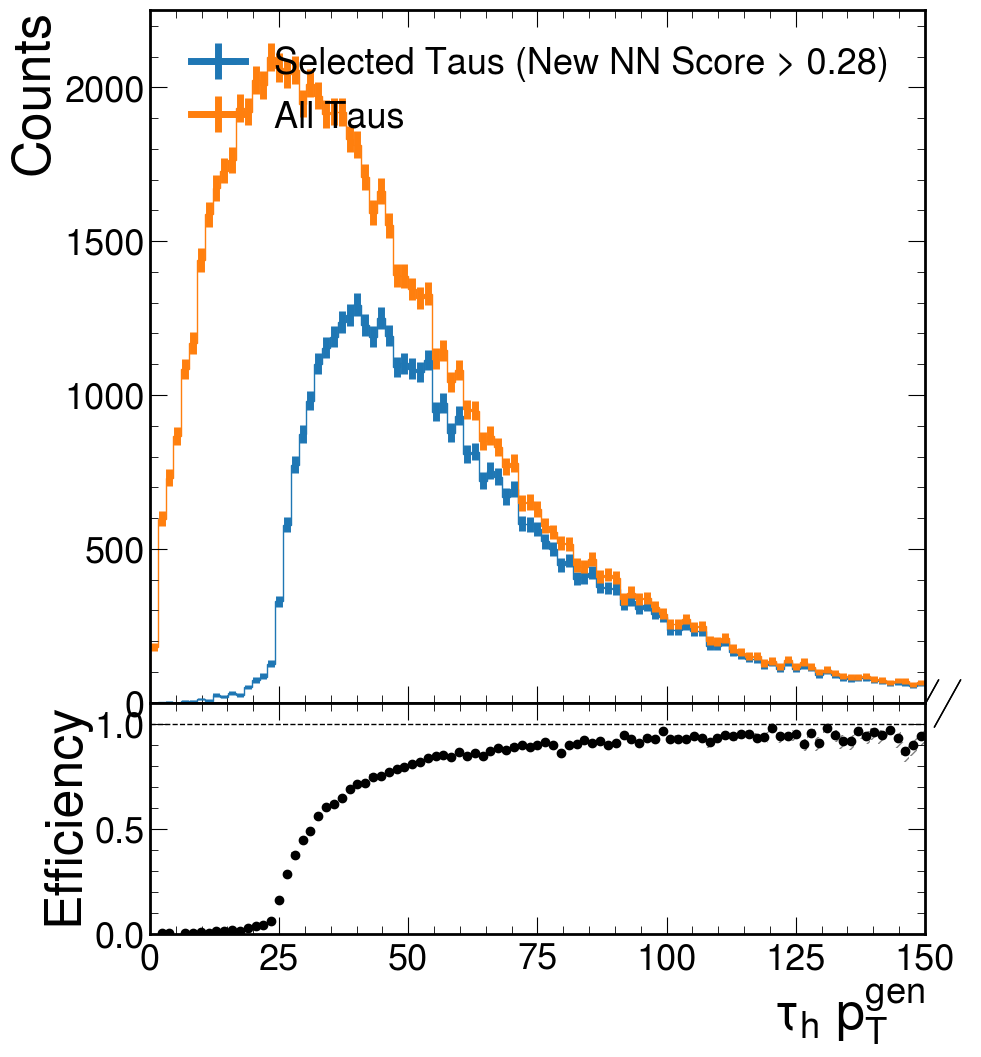

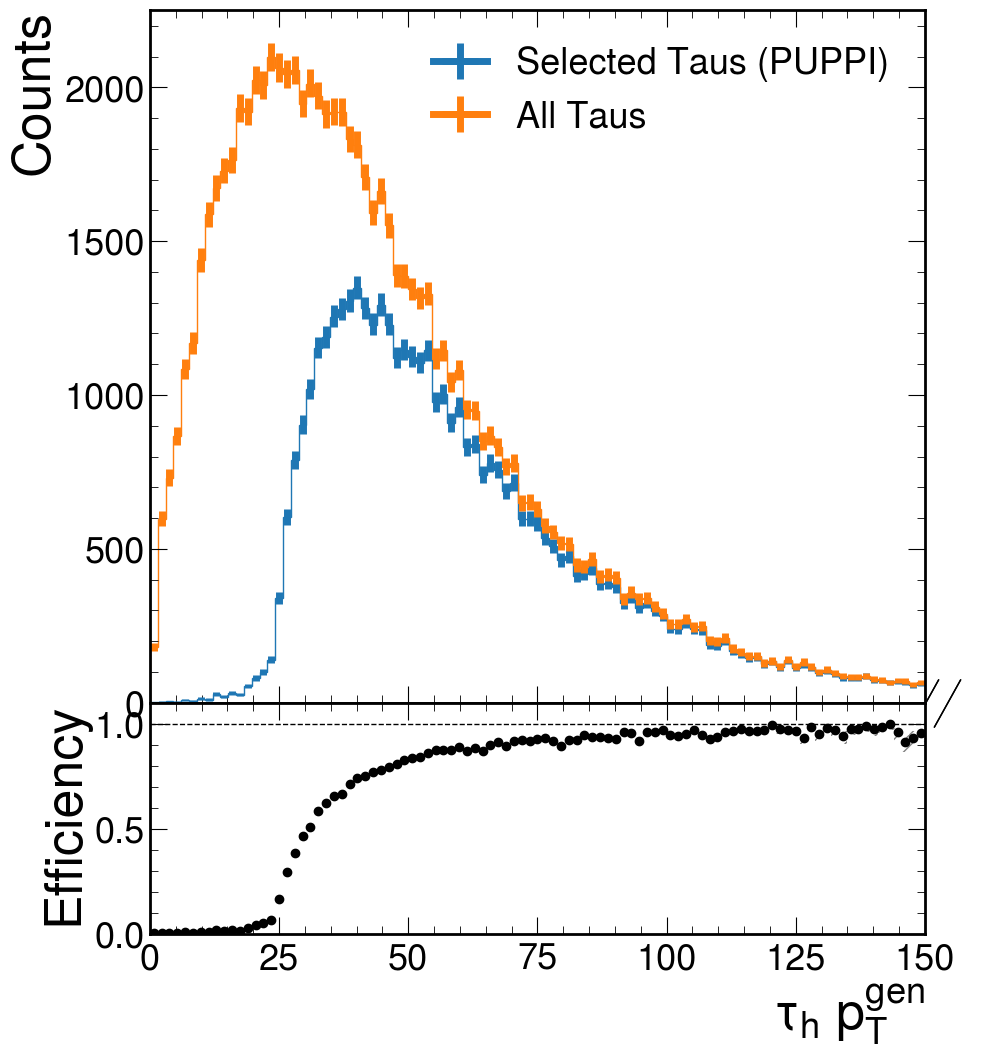

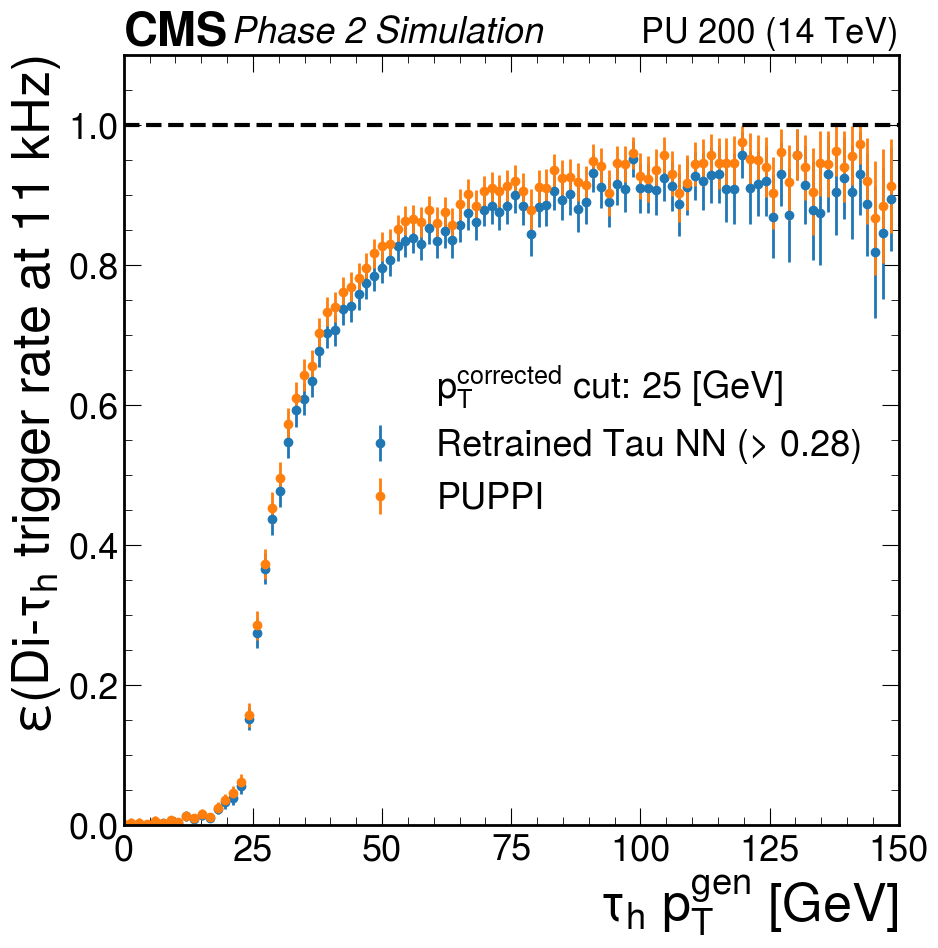

[0.         0.1262619  0.24918539 0.         0.18896319 0.12819086
 0.04909822 0.0128112  0.04302673 0.02521074 0.03323254 0.02060658
 0.04153959 0.05611162 0.0600495  0.08572306 0.21825406 0.38942025
 0.50852721 0.58501554 0.64221612 0.71163556 0.75955223 0.78224428
 0.80906621 0.8370089  0.85669716 0.86785558 0.87460565 0.8936133
 0.90504804 0.9029392  0.92114125 0.92885266 0.92479797 0.94016594
 0.94259547 0.9519204  0.95232307 0.9518309  0.93656254 0.94861933
 0.94747932 0.96753456 0.97063567 0.9678834  0.96453449 0.96968513
 0.96965298 0.97773401 0.97389275 0.98095049 0.94992928 0.96832945
 0.98674407 0.98153473 0.98735568 0.97720145 0.98567562 0.97398436
 0.98604853 0.98034821 0.9448425  0.99650123 0.97725325 0.99170856
 0.97666287 0.98592007 0.98677333 0.98066707 0.98089955 0.98788511
 0.96943491 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 0.99110074 0.98919063 0.97164876
 1.         0.97459075 0.97379898 1.         1.         1.
 1. 

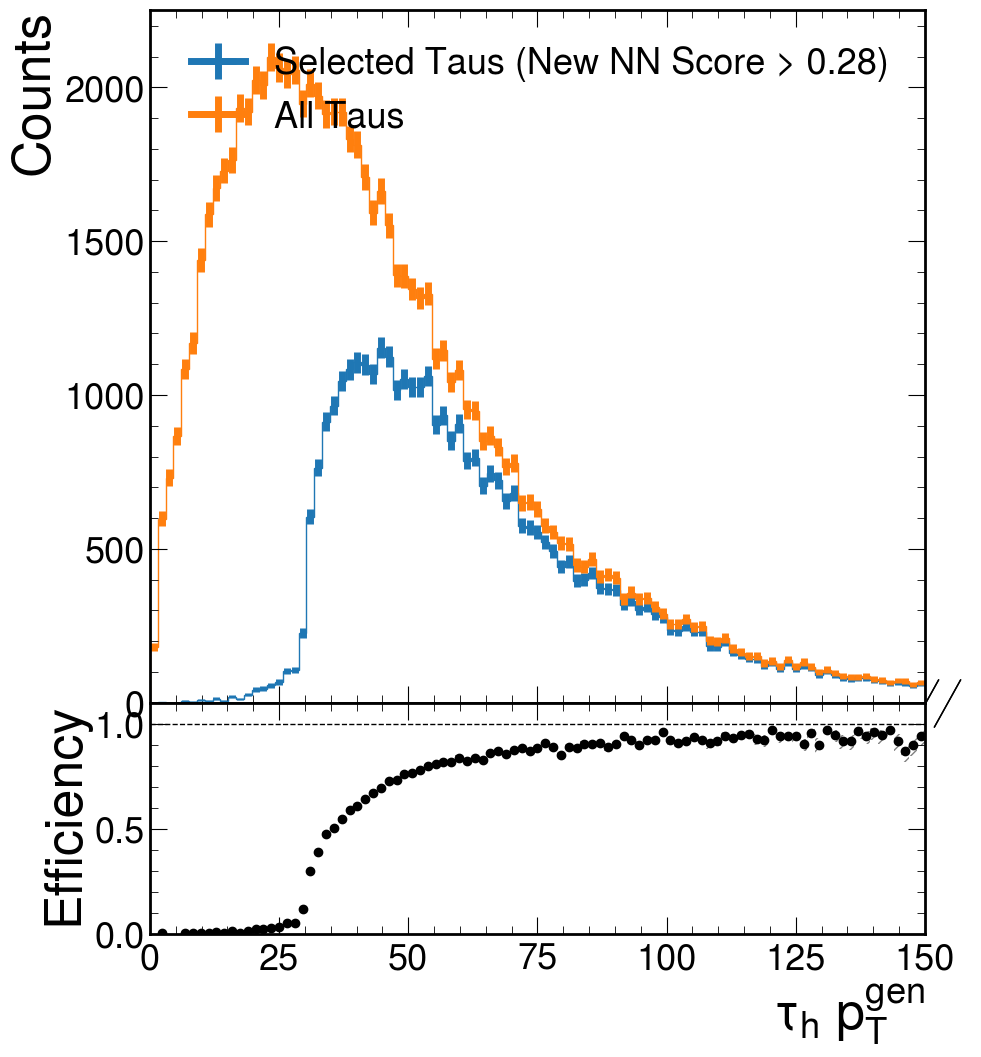

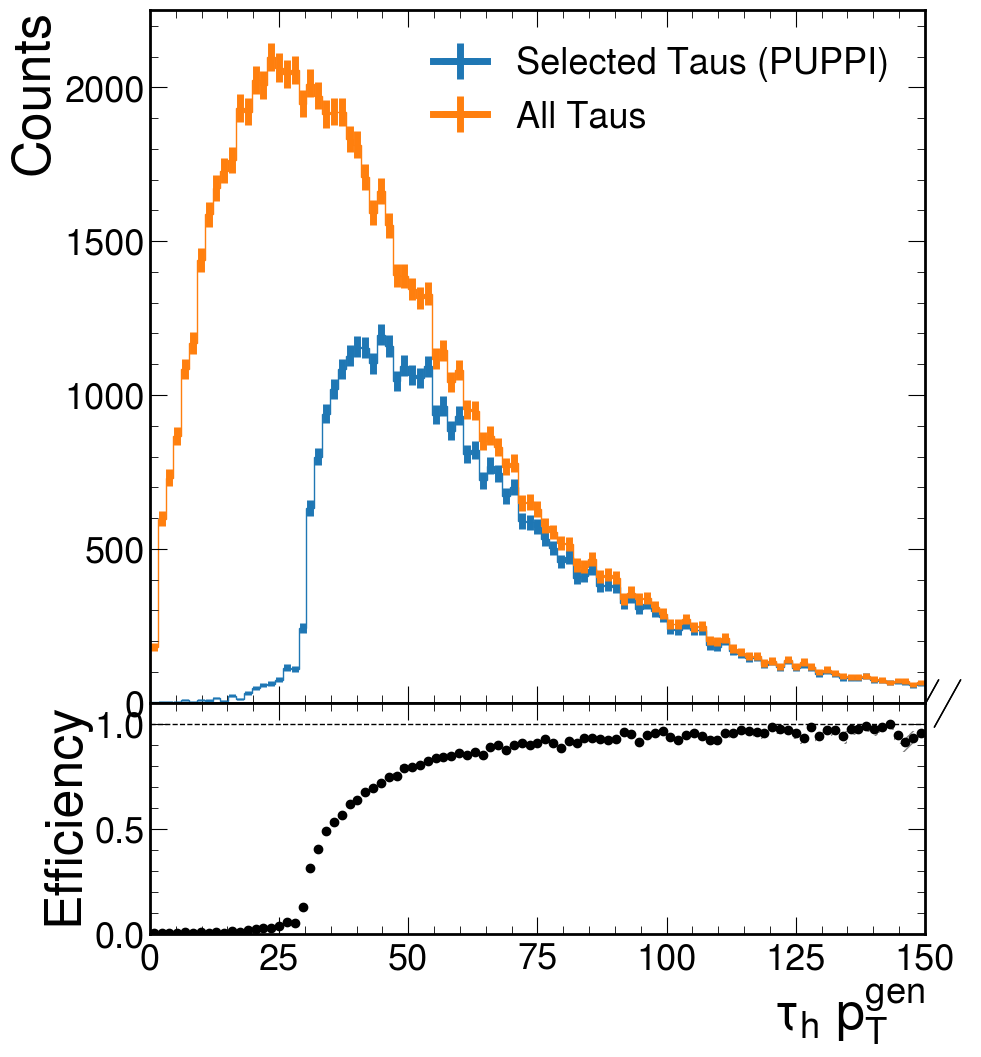

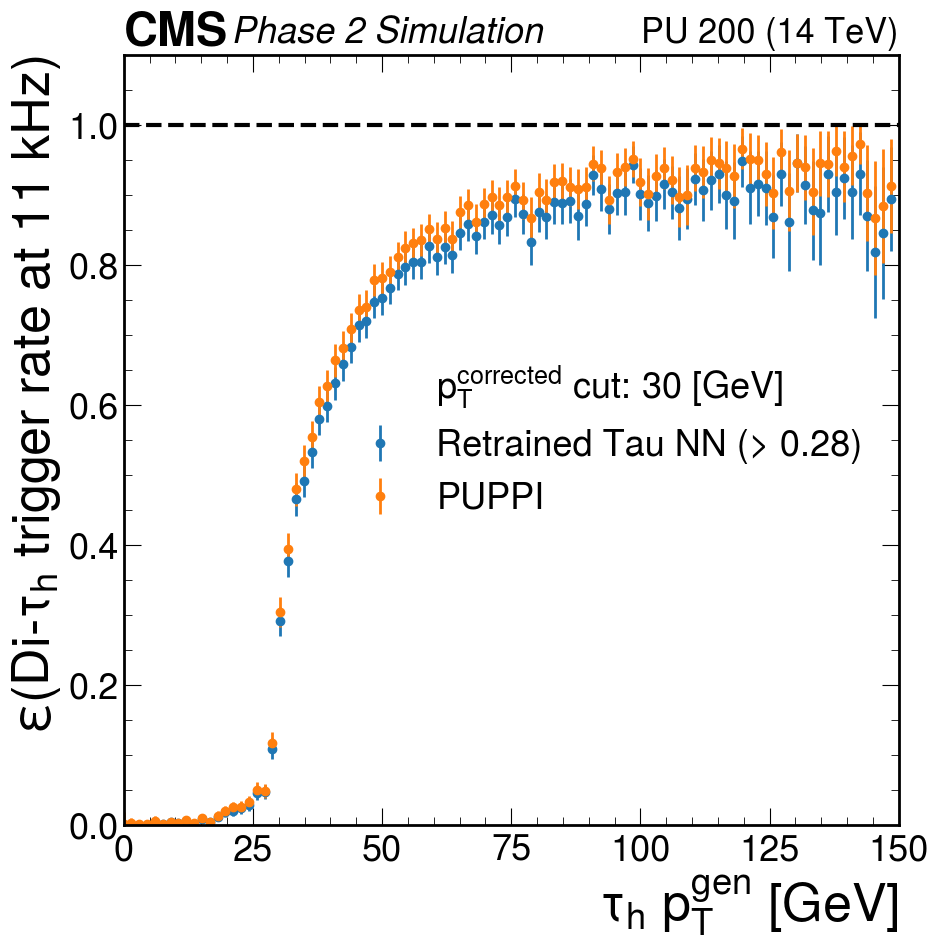

[0.         0.1262619  0.         0.         0.18896319 0.04840201
 0.0332046  0.00823417 0.02026876 0.00487483 0.02106149 0.0083256
 0.0202347  0.03091799 0.0310694  0.03591534 0.04119982 0.06491665
 0.06490688 0.14581252 0.39155093 0.48918593 0.59696149 0.63122303
 0.68019504 0.71731679 0.7293305  0.77498978 0.78180824 0.8238282
 0.8519771  0.83981403 0.87718884 0.87757248 0.88032165 0.89469816
 0.90009878 0.91226717 0.92296442 0.92311489 0.91112603 0.92431451
 0.92413005 0.95541185 0.95394552 0.94659109 0.94546074 0.95551544
 0.94837989 0.95929088 0.96790787 0.96831462 0.93637633 0.96158807
 0.96828676 0.96323088 0.98231517 0.96589655 0.97426629 0.97111176
 0.98258943 0.97709647 0.93468742 0.98257955 0.97349507 0.98352731
 0.96743951 0.96273737 0.97801715 0.97113618 0.97145221 0.981858
 0.9514882  0.97705798 0.97909858 0.98491156 1.         0.98375692
 0.98065738 0.99051765 0.98931622 0.99110074 0.97852634 0.97164876
 1.         0.96205601 0.96184918 1.         1.         1.
 1.    

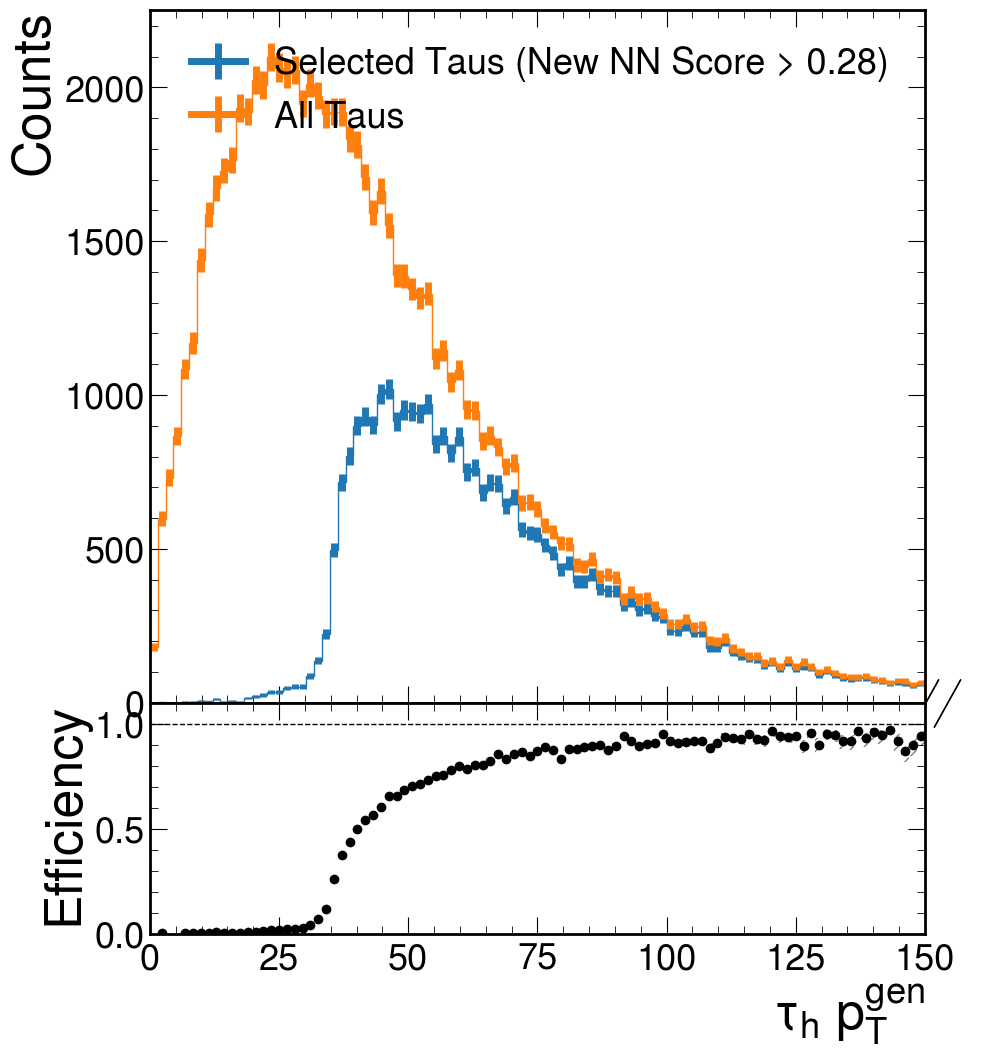

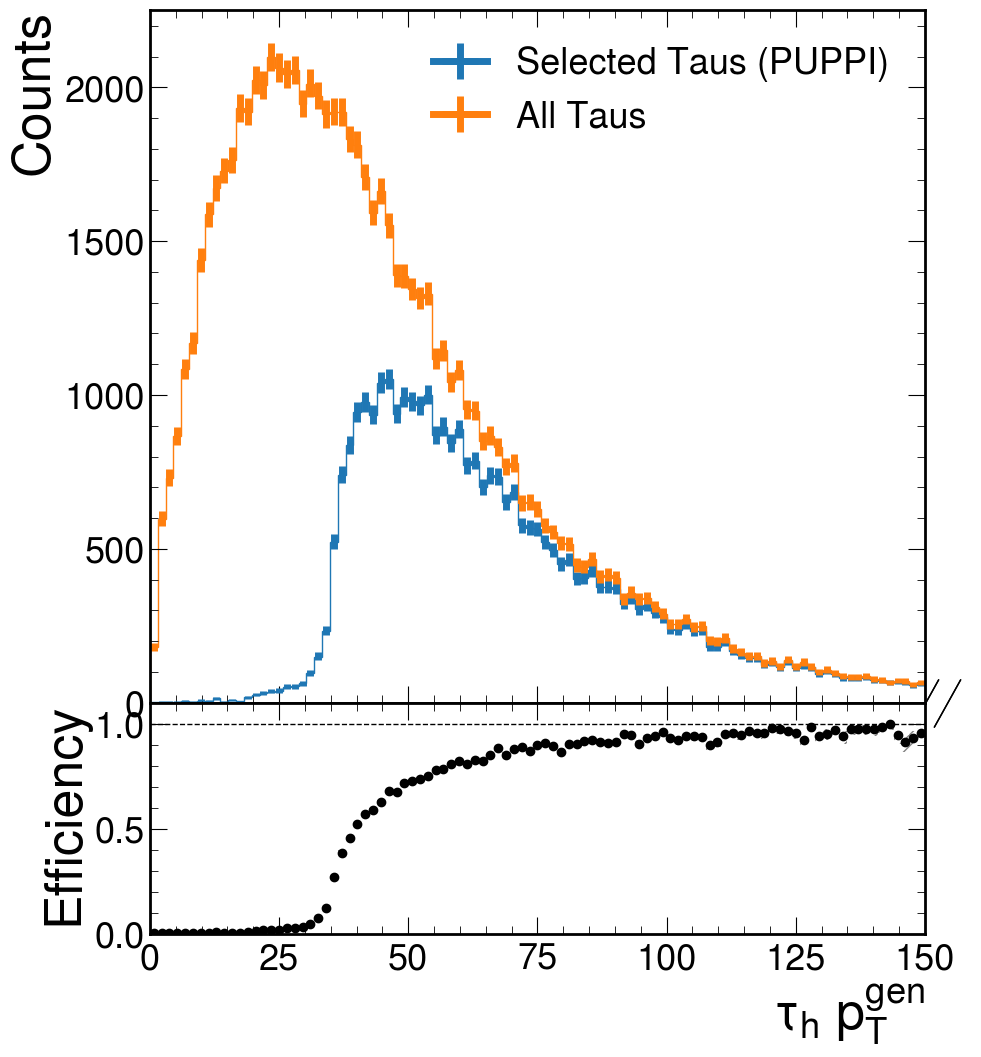

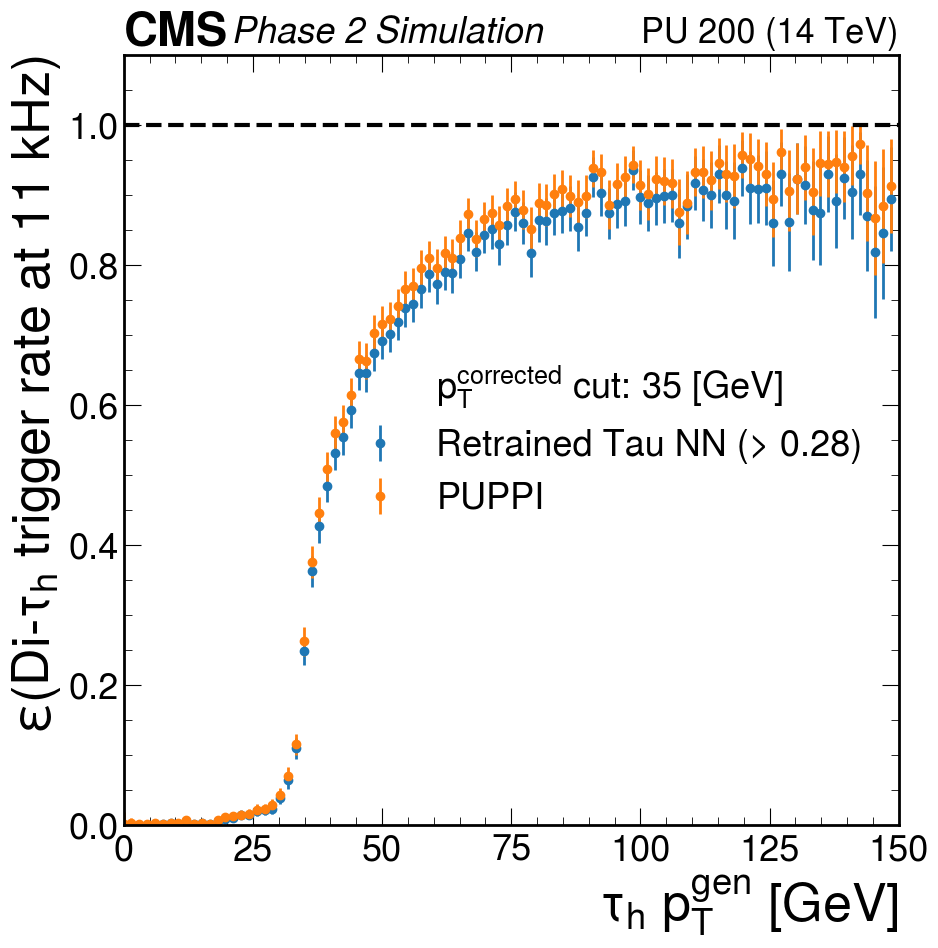

[0.         0.1262619  0.         0.         0.0713465  0.04840201
 0.02297315 0.00604595 0.018429   0.00121515 0.00489539 0.00147118
 0.01079397 0.0143054  0.01514282 0.02085596 0.01973431 0.02805567
 0.02973232 0.03090535 0.05218521 0.08221069 0.14014218 0.31914396
 0.46190149 0.52738081 0.59053854 0.65295567 0.6579912  0.71413505
 0.77034482 0.75237026 0.79053246 0.80627575 0.80418495 0.81642388
 0.83412445 0.84451953 0.87797888 0.87865014 0.86649802 0.88438324
 0.8940192  0.91382883 0.93869318 0.92083907 0.92500301 0.93435196
 0.91840542 0.94643074 0.9480438  0.95362742 0.91836083 0.94814459
 0.96040783 0.94764327 0.96975208 0.95464274 0.95722474 0.95679391
 0.97914017 0.97061015 0.92794044 0.96531682 0.95853808 0.97543192
 0.9628473  0.96273737 0.97365526 0.95227446 0.96674991 0.95792222
 0.93964039 0.97140961 0.97909858 0.96271157 1.         0.98375692
 0.98065738 0.98123713 0.98931622 0.98228443 0.97852634 0.962304
 1.         0.96205601 0.93891269 1.         1.         1.
 1.  

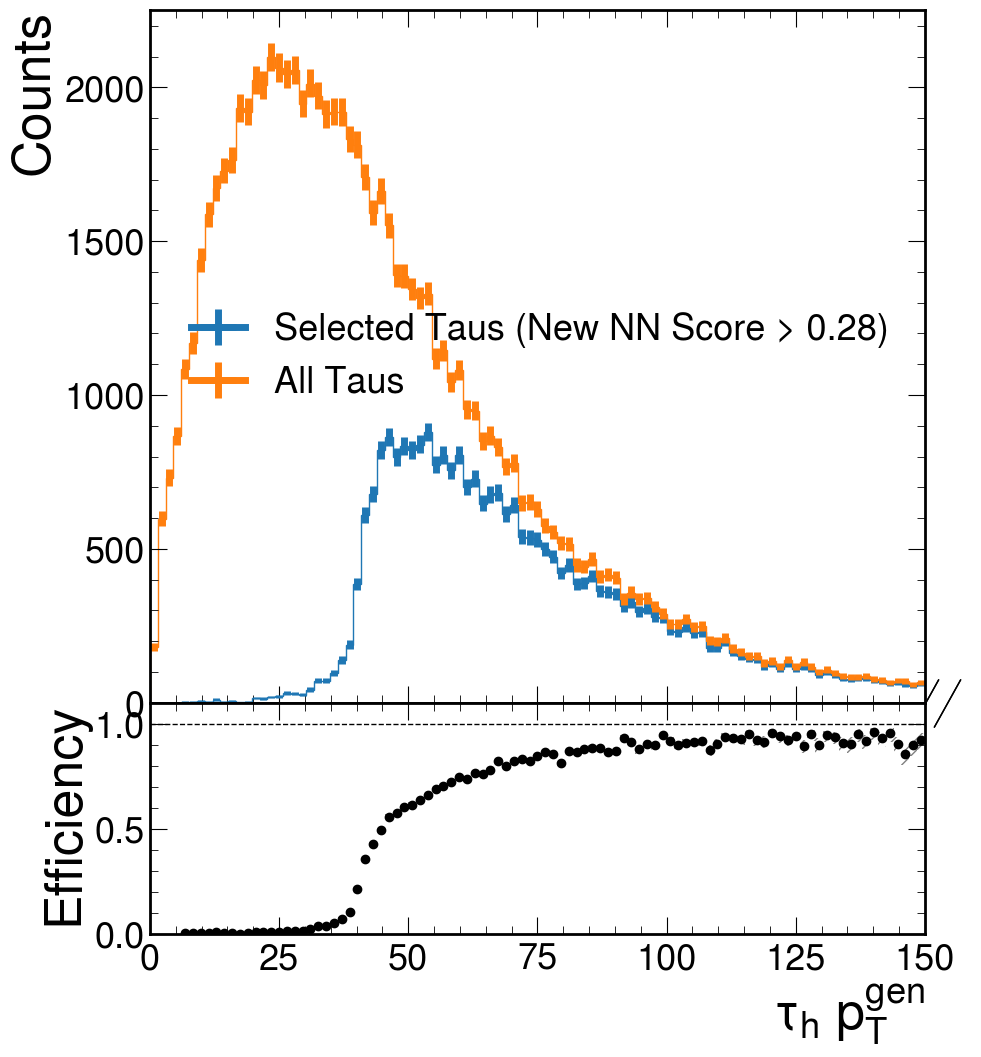

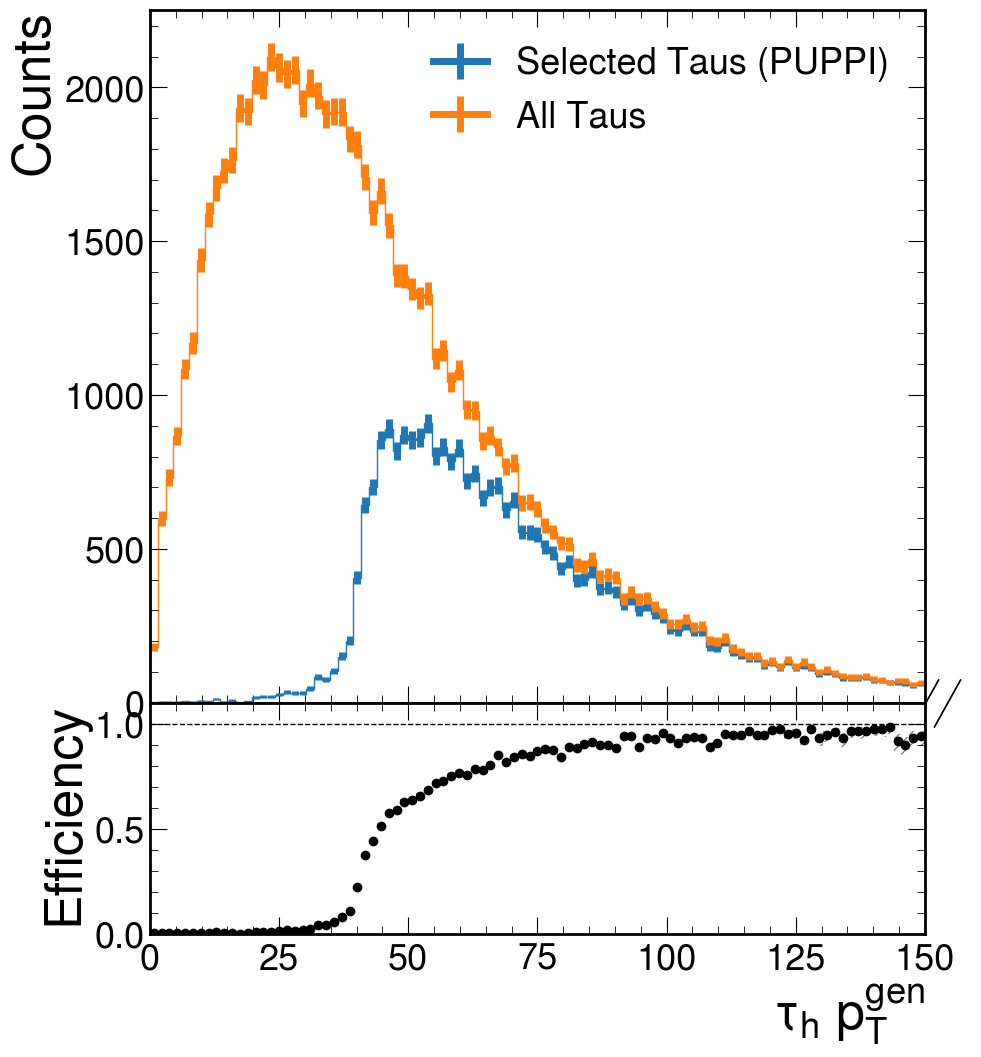

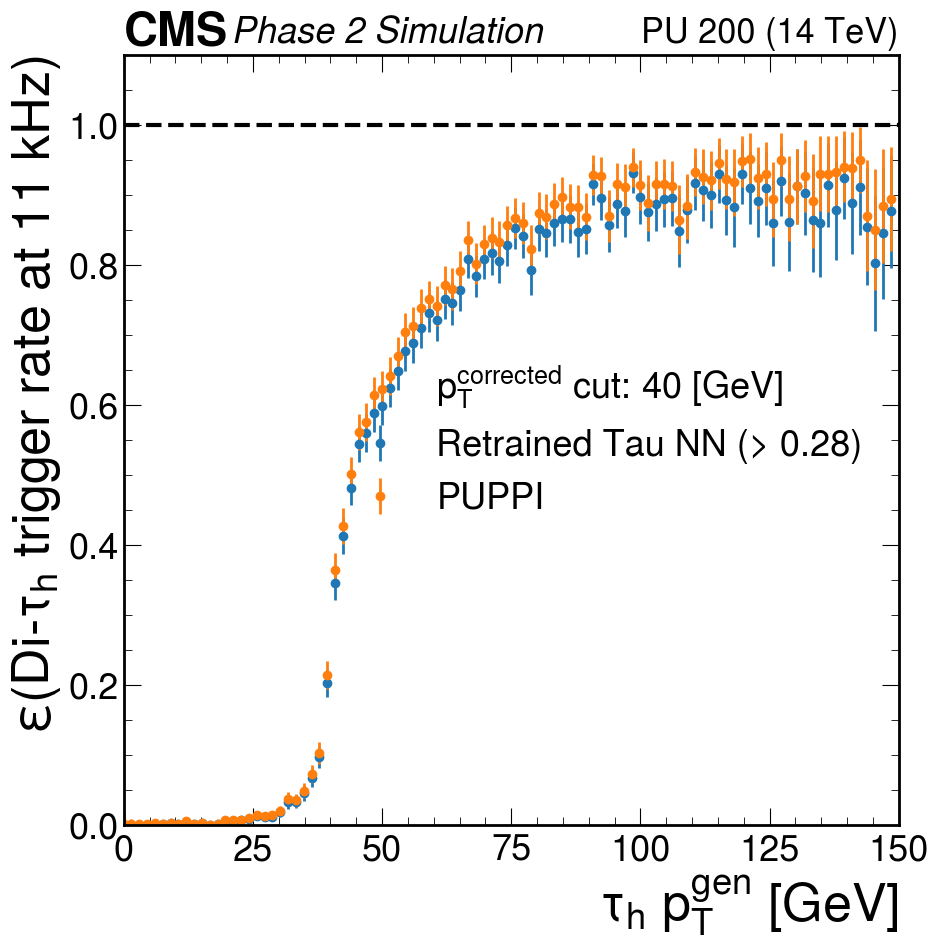

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.13464989e-02 4.84020054e-02 1.80233717e-02 2.05249583e-03
 1.47923228e-02 1.21515405e-03 4.89538983e-03 1.85840687e-04
 1.32043502e-03 9.71009305e-03 7.46897127e-03 1.02008202e-02
 1.15119435e-02 1.71433380e-02 1.60144375e-02 1.44294376e-02
 2.38585591e-02 4.13460279e-02 4.20814519e-02 5.78720058e-02
 8.48639502e-02 1.18874563e-01 2.47039558e-01 4.24227602e-01
 4.90215499e-01 5.81009653e-01 6.48884309e-01 6.53531049e-01
 6.90672755e-01 6.97707395e-01 7.16114694e-01 7.36837839e-01
 7.65427213e-01 7.81153704e-01 8.14183619e-01 8.16517955e-01
 8.08894069e-01 8.41021505e-01 8.44962700e-01 8.63151938e-01
 8.98661582e-01 8.81634611e-01 8.87196753e-01 8.95782595e-01
 8.92087238e-01 9.15342026e-01 9.22383876e-01 9.32733816e-01
 8.91441849e-01 9.34748144e-01 9.42087338e-01 9.32133261e-01
 9.57237937e-01 9.37844396e-01 9.48733112e-01 9.31185536e-01
 9.68845124e-01 9.64144987e-01 9.11144546e-01 9.65316823e-01
 9.43685624e-01 9.714111

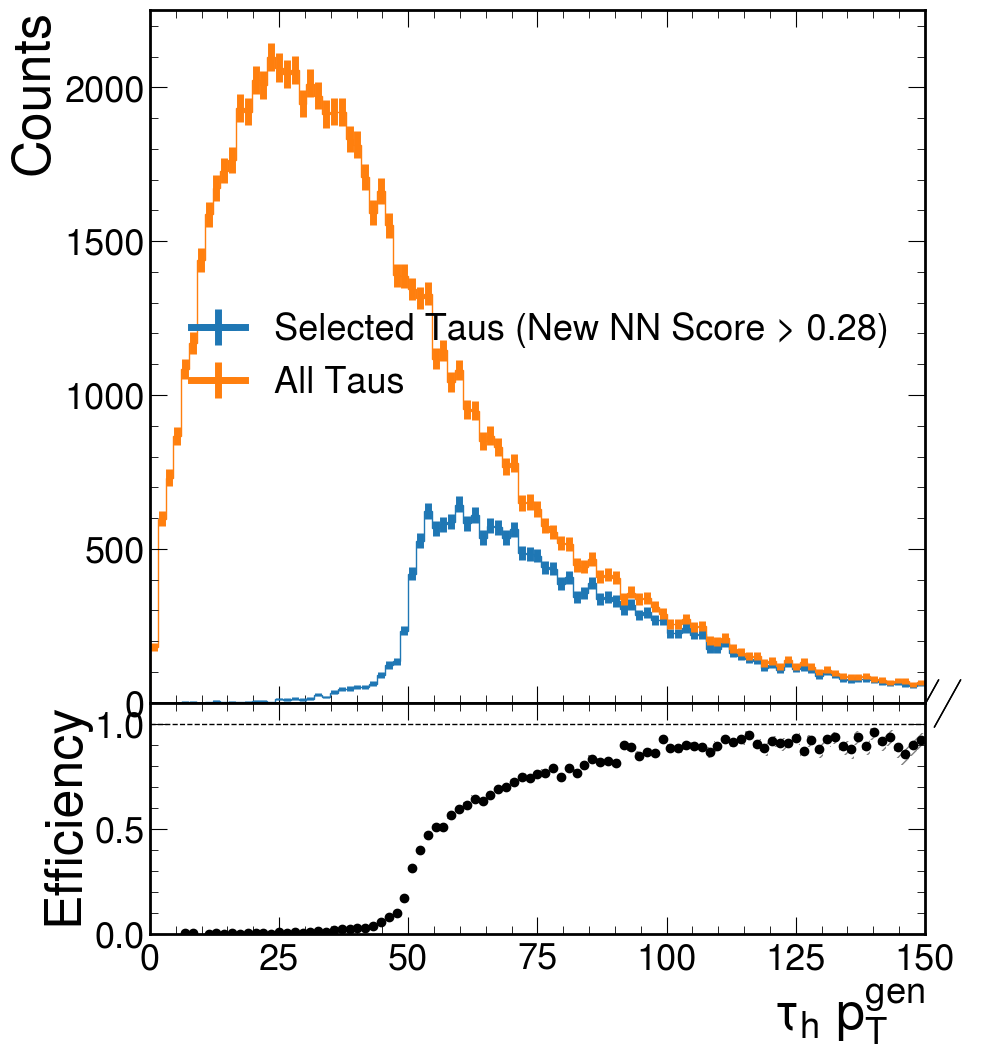

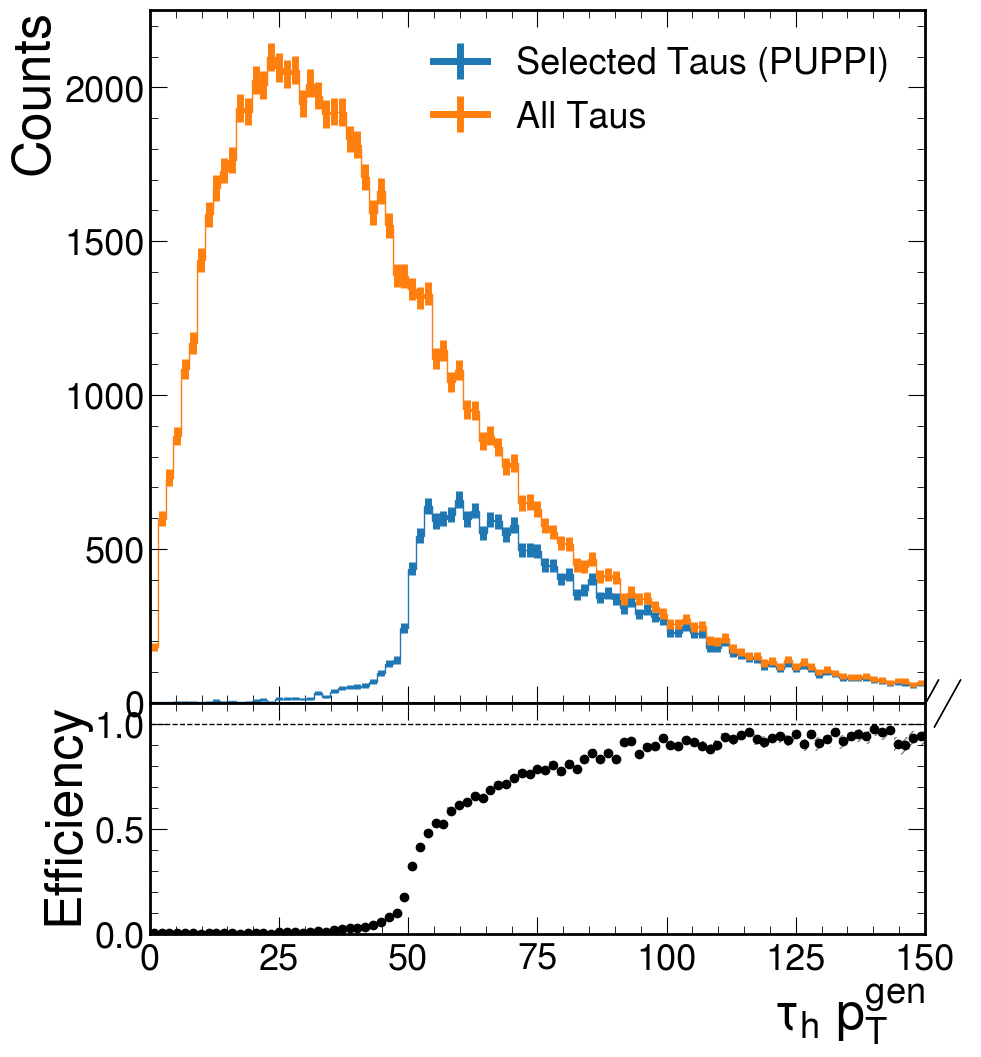

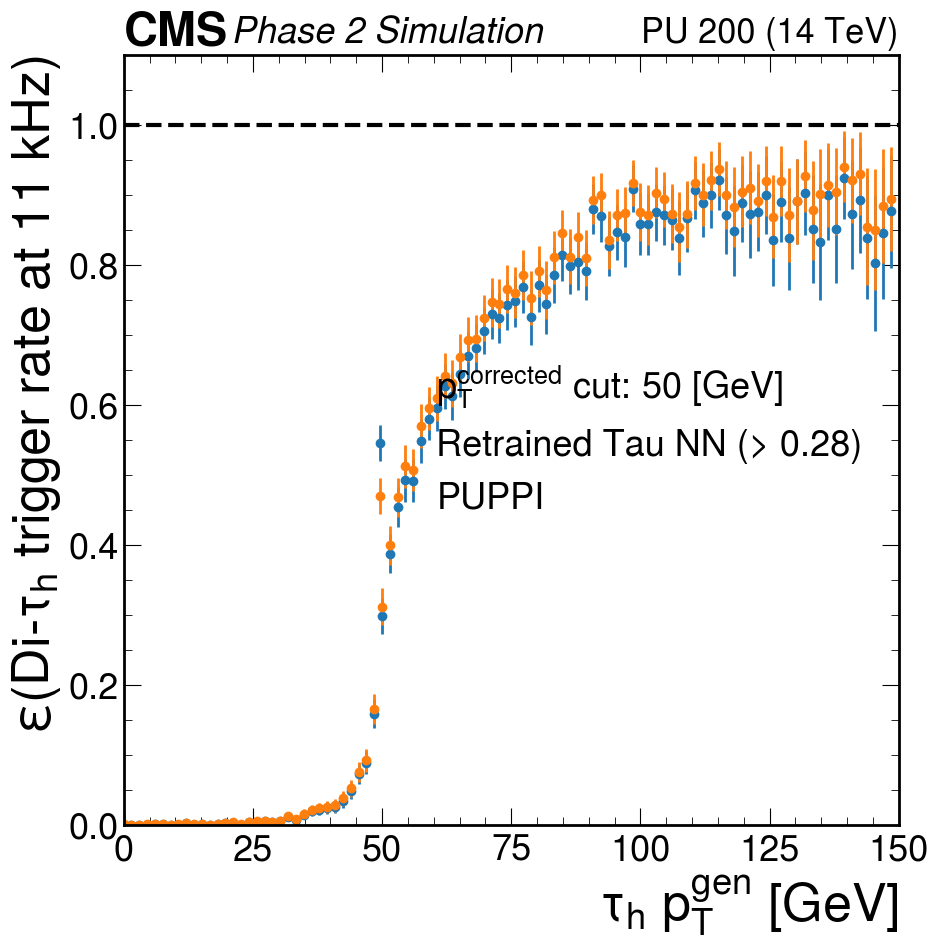

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 7.76884972e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 3.14562445e-03 2.86296513e-03 1.27621602e-04
 6.00453377e-03 4.80876817e-03 6.39138964e-03 4.74765534e-03
 6.33259330e-03 1.38159457e-02 9.26537710e-03 1.82941803e-02
 2.42914133e-02 2.59363589e-02 2.89310830e-02 3.09474441e-02
 4.04983924e-02 5.86284258e-02 8.57117114e-02 1.03252626e-01
 1.86313682e-01 3.47957459e-01 4.43866178e-01 5.16289427e-01
 5.56004016e-01 5.57820568e-01 6.28850169e-01 6.48398480e-01
 6.68355157e-01 7.01175576e-01 6.94985958e-01 7.28287174e-01
 7.44392235e-01 7.66494305e-01 7.74831462e-01 8.00301647e-01
 8.01564657e-01 8.21179570e-01 8.09395881e-01 8.52000217e-01
 8.15723972e-01 8.46341076e-01 8.28417411e-01 8.50368163e-01
 9.00167718e-01 8.65900517e-01 9.00918443e-01 8.66457538e-01
 9.31611798e-01 9.35270929e-01 8.77809921e-01 9.20969595e-01
 9.03257915e-01 9.475771

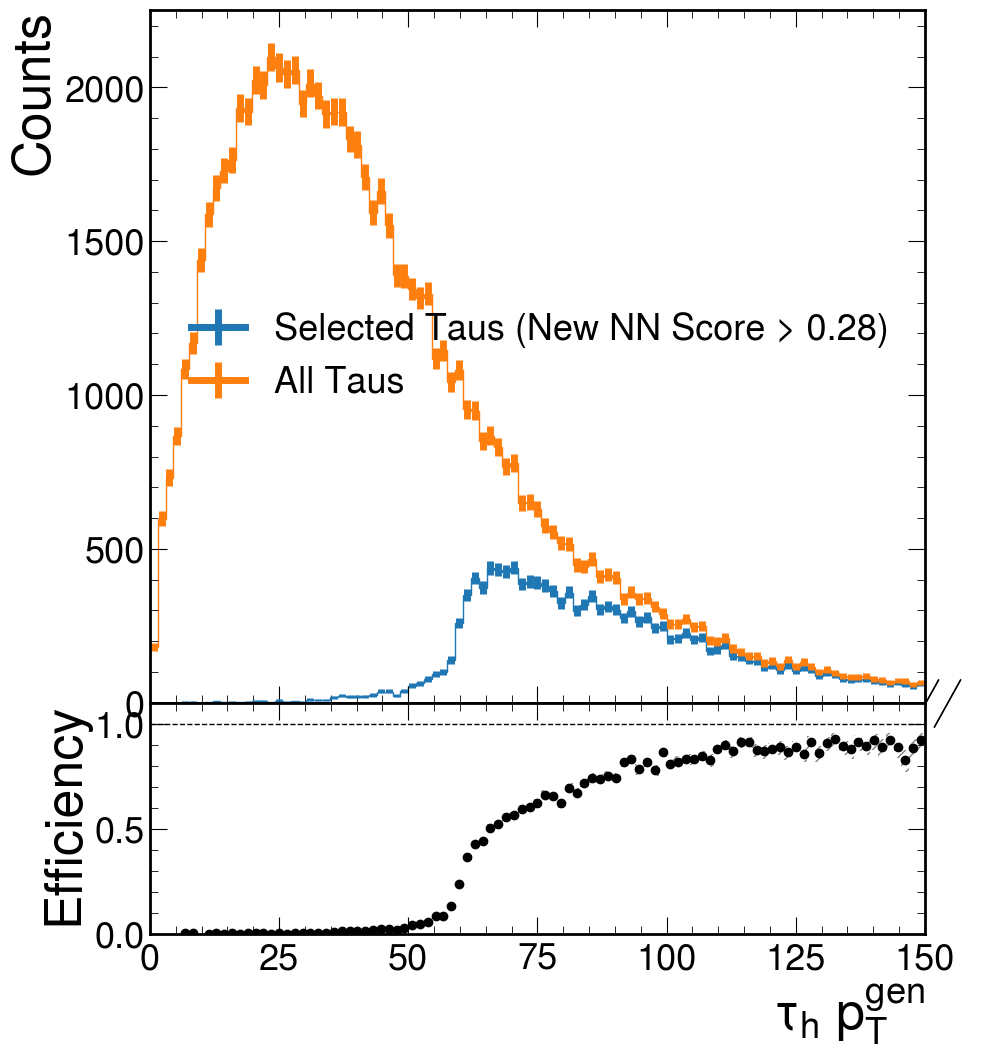

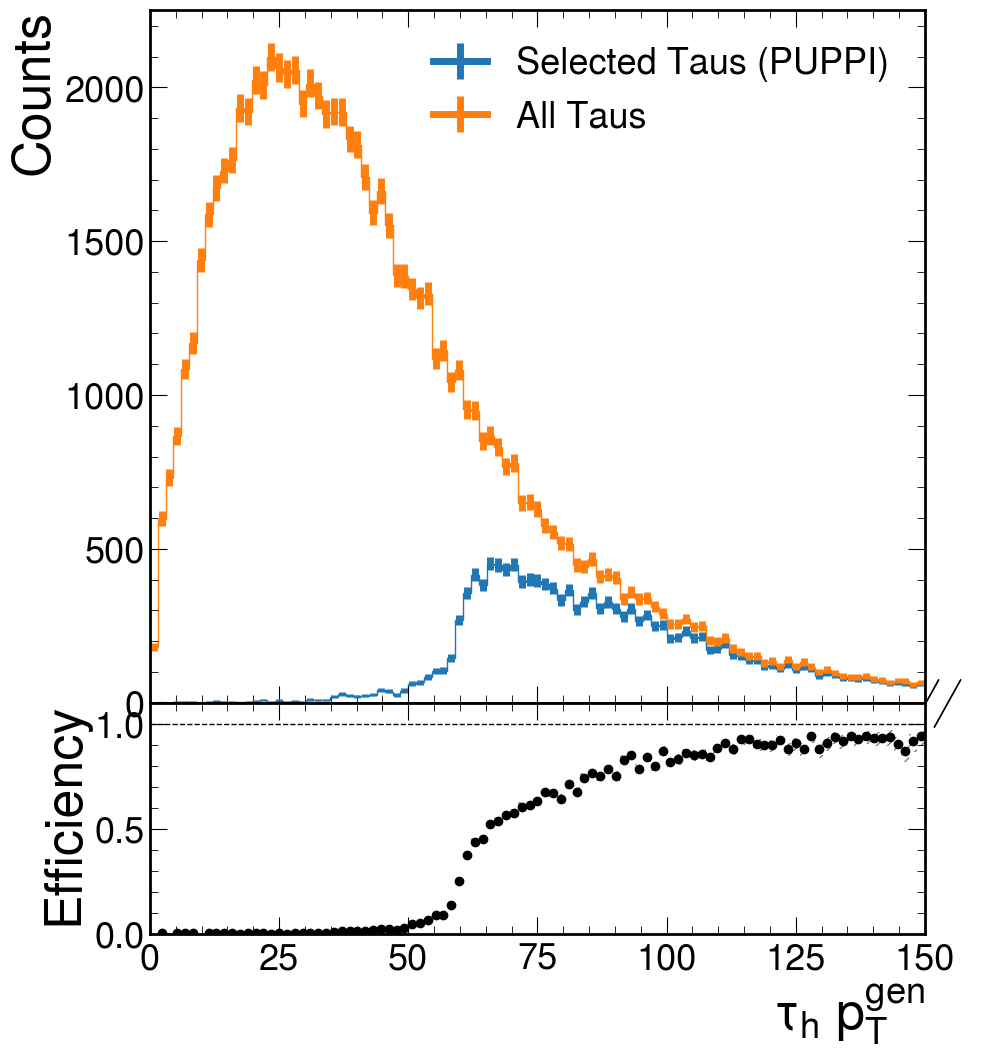

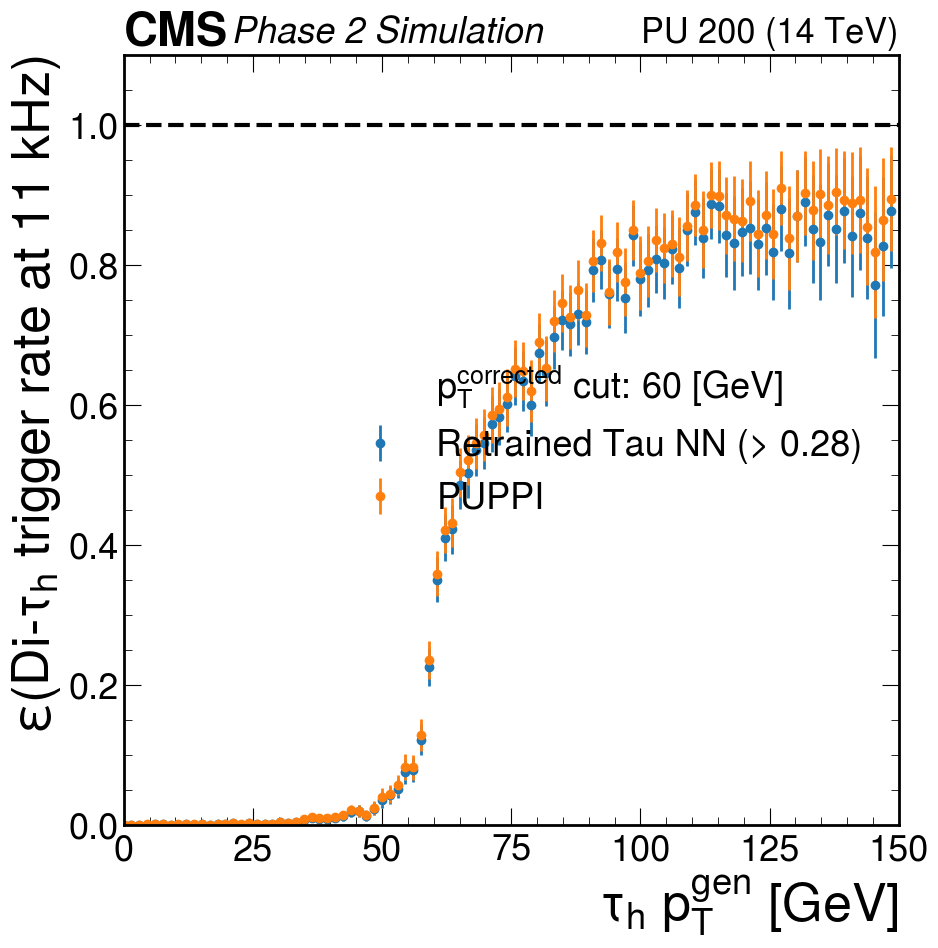

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 4.47530891e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 2.46792506e-03 2.86296513e-03 1.27621602e-04
 3.08988428e-03 4.93953397e-04 1.41133891e-03 4.87664975e-04
 4.62169005e-03 3.99501291e-03 4.06589107e-03 8.65757897e-03
 1.21434950e-02 1.05296505e-02 1.04766351e-02 1.18464616e-02
 1.49699361e-02 2.18374951e-02 2.31540614e-02 1.45897248e-02
 2.70468088e-02 4.14366802e-02 4.81786357e-02 5.85703240e-02
 8.46506554e-02 8.86666029e-02 1.39700050e-01 2.51969745e-01
 3.93196693e-01 4.59134416e-01 4.78745355e-01 5.49114383e-01
 5.58470229e-01 6.02357527e-01 5.98409666e-01 6.29004128e-01
 6.45053247e-01 6.63962345e-01 6.94171953e-01 7.03034832e-01
 6.74851428e-01 7.39517388e-01 7.19010152e-01 7.54689843e-01
 7.97401407e-01 7.75935274e-01 8.17500355e-01 7.85875856e-01
 8.38996467e-01 8.68894863e-01 8.05369830e-01 8.63791589e-01
 8.09340902e-01 8.779077

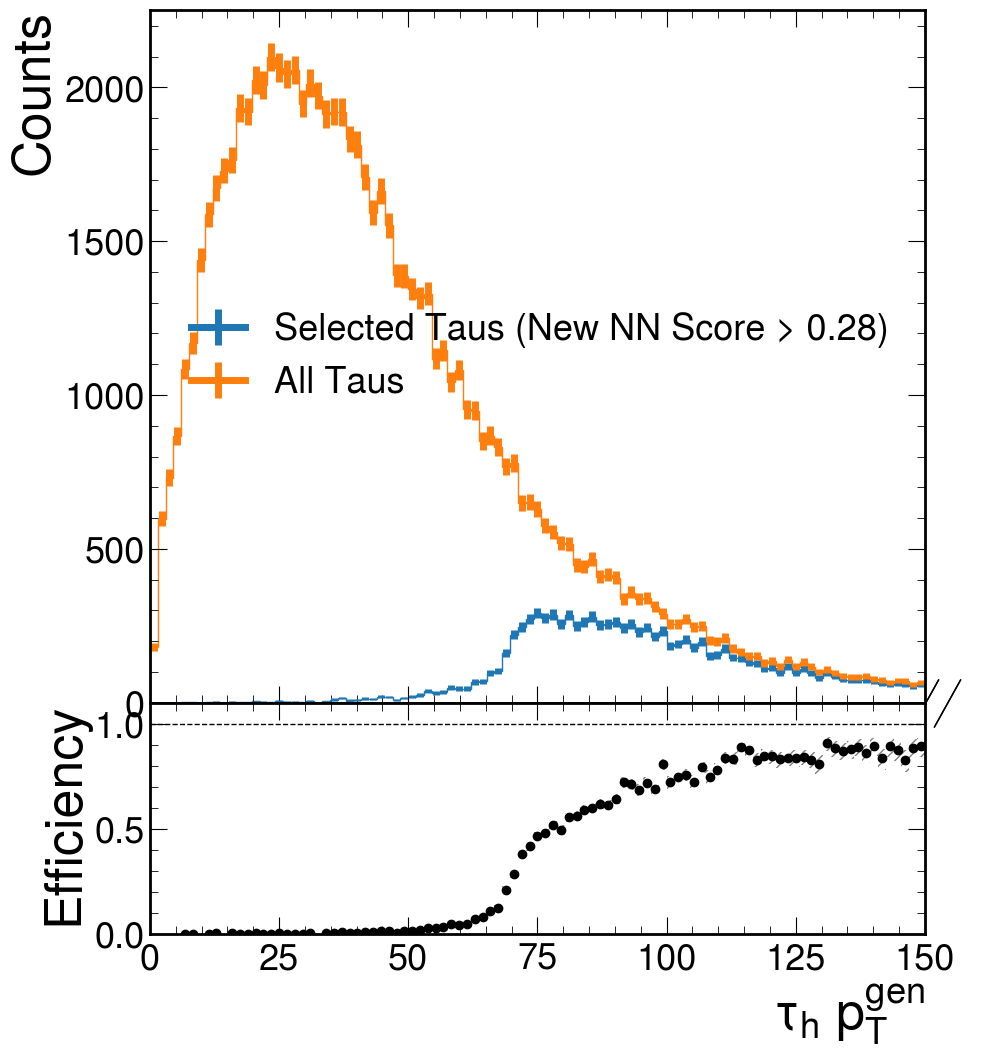

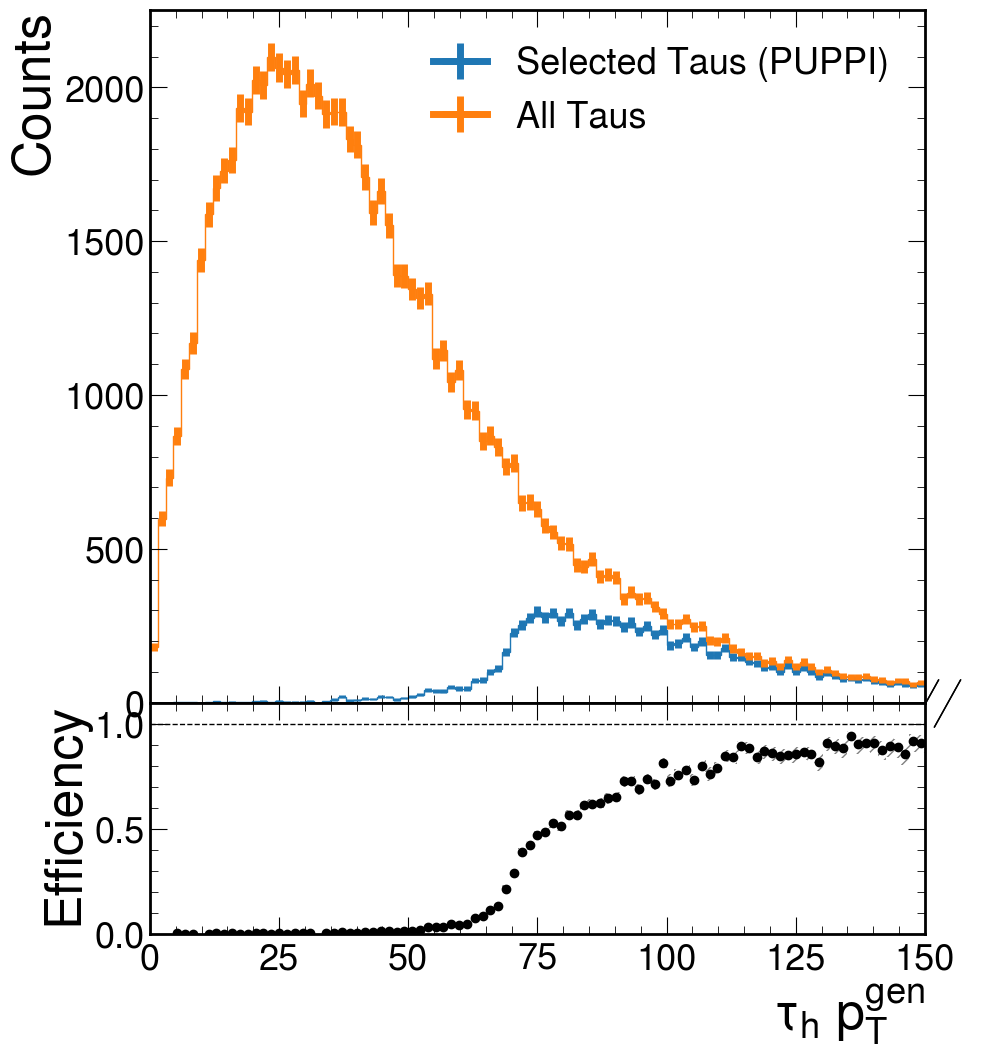

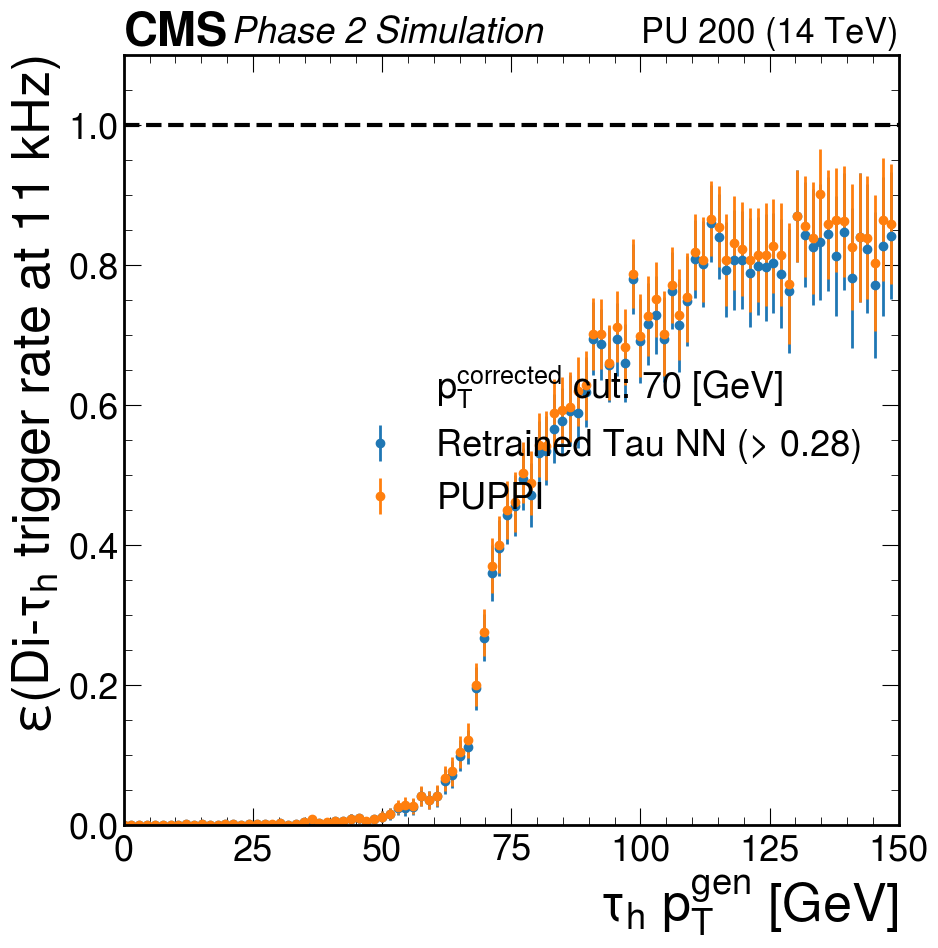

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 2.93362799e-03 0.00000000e+00 9.57377801e-04 1.85840687e-04
 1.66798111e-04 1.81210651e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 4.79147060e-04 1.18946118e-04
 2.42737710e-03 0.00000000e+00 1.39977371e-03 4.61740776e-03
 7.43544670e-03 2.98748917e-03 3.51959239e-03 6.79546647e-03
 5.77634986e-03 1.06703217e-02 1.06325668e-02 4.39743038e-03
 9.47419595e-03 1.35330665e-02 1.75021506e-02 2.65304924e-02
 2.67269492e-02 2.89280763e-02 4.63815278e-02 3.97127111e-02
 4.52751656e-02 6.96485811e-02 8.12992205e-02 1.11592109e-01
 1.23771958e-01 2.19316081e-01 2.93355494e-01 3.94547265e-01
 4.38085757e-01 4.89404156e-01 4.93394353e-01 5.48019672e-01
 5.29169135e-01 5.82418895e-01 5.95768833e-01 6.13098000e-01
 6.38355718e-01 6.41523770e-01 6.58602179e-01 6.76057882e-01
 7.35284392e-01 7.38673858e-01 6.98314937e-01 7.54502941e-01
 7.09882984e-01 8.135384

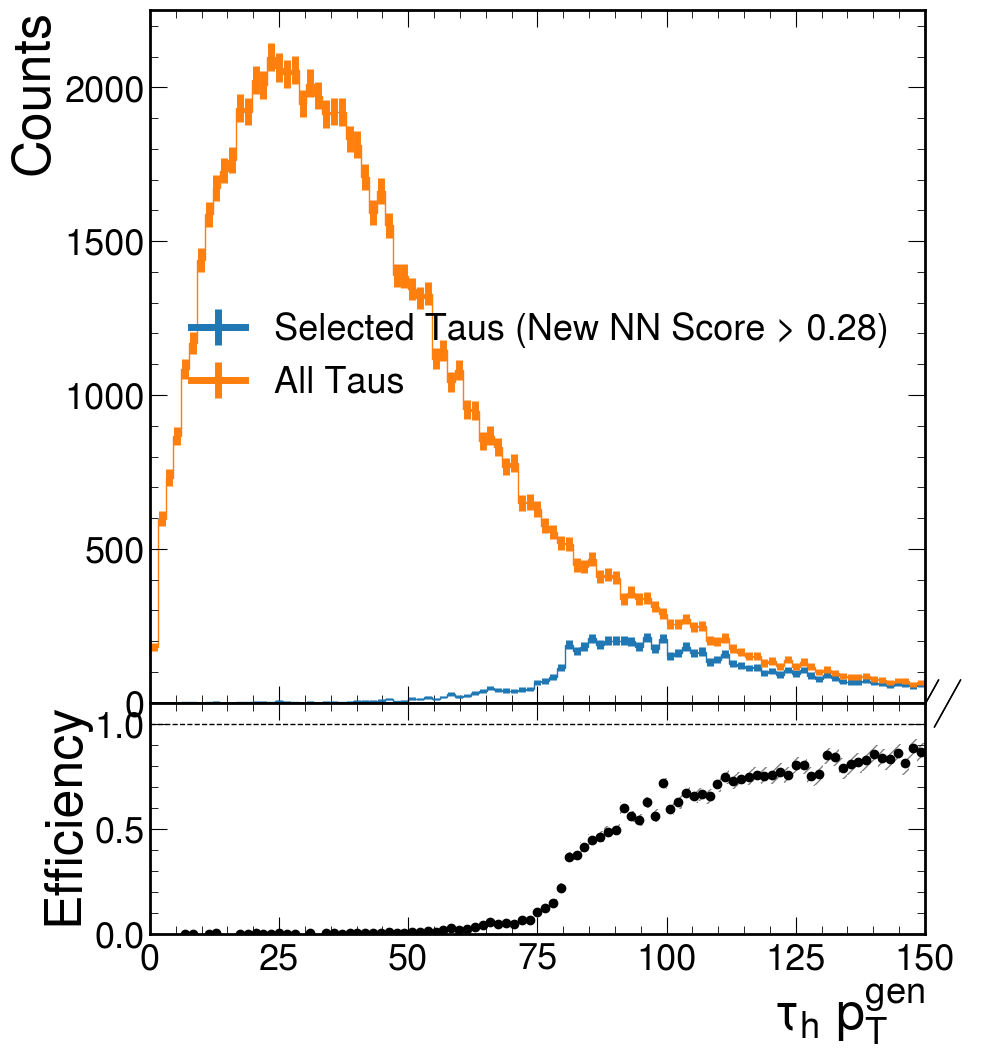

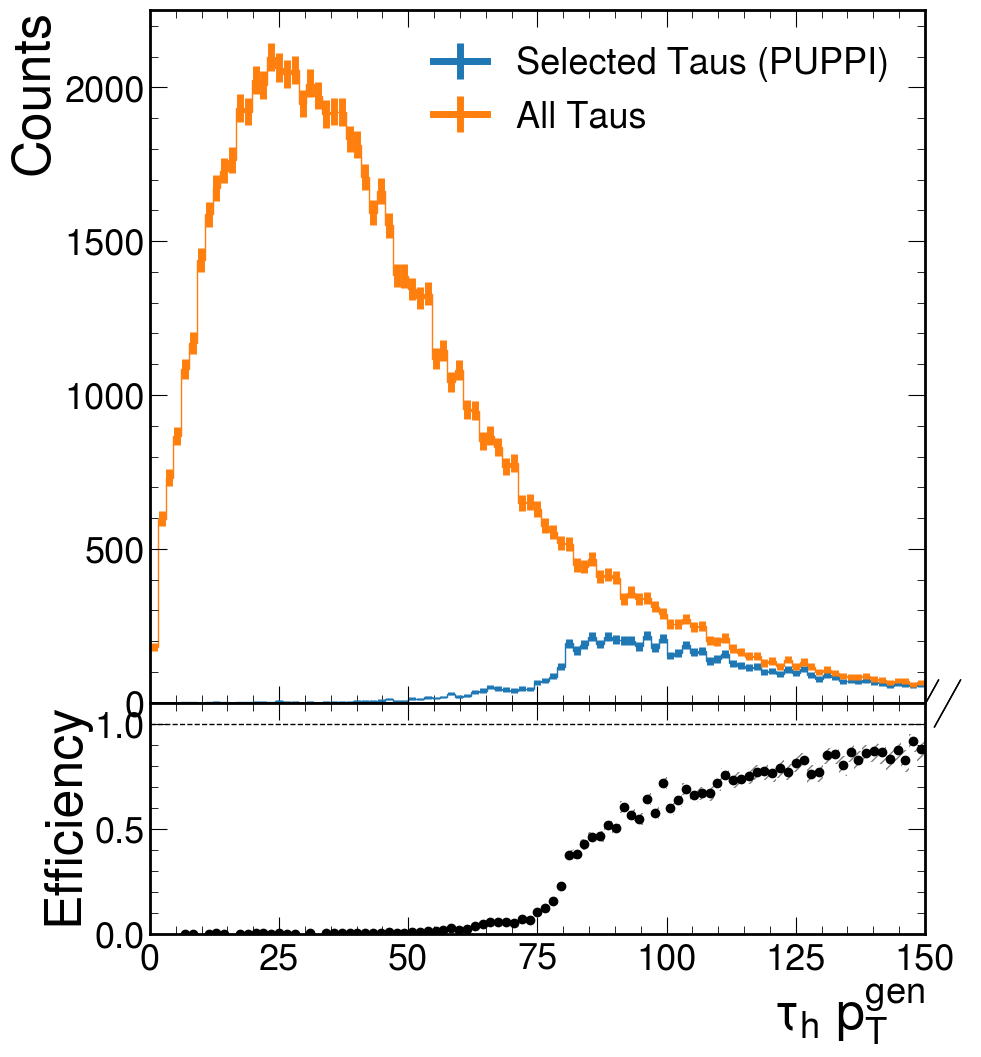

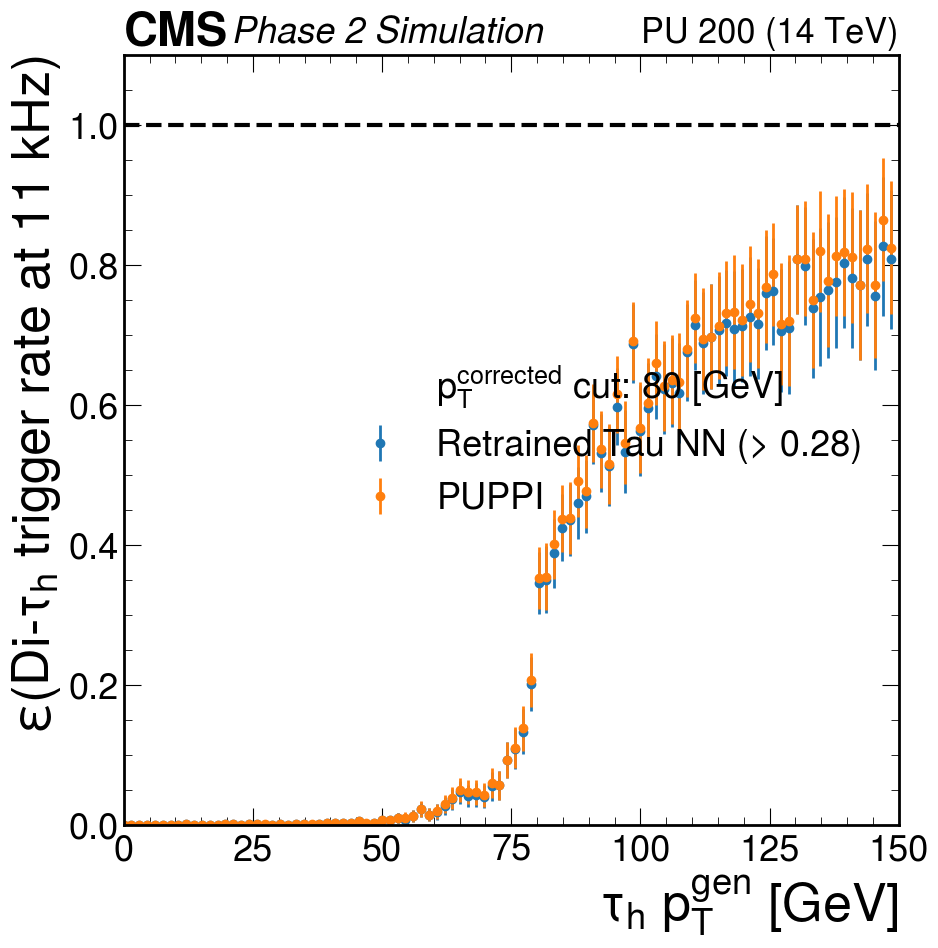

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 1.51930652e-03 0.00000000e+00 0.00000000e+00 1.85840687e-04
 1.66798111e-04 1.18787877e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 1.16869265e-04 0.00000000e+00
 9.16646781e-04 0.00000000e+00 9.17581132e-04 9.15781289e-04
 1.14899165e-04 4.78654787e-04 2.43515628e-03 2.60466705e-03
 2.12050807e-03 3.21001695e-03 5.95861872e-03 1.75256075e-03
 3.06869443e-03 8.20582927e-03 7.49547493e-03 1.10667176e-02
 7.82987802e-03 1.36995395e-02 2.50770658e-02 1.61154692e-02
 2.04730757e-02 3.00989224e-02 4.13802047e-02 5.24750636e-02
 4.52716160e-02 4.82476683e-02 4.37556686e-02 6.03766498e-02
 6.21882500e-02 1.02500500e-01 1.17070186e-01 1.47184715e-01
 2.26230821e-01 3.78889478e-01 3.89983417e-01 4.19858254e-01
 4.69753116e-01 4.72019558e-01 5.15477043e-01 5.13552566e-01
 6.04496029e-01 5.71339263e-01 5.45046649e-01 6.50032647e-01
 5.73394468e-01 7.166841

In [11]:
results = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_no_nn = gen_pT_list


In [12]:
print(gen_pT_list_no_nn)
print(gen_pT_list_nn)

[33.333333333333336, 48.484848484848484, 56.06060606060606, 65.15151515151516, 77.27272727272728, 84.84848484848484, 103.03030303030303, 115.15151515151516, 134.84848484848487, 146.96969696969697]
[15.151515151515152, 27.272727272727273, 34.84848484848485, 43.93939393939394, 54.54545454545455, 63.63636363636363, 74.24242424242425, 92.42424242424244, 103.03030303030303, 118.18181818181819]


In [13]:
def plot_95th(gen_pT_no_nn, gen_pT_nn, threshold_list):
    a, b = np.polyfit(threshold_list, gen_pT_nn, 1)
    c, d = np.polyfit(threshold_list, gen_pT_no_nn, 1)
    fig = plt.figure()
    plt.plot(threshold_list, [a*i + b for i in threshold_list], "--", linewidth = 1)
    plt.plot(threshold_list, gen_pT_nn, "o-", fillstyle='none', linewidth = 1, label = "NN Corrected pT (y = " + str(round(a, 2)) + "x" + " + " + str(round(b, 2)) + ")", color = 'C0')
    plt.plot(threshold_list, [c*i + d for i in threshold_list], "--", linewidth = 1, color = 'r')
    plt.plot(threshold_list, gen_pT_no_nn, "o-", fillstyle='none', linewidth = 1, label = "PUPPI Reco pT (y = " + str(round(c, 2)) + "x" + " + " + str(round(d, 2)) + ")", color = 'r')
    #plt.xlim([20,85])
    #plt.xlim([20,85])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$p_T$ Cut Threshold [GeV]", fontsize = 25)
    plt.ylabel(r"$95\%$ Efficiency Point [GeV]", fontsize = 25)
    plt.legend(loc = 'upper left', fontsize = 18.5)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

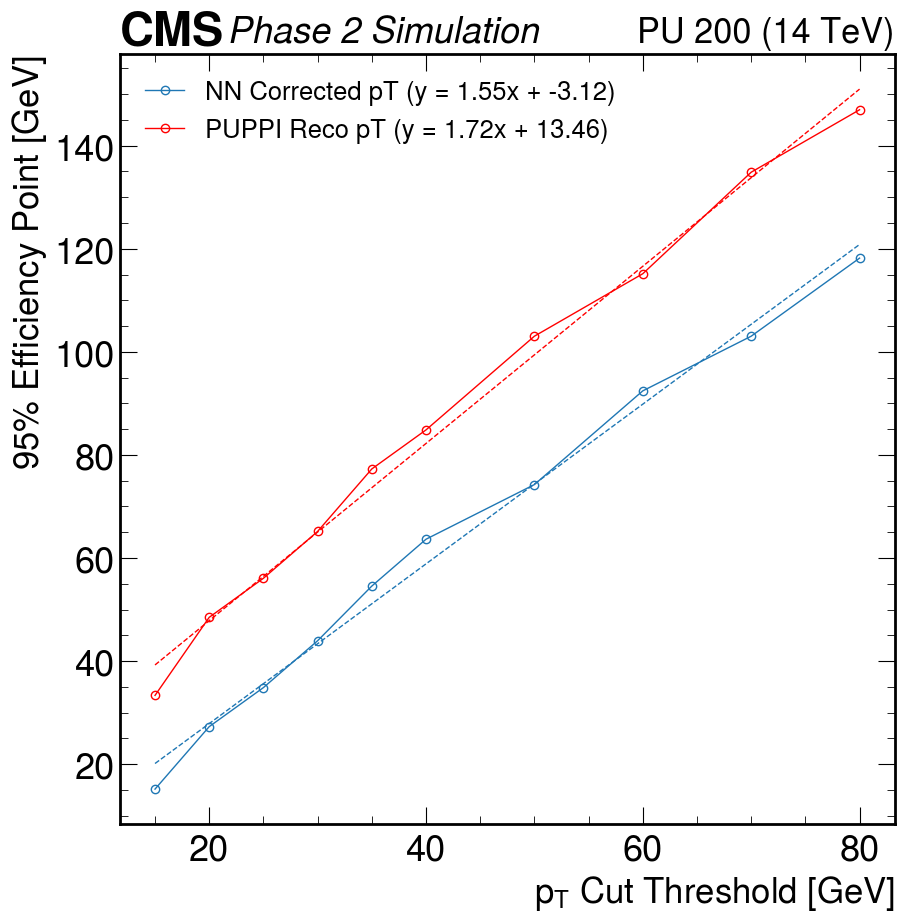

In [14]:

plot_95th(gen_pT_list_no_nn, gen_pT_list_nn, threshold_list)

# maybe make points 